# Community Water System Prediction Model

**Overview**  
The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season.

We develop a machine learning model that predicts which CWS face the highest risk of running out of water. The model architecture is a Support Vector Machine, from the open source scientific software package [scikit-learn](https://scikit-learn.org/stable/). The model is intended to run in production on an annual basis, during April of every year.

The dataset used to train and test the model comprises of 5772 examples that describe 2886 CWS over a span of two years, from 2021 to 2023. We use 15 features and one outcome label to describe each example. The outcome label itself is a composite, consisting of three separate conditions that a CWS may experience: reliance on bottled or hauled water, receipt of a drought violation, or contention of a curtailment. We define a CWS that experiences any one, or multiple, of these conditions, as `DroughtExperienced`. We define a CWS that experiences none of these conditions as not `DroughtExperienced.`

**Features**  
The features in the dataset span various time scales -- some vary annually, others vary seasonally, and some remain static over time. The following table describes each feature and its associated timescale.

Feature | Description | Timescale
---|---|---
`DSCI Dry Season Average`| The [US Drought Monitor Data](https://droughtmonitor.unl.edu/) database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). This feature takes the average value of the DSCI during the dry season, which spans from May 1 to September 30 in any given calendar year. | Seasonal (October 1 - April 1)
`DSCI Wet Season Average`| This feature takes the average value of the DSCI during the wet season, which spans from October 1 in a given calendar year to April 1 in the following year. | Seasonal (May 1 - September 30)
`DSCI Dry Wet Delta`| This feature takes the difference of the average value of the DSCI during the dry season and wet season. The data that goes into this calculation spans 11 months, from May 1 in a given calendar year to April 1 in the following year. | Seasonal (May 1 - April 1)
`Total Number of Water Sources`| As defined in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 74): "Total number of available water sources including surface water, wells, and imported/purchased water." | Annual. We assume this variable indicates the value at the end of the calendar year (December 31). These data may be available quarterly via SAFER.
`Intertie`| As defined in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 76): "An intertie or interconnection is a connection between one or more water systems where systems can either supply or receive water from each other. The presence of interties is assumed to reduce the risk of a water outage by allowing water systems to switch sources and even governance structure support, if needed." If the CWS is not connected to any other water systems, this value is zero. Otherwise it is one. | Annual. We assume this variable indicates the value at the end of the calendar year (December 31). These data may be available quarterly via SAFER.
`Score_CriticallyOverdraftedGroundwaterBasin`| This indicates whether the CWS is located within a critically overdrafted groundwater basin. According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 80): "A basin is subject to critical conditions of overdraft when continuation of current water management practices would probably result in significant adverse overdraft-related environmental, social, or economic impacts." Per table A30, this value equals 0 if fewer than 25% of system’s wells reside in such a basin and 1 otherwise. | Annual. We assume this variable indicates the value at the end of the calendar year (December 31). These data may be available quarterly via SAFER.
`Score_SCV`| According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 82): "The purpose of this risk indicator is to identify water systems that have violated source capacity standards as required in California Waterworks Standards82 within the last three years." If this is true, the value of Score_SCV equals 1. Otherwise it is 0. | Annual. We assume this variable describes three years of data, from January 1 of the first year to December 31 of the third year. These data may be available quarterly via SAFER.
`Score_SCM`| This risk indicator identifies whether a water system experienced a service connection moratorium within the last three years. | Annual. This feature describes the last three years of behavior.
`Curtailment`| Whether the CWS experienced a curtailment within the calendar year. | Annual
`ServiceConnections`| The number of service connections to a CWS. | Annual
`PWPhysicalAddressLat`| The latitude of the CWS. | Static
`PWPhysicalAddressLong`| The longitude of the CWS. | Static
`HUC_Categories`| Whether the CWS is located in a coastal region (1), the central valley (2), or some other region (3). | Static
`Population`| The population served by a given CWS. | Static
`Wholesalers`| Whether (1) or not (0) the CWS is a wholesaler. These CWS do not serve anybody directly, but serve other CWS -- which in turn, serve people directly. | Static

**Label**  
The labels in the dataset span various time scales. The following table describes each label and its associated timescale.

Label | Description | Timescale
---|---|---
`WaterOutageDroughtViolation`| Describes wether (1) or not (0) the system experienced a water outage violation in the last year. | Annual
`BottledHauledWaterOrZeroSource`| According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf): "The purpose of this risk indicator is to identify water systems that have had to supplement or replace their source of supply to meet customer demand with bottled water, and/or hauled water at any point within the past three years." | We use this annually, but it is available quarterly via SAFER. This feature describes the last three years of behavior.
`CurtailmentExemptionPetition`|  Describes wether (1) or not (0) the system petitioned a curtailment in the last year.| Annual
`DroughtExperienced`|  Describes wether (1) or not (0) the system petitioned a curtailment in the last year.| Annual


**Resources**  
* A [searchable website](https://sdwis.waterboards.ca.gov/PDWW/) of community water systems
* A [searchable map](https://gispublic.waterboards.ca.gov/portal/apps/webappviewer/index.html?id=272351aa7db14435989647a86e6d3ad8) of community water systems

Import some packages.

To use water.ipynb notebooks together with all the requisite Python packages, create a new conda environment called water using the provided environment file by running this command: 
```python
conda env create -f environment.yml
```

In [1]:
import boto3
import time
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from raiutils.exceptions import UserConfigValidationException
import dice_ml # raiutils import must precede dice_ml import, violating flake8

from raiutils.exceptions import UserConfigValidationException
from datetime import datetime as dt_obj
from sklearn.datasets import make_blobs
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from IPython.display import display
from vega_datasets import data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 3000)

/Users/monica.bobra/anaconda3/envs/water/lib/python3.11/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


### Create 2021 Data

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021: `DroughtWatchPrioritization_v4.csv` and 
`DroughtWatchPrioritization_v9_input_data_with_TNC.csv`.  The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`.

In [2]:
BUCKET_NAME = 'aae-water-dev-us-west-2'

In [3]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
water_bucket = s3.Bucket(BUCKET_NAME)

In [4]:
def get_data_from_s3(filename):
    """
        Get data from S3 bucket.

        Parameters
        ----------
        filename : str
            Name of file to get from S3 bucket.

        Returns
        -------
        df : pandas.DataFrame
            Dataframe of data from S3 bucket.

        Examples
        --------
        >>> get_data_from_s3(filename='data.csv')
    """
    for water_bucket_object in water_bucket.objects.all():
        response = s3_client.get_object(Bucket=BUCKET_NAME, Key=filename)
        status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
        print('Status equals {}, getting {}.'.format(status, filename))
        if status == 200:
            df = pd.read_csv(response.get("Body"))
            return(df)

Read in the initial data sets:

In [5]:
df1 = get_data_from_s3(filename='DroughtWatchPrioritization_v4.csv')
df2 = get_data_from_s3(filename='DroughtWatchPrioritization_v9_input_data_with_TNC.csv')

Status equals 200, getting DroughtWatchPrioritization_v4.csv.
Status equals 200, getting DroughtWatchPrioritization_v9_input_data_with_TNC.csv.


The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [6]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [7]:
df_2021_initial = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Remove the '-' character from the HUC8 values to make them consistent with other datasets.

In [8]:
df_2021_initial['HUC8'] = df_2021_initial['HUC8'].str.replace("-", "").astype(int)

Add a column called `Water Year` and set the the values to 2021:

In [9]:
df_2021_initial['Water Year'] = 2021

#### A. Add [US Drought Monitor Data](https://droughtmonitor.unl.edu/)

The US Drought Monitor Database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). These data are available on a weekly cadence from 2000 until the present day.

**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain DSCI data per HUC8 code per unit time.** 
* The [US Drought Monitor Index](https://droughtmonitor.unl.edu/) provides several drought-related datasets. These data are available through a REST API. 
* Construct the URL for the REST API. The query terms are: 
  * `[area]` = `HUCStatistics`
  * `[statistics type]` = `GetDroughtSeverityStatisticsByAreaPercent` (Note: One could use `GetDSCI`, but this will not return HUC8 codes as a key)
  * `[aoi]` = Any given HUC8 code, e.g. 15040004
  * `[start date]` = 01/01/2021
  * `[end date]` = 01/01/2022
  * `[statistics type]` = 2. (Note: This is a different keyword from the first statistics type. A statistics type of 2 refers to categorical statistics).
* Here is an example URL: url_dsci = `https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi=15040004&startdate=1/2/2021&enddate=12/27/2021&statisticsType=2`

**Step 3: Calculate the Drought Severity and Coverage Index (DSCI).** Compute a weighted sum of the categorical percent area as described [here](https://droughtmonitor.unl.edu/About/AbouttheData/DSCI.aspx): DSCI = 1(D0) + 2(D1) + 3(D2) + 4(D3) + 5(D4)

Note: As of Monday, July 17 2023, the USDM Rest API is down. I have downloaded all the relevant data from the [comprehensive statistics](https://droughtmonitor.unl.edu/DmData/DataDownload/ComprehensiveStatistics.aspx) page into a file called `DSCI.csv` for temporary use. 

* Select all HUC8 codes that start with 15, 16, 17, and 18.
* Select Statistics Type = Categorical.

Complete Step 1:

In [10]:
# Read in the simplified mapping of HUC8 codes within the stae of California from the California Open Data Portal
url_huc8 = 'https://gis.data.cnra.ca.gov/datasets/02ff4971b8084ca593309036fb72289c_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'
df_huc8 = pd.read_csv(url_huc8)

In [11]:
# Define the dry seasons
dry_seasons_start = [dt_obj.fromisoformat('2022-05-01'), dt_obj.fromisoformat('2021-05-01')]
dry_seasons_end = [dt_obj.fromisoformat('2022-09-30'), dt_obj.fromisoformat('2021-09-30')]

# Define the wet seasons
wet_seasons_start = [dt_obj.fromisoformat('2022-10-01'), dt_obj.fromisoformat('2021-10-01')]
wet_seasons_end = [dt_obj.fromisoformat('2023-04-01'), dt_obj.fromisoformat('2022-04-01')]

Complete Steps 2 and 3:

In [12]:
def compute_dsci_per_season(filename):
    """
    This function computes the average DSCI per season for each HUC8 region in California.

    Parameters
    ----------
    filename : str
        The name of the file to be read.

    Returns
    -------
    all_average_dscis_dry_season : list
        A list of lists containing the average DSCI per dry season for each HUC8 region in California.
    all_average_dscis_wet_season : list
        A list of lists containing the average DSCI per wet season for each HUC8 region in California.
    all_delta_dscis : list
        A list of lists containing the change in average DSCI between dry and wet seasons for each HUC8 region in California.
    all_huc_ids : list
        A list of HUC8 region IDs.

    Examples
    --------
    >>> all_average_dscis_dry_season, all_average_dscis_wet_season, all_delta_dscis, all_huc_ids = compute_dsci_per_season(filename='DSCI.csv')
    """

    # Get the filename
    df_dsci = get_data_from_s3(filename=filename)

    # Define some empty lists for variables of interest
    all_huc_ids = []
    all_average_dscis_dry_season = []
    all_average_dscis_wet_season = []
    all_delta_dscis = []

    for i in range(len(df_huc8['HUC8'])):
        # Define some empty lists to hold temporary variables
        years_average_dscis_dry_season = []
        years_average_dscis_wet_season = []
        years_delta_dscis = []

        # Get an individual HUC8 region in California
        one_huc8_code = df_huc8['HUC8'][i]
        df_one_huc = df_dsci[df_dsci['HUCId'] == one_huc8_code].reset_index()
        if len(df_one_huc) == 0:
            print('Empty data for HUC8 region', one_huc8_code, df_huc8['Name'][i])
        else:
            print('Reading data for HUC8 region', one_huc8_code, df_huc8['Name'][i])
            # Convert the keyword MapDate into a datetime object
            df_one_huc['MapDate']=pd.to_datetime(df_one_huc['MapDate'], format='%Y%m%d').reset_index(drop=True)

            # Save the data to a list
            all_huc_ids.append(one_huc8_code)

            for j in range(len(dry_seasons_start)):
                # Identify one dry season
                mask_dry = (df_one_huc['MapDate'] > dry_seasons_start[j]) & (df_one_huc['MapDate'] <= dry_seasons_end[j])
                df_dry = df_one_huc[mask_dry]

                # Calculate the maximum, average, and standard deviation of the DSCI during the dry season
                average_dsci_dry_season = np.nanmean(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)

                # Identify one wet season
                mask_wet = (df_one_huc['MapDate'] > wet_seasons_start[j]) & (df_one_huc['MapDate'] <= wet_seasons_end[j])
                df_wet = df_one_huc[mask_wet]

                # Calculate the average DSCI during the wet season
                average_dsci_wet_season = np.nanmean(1*df_wet.D0 + 2*df_wet.D1 + 3*df_wet.D2 + 4*df_wet.D3 + 5*df_wet.D4)

                # Calculate the change in average DSCI between dry and wet seasons
                delta_dsci = average_dsci_dry_season - average_dsci_wet_season

                # Concatenate each feature by years
                years_average_dscis_dry_season.append(average_dsci_dry_season)
                years_average_dscis_wet_season.append(average_dsci_wet_season)
                years_delta_dscis.append(delta_dsci)

            # Save the data to a list
            all_average_dscis_dry_season.append(years_average_dscis_dry_season)
            all_average_dscis_wet_season.append(years_average_dscis_wet_season)
            all_delta_dscis.append(years_delta_dscis)
    
    return all_average_dscis_dry_season, all_average_dscis_wet_season, all_delta_dscis, all_huc_ids

In [13]:
all_average_dscis_dry_season, all_average_dscis_wet_season, all_delta_dscis, all_huc_ids = compute_dsci_per_season(filename='DSCI.csv')

Status equals 200, getting DSCI.csv.
Reading data for HUC8 region 18100204 Salton Sea
Reading data for HUC8 region 18070303 San Luis Rey-Escondido
Reading data for HUC8 region 18070304 San Diego
Reading data for HUC8 region 18020162 Upper Putah
Reading data for HUC8 region 18050001 Suisun Bay
Reading data for HUC8 region 15030102 Piute Wash
Reading data for HUC8 region 18100100 Southern Mojave
Reading data for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Reading data for HUC8 region 18060003 Carrizo Plain
Reading data for HUC8 region 18060007 Cuyama
Reading data for HUC8 region 18070102 Santa Clara
Reading data for HUC8 region 18090206 Antelope-Fremont Valleys
Reading data for HUC8 region 18020002 Upper Pit
Reading data for HUC8 region 18080002 Madeline Plains
Reading data for HUC8 region 17100309 Applegate
Reading data for HUC8 region 17100311 Illinois
Reading data for HUC8 region 18030009 Upper Dry
Reading data for HUC8 region 18040001 Middle San Joaquin-Lower Chowchill

Create pandas dataframes containing the variables for both 2021 and 2022:

In [14]:
df_drought_data_2021 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2021]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[0] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[0] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[0] for item in all_delta_dscis],
})

In [15]:
df_drought_data_2022 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2022]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[1] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[1] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[1] for item in all_delta_dscis],
})

Merge in the DSCI data.

In [16]:
df_2021 = df_2021_initial.merge(df_drought_data_2021, on=['HUC8'], how='left')

Fill any NaNs with zeros.

In [17]:
df_2021['DSCI Dry Season Average'] = df_2021['DSCI Dry Season Average'].fillna(0)
df_2021['DSCI Wet Season Average'] = df_2021['DSCI Wet Season Average'].fillna(0)
df_2021['DSCI Dry Wet Delta'] = df_2021['DSCI Dry Wet Delta'].fillna(0)

#### B. Add SAFER 2021 Data

Table A2 of the [SAFER 2023 Drinking Water Needs Assessment](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023needsassessment.pdf) indicates each component of the SAFER score. These data are available in [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/docs/a1.xlsx) of the 2021 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total" under the tab titled "Accessibility Raw Data".

In [18]:
df_SAFER_2021 = get_data_from_s3(filename='SAFER_2021.csv')

Status equals 200, getting SAFER_2021.csv.


In [19]:
df_SAFER_2021 = df_SAFER_2021[['PWSID','Total']].rename(columns={'PWSID': 'CWSID', 'Total':'Total Number of Water Sources'})

In [20]:
df_2021 = df_2021.merge(df_SAFER_2021, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Some CWS do not have a value for total number of water sources. Assume they only have one source.

In [21]:
df_2021['Total Number of Water Sources'] = df_2021['Total Number of Water Sources'].fillna(1)

#### C. Refine Keywords for 2021 Data

Rename columns so they make more sense.

In [22]:
df_2021.columns = df_2021.columns.str.removesuffix("_x")
df_2021.columns = df_2021.columns.str.removesuffix("_y")

In [23]:
# Drop duplicate columns
df_2021 = df_2021.loc[:,~df_2021.columns.duplicated()].copy()

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [24]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df_2021['CentralValleyCounties'] = df_2021['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [25]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df_2021['FracturedRock'] = df_2021['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [26]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df_2021['CurtailedWatershed'] = df_2021['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [27]:
# Create HUC_Categories

df_2021['HUC8_CentralValley'] = df_2021['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Coast'] = df_2021['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df_2021 = df_2021.replace(to_replace='HUC8_Coast', value=1)
df_2021 = df_2021.replace(to_replace='HUC8_CentralValley', value=2)
df_2021 = df_2021.replace(to_replace='HUC8_Other', value=3)

df_2021['HUC_Categories'] = np.nan

df_2021['HUC_Categories'] = df_2021[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df_2021 = df_2021.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

#### D. Re-calculate outcome label `DroughtExperienced`

For the 2021 data, the label `DroughtExperienced` was based on five variables: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, and `FundedProject`. If any of these variables had a value of 1, then the `DroughtExperienced` had a value of 1. If all of these variables had a value of 0, then `DroughtExperienced` had a value of 0. Later, it was mentioned that `Score_1702` should have been factored into `DroughtExperienced`.

After using both versions of `DroughtExperienced` (with and without `Score_1702`), we discovered that the eRA scores contain subjective responses that vary wildly between one CWS and another. This essentially adds noise to the model, increasing the false negative rate. The SAFER consortium observed the same in its [2023 annual report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf), noting that "In 2021, the State Water Board expanded the electronical Annual Report (eAR) to require the submission of income data for the first time. Many water systems struggled to provide thisinformation. Many water systems may have provided inaccurate data ... ."

Therefore, we will construct a new version of `DroughtExperienced` that removes all the eRA scores (`Score_1704` and `Score_1702`) as well as `FundedProject`. In this current definition, `DroughtExperienced` comprises of three constituent parts: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, and `CurtailmentExemptionPetition`. If any of these values are 1, then `DroughtExperienced` equals 1. Otherwise, `DroughtExperiened` equals 0. 

In [28]:
# Rewrite all values of DroughtExperienced with np.NaN
df_2021['DroughtExperienced'] = np.NaN

In [29]:
df_2021['DroughtExperienced'].unique()

array([nan])

In [30]:
conditions = [
    (df_2021['WaterOutageDroughtViolation'].eq(1)) |
    (df_2021['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2021['CurtailmentExemptionPetition'].eq(1))  
]

choicelist = [1]

In [31]:
df_2021['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [32]:
df_2021['DroughtExperienced'].unique()

array([0, 1])

In [33]:
print("In 2021, ",df_2021[df_2021['DroughtExperienced'] == 1]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  952732 people in California experienced some form of drought.


In [34]:
df_2021.shape

(2866, 54)

#### E. Flag some data quality issues

Why are there multiple CWS at the same location?

In [35]:
df_2021[['CWSID', 'ServiceConnections', 'Population', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

CWSID  ServiceConnections  Population  PWPhysicalAddressLat  \
30  CA0310003                1742        4943             38.382864   
31  CA0310004                 520        1060             38.480957   
32  CA0310005                 388         907             38.413058   
33  CA0310006                 215         510             38.544707   
34  CA0310008                 211        1184             38.191586   
35  CA0310011                 337         838             38.458547   
36  CA0310012                2743        8809             38.382864   
37  CA0310018                  82         200             38.447565   
38  CA0310019                  55         188             38.382864   

    PWPhysicalAddressLong  
30            -120.787745  
31            -120.847427  
32            -120.658861  
33            -120.741079  
34            -120.829103  
35            -120.541518  
36            -120.787745  
37            -120.537917  
38            -120.787745

Note that there are 38 CWSIDs with a population of zero, which seems like an incorrect value. 

```python
df_2021[df_2021['Population'] == 0.0][['CWSID','Population']]
```

These are wholesalers that only sell water; however, SDWIS assigns a population to these CWS, e.g. [CA3710042](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=3927&tinwsys_st_code=CA) serves 3.3M people.

#### F. Select keywords to use in model

In [36]:
keywords_to_use_in_the_model = [
 'CWSID',                                        # Unique Identifier
 'Water Year',                                   # Unique Identifier
 'HUC8',                                         # Unique Identifier
 'DroughtExperienced',                           # Label
 'WaterOutageDroughtViolation',                  # Label
 'BottledHauledWaterOrZeroSource',               # Label
 'CurtailmentExemptionPetition',                 # Feature        
 'DSCI Dry Season Average',                      # Feature
 'DSCI Wet Season Average',                      # Feature
 'DSCI Dry Wet Delta',                           # Feature
 'Intertie',                                     # Feature
 'ServiceConnections',                           # Feature
 'Population',                                   # Feature
 'Score_SCV',                                    # Feature
 'Score_SCM',                                    # Feature
 'Curtailment',                                  # Feature
 'Score_CriticallyOverdraftedGroundwaterBasin',  # Feature
 'PWPhysicalAddressLong',                        # Feature
 'PWPhysicalAddressLat',                         # Feature
 'HUC_Categories',                               # Feature
 'Total Number of Water Sources'                 # Feature
]

In [37]:
df_2021 = df_2021[keywords_to_use_in_the_model]

### Create 2022 Data

The original data covered the year 2021. Add data that covers the year 2022.
Follow the steps in the [Analytical File Specifications](https://docs.google.com/document/d/104HVf3_-9r174I6ZWnu0zzyngckeEz19HmvarQ5yJpM/edit).

#### A. Create a new dataframe for the 2022 data

Create a new dataframe for 2022 data and add the US Drought Monitor data for 2022.

In [38]:
df_2022 = df_2021[['CWSID', 'HUC8']]

Merge in the DSCI data and define the water year.

In [39]:
df_2022 = df_2022.merge(df_drought_data_2022, on='HUC8', how='left')

In [40]:
df_2022['Water Year'] = 2022

#### B. Add the labels

There are three labels in the model:
1. `WaterOutageDroughtViolation`
2. `BottledHauledWaterOrZeroSource`
3. `CurtailmentExemptionPetition`

##### 1. `WaterOutageDroughtViolation`
These data are in the file `Water_Outage_Report_SDWISViolations.csv`.

In [41]:
df_outage = get_data_from_s3(filename='Water_Outage_Report_SDWISViolations.csv')

Status equals 200, getting Water_Outage_Report_SDWISViolations.csv.


In [42]:
# Retain only three fields and rename water system id to CWSID
df_outage = df_outage[['water system id', 'Begin Date', 'End Date']].rename(columns={'water system id': 'CWSID'})

In [43]:
df_2022 = df_2022.merge(df_outage, how='left').drop_duplicates().reset_index(drop=True)

In [44]:
df_2022['WaterOutageDroughtViolation'] = np.NaN

In [45]:
# Convert the keywords Begin Date and End Date into a datetime object
df_2022['Begin Date'] = pd.to_datetime(df_2022['Begin Date'], format = '%Y-%m-%d')
df_2022['End Date'] = pd.to_datetime(df_2022['End Date'], format = '%Y-%m-%d')

In [46]:
# Identify the 2022 water season
# Define the dry season 2021
start_2022_water_season = dt_obj.fromisoformat('2021-10-01')
end_2022_water_season = dt_obj.fromisoformat('2022-09-30')

Step 1: Identify all cases where a `Begin Date` and `End Date` fall within any point of the 2022 water season (10/2021 - 9/2022). This identifies three cases.

In [47]:
mask_2022_water_season_1 = (df_2022['Begin Date'] > start_2022_water_season) & (df_2022['End Date'] <= end_2022_water_season)
df_water_season_1 = df_2022[mask_2022_water_season_1]

In [48]:
df_water_season_1

CWSID      HUC8  Water Year  DSCI Dry Season Average  \
177   CA0910006  18040013        2022               462.742727   
1431  CA3301512  18100201        2022               322.437273   
1582  CA3500823  18060002        2022               390.096818   

      DSCI Wet Season Average  DSCI Dry Wet Delta Begin Date   End Date  \
177                376.136538           86.606189 2022-07-11 2022-07-24   
1431               250.790769           71.646503 2022-03-01 2022-04-30   
1582               346.423077           43.673741 2022-05-31 2022-08-04   

      WaterOutageDroughtViolation  
177                           NaN  
1431                          NaN  
1582                          NaN

Step 2: Identify all cases with a `Begin Date` at any time with no end date. This identifies zero cases.

In [49]:
mask_2022_water_season_2 = (df_2022['Begin Date'] != pd.NaT) & (df_2022['End Date'] == pd.NaT)
df_water_season_2 = df_2022[mask_2022_water_season_2]

Set the value of `WaterOutageDroughtViolation` equal to 1 for the three cases identified in Step 1.

In [50]:
df_2022.loc[mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 1

And set the other values to zero.

In [51]:
df_2022.loc[~mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 0

In [52]:
df_2022 = df_2022.drop(columns=['Begin Date', 'End Date'])

In [53]:
df_2022['WaterOutageDroughtViolation'] = df_2022['WaterOutageDroughtViolation'].astype('int').fillna(0)

In [54]:
df_2022.shape

(2866, 7)

##### 2. `BottledHauledWaterOrZeroSource`

These data are in the files `2022BottledHauledWater_Drought Experienced.csv`. However, some CWSIDs should be excluded from this list. The excluded CWSIDs are in the list `2022BottledHauledWater_Excluded.csv`.

In [55]:
df_bottled = get_data_from_s3(filename='2022BottledHauledWater_Drought Experienced.csv')
df_excluded = get_data_from_s3(filename='2022BottledHauledWater_Excluded.csv')

Status equals 200, getting 2022BottledHauledWater_Drought Experienced.csv.
Status equals 200, getting 2022BottledHauledWater_Excluded.csv.


Rename the column `Bottled Water or Hauled Water Reliance\r\n` (this regex syntax encapsulates the new line in the csv file) as `BottledHauledWaterOrZeroSource` and drop all the rest of the columns.

In [56]:
df_bottled = df_bottled.rename(columns={
    'PWSID': 'CWSID', 
    'Bottled Water or Hauled Water Reliance\r\n':'BottledHauledWaterOrZeroSource'
}).drop(columns=[
    'Number of Water Sources\r\n', 'Absence of Interties\r\n',
    'Source Capacity Violations\r\n',
    'DWR – Drought & Water Shortage Risk Assessment Results',
    'Critically Overdrafted Groundwater Basin',
    'Drought Experienced (Bottled Hauled Water Reliance)'
])

In [57]:
bottled_water_dictionary = {'Y':1}
df_bottled['BottledHauledWaterOrZeroSource'] = df_bottled['BottledHauledWaterOrZeroSource'].apply(lambda x: bottled_water_dictionary[x])

In [58]:
df_2022 = df_2022.merge(df_bottled, how='left', on='CWSID').drop_duplicates().reset_index(drop=True).fillna(0)

In [59]:
df_excluded

CWSID                                   Name
0  CA1500393   RAINBIRD VALLEY MUTUAL WATER COMPANY
1  CA1500442                   SUNSET APARTMENTS WS
2  CA1500455  WILLIAM FISHER MEMORIAL WATER COMPANY
3  CA1500458              R.S. MUTUAL WATER COMPANY
4  CA1500461            FOUNTAIN TRAILER PARK WATER
5  CA1510052                       NORTH EDWARDS WD
6  CA2610003                         BRIDGEPORT PUD
7  CA4100529                          CAMP LOMA MAR
8  CA5000389                MONTEREY PARK TRACT CSD

In [60]:
out = df_2022.loc[df_2022['CWSID'].isin(list(df_excluded['CWSID']))].replace(1,0)

In [61]:
df_2022.loc[list(out.index)] = df_2022.loc[list(out.index)].replace(1,0)

In [62]:
df_2022['BottledHauledWaterOrZeroSource'] = df_2022['BottledHauledWaterOrZeroSource'].astype('int').fillna(0)

In [63]:
df_2022.shape

(2866, 8)

##### 3.  `CurtailmentExemptionPetition`

In addition to adding the label `CurtailmentExemptionPetition`, we can also add the feature `Curtailment` at this stage. Follow a similar example, renaming the necessary variables and dropping the rest.

In [64]:
df_curtailment = get_data_from_s3(filename='Curtailed.csv')

Status equals 200, getting Curtailed.csv.


In [65]:
df_curtailment = df_curtailment.drop(columns=[
    'REG_AGENCY', 'COUNTY', 'PWS_NAME', 'WS_FED_TYPE',
    'SERVICE_CONNECTIONS', 'POPULATION', 'FAC_ID', 'FAC_NAME',
    'WR_TYPE', 'Claimed Priority Date', 'August Curtailment Status',
    'September Curtailment Status', 'DWR October Curtailment Status',
    'Watershed', 'Unnamed: 17', 'Exemptions',
    'Petitions', 'Unnamed: 20'
]).rename(columns={'WS_ID': 'CWSID', 'Exemption or Petition':'CurtailmentExemptionPetition', 'APPL_ID':'Curtailment'})

In [66]:
df_curtailment.columns

Index(['CWSID', 'Curtailment', 'CurtailmentExemptionPetition'], dtype='object')

In [67]:
df_curtailment['CurtailmentExemptionPetition'].unique()

array([nan, 'Petition - Approved', 'Exemption', 'Petition - Pending',
       'Petition - Withdrawn'], dtype=object)

In [68]:
df_curtailment[df_curtailment['Curtailment'].isna()]

CWSID Curtailment CurtailmentExemptionPetition
114  CA2300606         NaN                          NaN
115  CA2300731         NaN                          NaN
116  CA2300837         NaN                          NaN
120  CA2310010         NaN                          NaN
122  CA4900521         NaN                          NaN
128  CA4900665         NaN                          NaN
129  CA4900736         NaN                          NaN
133  CA4910024         NaN                          NaN

In [69]:
df_2022 = df_2022.merge(df_curtailment, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [70]:
df_exemption_dictionary = {np.NaN:0, 'Exemption':1, 'Petition - Approved':1, 'Petition - Withdrawn':0, 'Petition - Pending':1}
df_2022['CurtailmentExemptionPetition'] = df_2022['CurtailmentExemptionPetition'].apply(lambda x: df_exemption_dictionary[x])

In [71]:
df_2022['CurtailmentExemptionPetition'].value_counts()

0    2813
1      53
Name: CurtailmentExemptionPetition, dtype: int64

In [72]:
conditions = [(~df_2022['Curtailment'].isna()),
              (df_2022['Curtailment'].isna())]

choicelist = [1,0]

In [73]:
df_2022['Curtailment'] = np.select(conditions, choicelist, default=0)

In [74]:
df_2022['Curtailment'].value_counts()

0    2735
1     131
Name: Curtailment, dtype: int64

In [75]:
df_2022.shape

(2866, 10)

##### 4. `DroughtExperienced`

This label is calculated in the same way as it is for 2021.

In [76]:
conditions = [
    (df_2022['WaterOutageDroughtViolation'].eq(1)) |
    (df_2022['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2022['CurtailmentExemptionPetition'].eq(1)) 
]

choicelist = [1]

In [77]:
df_2022['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [78]:
df_2022.shape

(2866, 11)

#### C. Add the features

##### 1. Intertie
This feature indicates whether a water system is connected to another water system. If the CWS is not connected to any other water systems, this value is zero. Otherwise it is one. These data come from the the [SWDIS](https://sdwis.epa.gov/ords/sfdw_pub/r/sfdw/sdwis_fed_reports_public/103?clear=RP) and [EPA](https://www.epa.gov/ground-water-and-drinking-water/safe-drinking-water-information-system-sdwis-federal-reporting).

In [79]:
df_SDWIS_sources = get_data_from_s3(filename='Interties.csv')

Status equals 200, getting Interties.csv.


In [80]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=[
    'Groundwater', 'Surface Water']).rename(columns={'PWSID': 'CWSID', 'Interties':'Number_Interties'})

In [81]:
conditions = [(df_SDWIS_sources['Number_Interties'].eq(0)),
              (df_SDWIS_sources['Number_Interties'].ne(0))]

choicelist = [0,1]

In [82]:
df_SDWIS_sources['Intertie'] = np.select(conditions, choicelist, default=0)

In [83]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=['Number_Interties'])

In [84]:
df_2022 = df_2022.merge(df_SDWIS_sources, how='left', on='CWSID')

In [85]:
df_2022['Intertie'] = df_2022['Intertie'].fillna(0)

In [86]:
df_2022.shape

(2866, 12)

##### 2. ServiceConnections, SAFER_AccessibilityScore, & Score_CriticallyOverdraftedGroundwaterBasin

The SAFER Accessibility score is calculated in the [2022 Drinking Water Needs Assessment: Risk Assessment for Public Water Systems](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022riskassessment.pdf) of the SAFER website.

See the up-to-date [SAFER dashboard](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/saferdashboard.html) here. 

In [87]:
df_SAFER = get_data_from_s3(filename='Drinking_Water_Risk_Assessment.csv')

Status equals 200, getting Drinking_Water_Risk_Assessment.csv.


In [88]:
df_SAFER = df_SAFER[['WATER_SYSTEM_NUMBER',
                     'SERVICE_CONNECTIONS',
                     'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE']].rename(columns={'WATER_SYSTEM_NUMBER': 'CWSID', 
                                                                                            'SERVICE_CONNECTIONS':'ServiceConnections', 
                                                                                            'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE':'Score_CriticallyOverdraftedGroundwaterBasin'})

In [89]:
df_SAFER = df_SAFER.replace('Not Assessed', np.NaN)

In [90]:
df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'] = df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')

In [91]:
df_SAFER.dtypes

CWSID                                          object
ServiceConnections                              int64
Score_CriticallyOverdraftedGroundwaterBasin     int64
dtype: object

In [92]:
df_2022 = df_2022.merge(df_SAFER, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [93]:
df_2022['Score_CriticallyOverdraftedGroundwaterBasin'] = df_2022['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')
df_2022['ServiceConnections'] = df_2022['ServiceConnections'].fillna(0)

In [94]:
df_2022.shape

(2866, 14)

Add data from [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022risk.xlsx) of the 2022 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total Number of Water Sources" under the tab titled "Accessibility Raw Data Summary".

In [95]:
df_SAFER_2022 = get_data_from_s3(filename='SAFER_2022.csv')

Status equals 200, getting SAFER_2022.csv.


In [96]:
df_SAFER_2022 = df_SAFER_2022[['PWSID','Total Number of Water Sources ']].rename(columns={'PWSID': 'CWSID', 'Total Number of Water Sources ':'Total Number of Water Sources'})

In [97]:
df_2022 = df_2022.merge(df_SAFER_2022, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Again, assume that NaN values of the keyword `Total Number of Water Sources` equal one.

In [98]:
df_2022['Total Number of Water Sources'] = df_2022['Total Number of Water Sources'].fillna(1)

##### 3. Score_SCV 

Source Capacity Violations tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [99]:
df_SCV = get_data_from_s3(filename='Source_Capacity_Violations.csv')

Status equals 200, getting Source_Capacity_Violations.csv.


In [100]:
df_SCV = df_SCV[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [101]:
df_SCV['Score_SCV'] = 1

In [102]:
df_2022 = df_2022.merge(df_SCV, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [103]:
df_2022['Score_SCV'] = df_2022['Score_SCV'].fillna(0)

In [104]:
df_2022.shape

(2866, 16)

##### 4. Score_SCM 
See the Service Connection Moratoriums tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [105]:
df_SCM = get_data_from_s3(filename='Service_Connection_Moratoriums.csv')

Status equals 200, getting Service_Connection_Moratoriums.csv.


In [106]:
df_SCM = df_SCM[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [107]:
df_SCM['Score_SCM'] = 1

In [108]:
df_2022 = df_2022.merge(df_SCM, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [109]:
df_2022['Score_SCM'] = df_2022['Score_SCM'].fillna(0)

In [110]:
df_2022.shape

(2866, 17)

##### 5. Add SAFER Clearinghouse Data

This dataset will identify which CWS are wholesalers. Wholesalers sell water to multiple community water systems and all of them have a `DroughtExperienced` label of zero. This means predicting drought is a network problem -- those that are connected to wholesalers will likely not lose water, whereas those that are will are more at risk.

In [111]:
df_wholesalers = get_data_from_s3(filename='SAFER_CLEARINGHOUSE_Wholesalers.csv')

Status equals 200, getting SAFER_CLEARINGHOUSE_Wholesalers.csv.


In [112]:
df_wholesalers = df_wholesalers[['PWSID', 'PRIMARY_SERVICE_AREA_TYPE']].rename(columns={'PWSID':'CWSID'}).drop_duplicates().reset_index(drop=True)

In [113]:
df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].unique()

array(['RESIDENTIAL AREA              ', 'MOBILE HOME PARK              ',
       'K-12 SCHOOL                   ', 'MUNICIPALITY                  ',
       'WHOLESALER (SELLS WATER)      ', 'OTHER AREA                    ',
       'SCHOOL                        ', 'DAY CARE CENTER               ',
       'RECREATION AREA               ', 'INSTITUTION                   ',
       'HIGHER EDUCATION SCHOOL       ', 'MEDICAL FACILITY              ',
       'SECONDARY RESIDENCES          ', 'INDUSTRIAL/AGRICULTURAL       ',
       'OTHER RESIDENTIAL AREA        ', 'SUMMER CAMP                   ',
       'OTHER NON-TRANSIENT AREA      ', 'OTHER TRANSIENT AREA          ',
       'SUBDIVISION                   ', 'HOTEL/MOTEL                   ',
       'MOBILE HOME PARK,PRINC. RES.  ', 'RESTAURANT                    ',
       'SERVICE STATION               ', nan], dtype=object)

In [114]:
conditions = [df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].eq('WHOLESALER (SELLS WATER)      '),
              df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].ne('WHOLESALER (SELLS WATER)      ')]

choicelist = [1,0]

In [115]:
df_wholesalers['Wholesalers'] = np.select(conditions, choicelist, default=0)

In [116]:
df_wholesalers = df_wholesalers.drop(columns='PRIMARY_SERVICE_AREA_TYPE')

In [117]:
df_2022 = df_2022.merge(df_wholesalers, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [118]:
df_2022['Wholesalers'] = df_2022['Wholesalers'].fillna(0)

In [119]:
df_2022.shape

(2866, 18)

#### D. Select and refine keywords

Find the common keys between the two dataframes

In [120]:
common_keys = np.intersect1d(df_2021.columns, df_2022.columns)

In [121]:
print('There are', len(common_keys),'common keys:')
print(*common_keys, sep=', ')

There are 17 common keys:
BottledHauledWaterOrZeroSource, CWSID, Curtailment, CurtailmentExemptionPetition, DSCI Dry Season Average, DSCI Dry Wet Delta, DSCI Wet Season Average, DroughtExperienced, HUC8, Intertie, Score_CriticallyOverdraftedGroundwaterBasin, Score_SCM, Score_SCV, ServiceConnections, Total Number of Water Sources, Water Year, WaterOutageDroughtViolation


Create subsets of the 2021 and 2022 data that include only the common keys

In [122]:
df_2022_subset = df_2022[common_keys]
df_2021_subset = df_2021[common_keys]

Find the keys that are not in common:

In [123]:
uncommon_keys_in_2022 = np.setdiff1d(df_2022.columns, df_2021.columns)
uncommon_keys_in_2021 = np.setdiff1d(df_2021.columns, df_2022.columns)

In [124]:
print('There are', len(uncommon_keys_in_2021),'keys unique to the 2021 dataset:')
print(*uncommon_keys_in_2021, sep=', ')

There are 4 keys unique to the 2021 dataset:
HUC_Categories, PWPhysicalAddressLat, PWPhysicalAddressLong, Population


In [125]:
print('There are', len(uncommon_keys_in_2022),'keys unique to the 2022 dataset:')
print(*uncommon_keys_in_2022, sep=', ')

There are 1 keys unique to the 2022 dataset:
Wholesalers


Concatenate the subsets of the 2021 and 2022 data that include the common keys

In [126]:
df_combined = pd.concat([df_2021_subset, df_2022_subset]).reset_index(drop=True)

In [127]:
df_combined.shape

(5732, 17)

Merge in the remaining keys for 2022 individually by CWSID:

In [128]:
for i in range(len(uncommon_keys_in_2022)):
    print(uncommon_keys_in_2022[i])
    df_combined = df_combined.merge(df_2022[[uncommon_keys_in_2022[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Wholesalers


Merge in the remaining keys for 2021 individually by CWSID:

In [129]:
for i in range(len(uncommon_keys_in_2021)):
    print(uncommon_keys_in_2021[i])
    df_combined = df_combined.merge(df_2021[[uncommon_keys_in_2021[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

HUC_Categories
PWPhysicalAddressLat
PWPhysicalAddressLong
Population


#### E. Flag some data quality issues 

There are 22 CWSIDs with zero service connections:

In [130]:
df_combined[df_combined['ServiceConnections'] == 0][['CWSID', 'Water Year', 'ServiceConnections']]

CWSID  Water Year  ServiceConnections
2922  CA0400036        2022                 0.0
2924  CA0400041        2022                 0.0
2991  CA0707574        2022                 0.0
3096  CA1000445        2022                 0.0
3216  CA1210801        2022                 0.0
3227  CA1300591        2022                 0.0
3298  CA1500216        2022                 0.0
3318  CA1500380        2022                 0.0
3541  CA1900007        2022                 0.0
3585  CA1900901        2022                 0.0
3593  CA1900976        2022                 0.0
3744  CA1910253        2022                 0.0
3778  CA2000647        2022                 0.0
3789  CA2000785        2022                 0.0
3984  CA2700992        2022                 0.0
4108  CA2801020        2022                 0.0
4186  CA3100023        2022                 0.0
4311  CA3301803        2022                 0.0
4320  CA3303087        2022                 0.0
4358  CA3310075        2022                 0.0
4364  CA3310083        2022                 0.0
4436  CA3500524        2022                 0.0
4457  CA3500923        2022                 0.0
4513  CA3600308        2022                 0.0
4653  CA3702754        2022                 0.0
4791  CA3910800        2022                 0.0
4913  CA4200684        2022                 0.0
4929  CA4200842        2022                 0.0
4985  CA4300581        2022                 0.0
5090  CA4500018        2022                 0.0
5186  CA4800574        2022                 0.0
5277  CA4900788        2022                 0.0
5344  CA5000017        2022                 0.0
5348  CA5000049        2022                 0.0
5350  CA5000055        2022                 0.0
5354  CA5000066        2022                 0.0
5358  CA5000080        2022                 0.0
5361  CA5000095        2022                 0.0
5364  CA5000237        2022                 0.0
5419  CA5200512        2022                 0.0
5424  CA5200531        2022                 0.0
5445  CA5200600        2022                 0.0
5459  CA5301010        2022                 0.0
5572  CA5500019        2022                 0.0

Some of these had many service connections in the previous year, e.g.:

In [131]:
df_combined[df_combined['CWSID'] == 'CA0400036'][['CWSID', 'Water Year', 'ServiceConnections']]

CWSID  Water Year  ServiceConnections
56    CA0400036        2021               129.0
2922  CA0400036        2022                 0.0

### Exploratory Data Analysis

#### A. Looking at the features
Look at the subset of features selected for the model. There is almost no variation between 2020 and 2021 other than the DSCI. The log scale masks minor variations in Service Connections -- the population is identical.

In [132]:
features = ['DSCI Dry Season Average',
'DSCI Wet Season Average',
'DSCI Dry Wet Delta',
'Intertie',
'Wholesalers',
'ServiceConnections',
'Population',
'Score_CriticallyOverdraftedGroundwaterBasin',
'Score_SCV',
'Score_SCM',
'Curtailment',
'PWPhysicalAddressLat',
'PWPhysicalAddressLong',
'HUC_Categories',
'Total Number of Water Sources']

In [133]:
labels = ['BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'DroughtExperienced',
 'WaterOutageDroughtViolation']

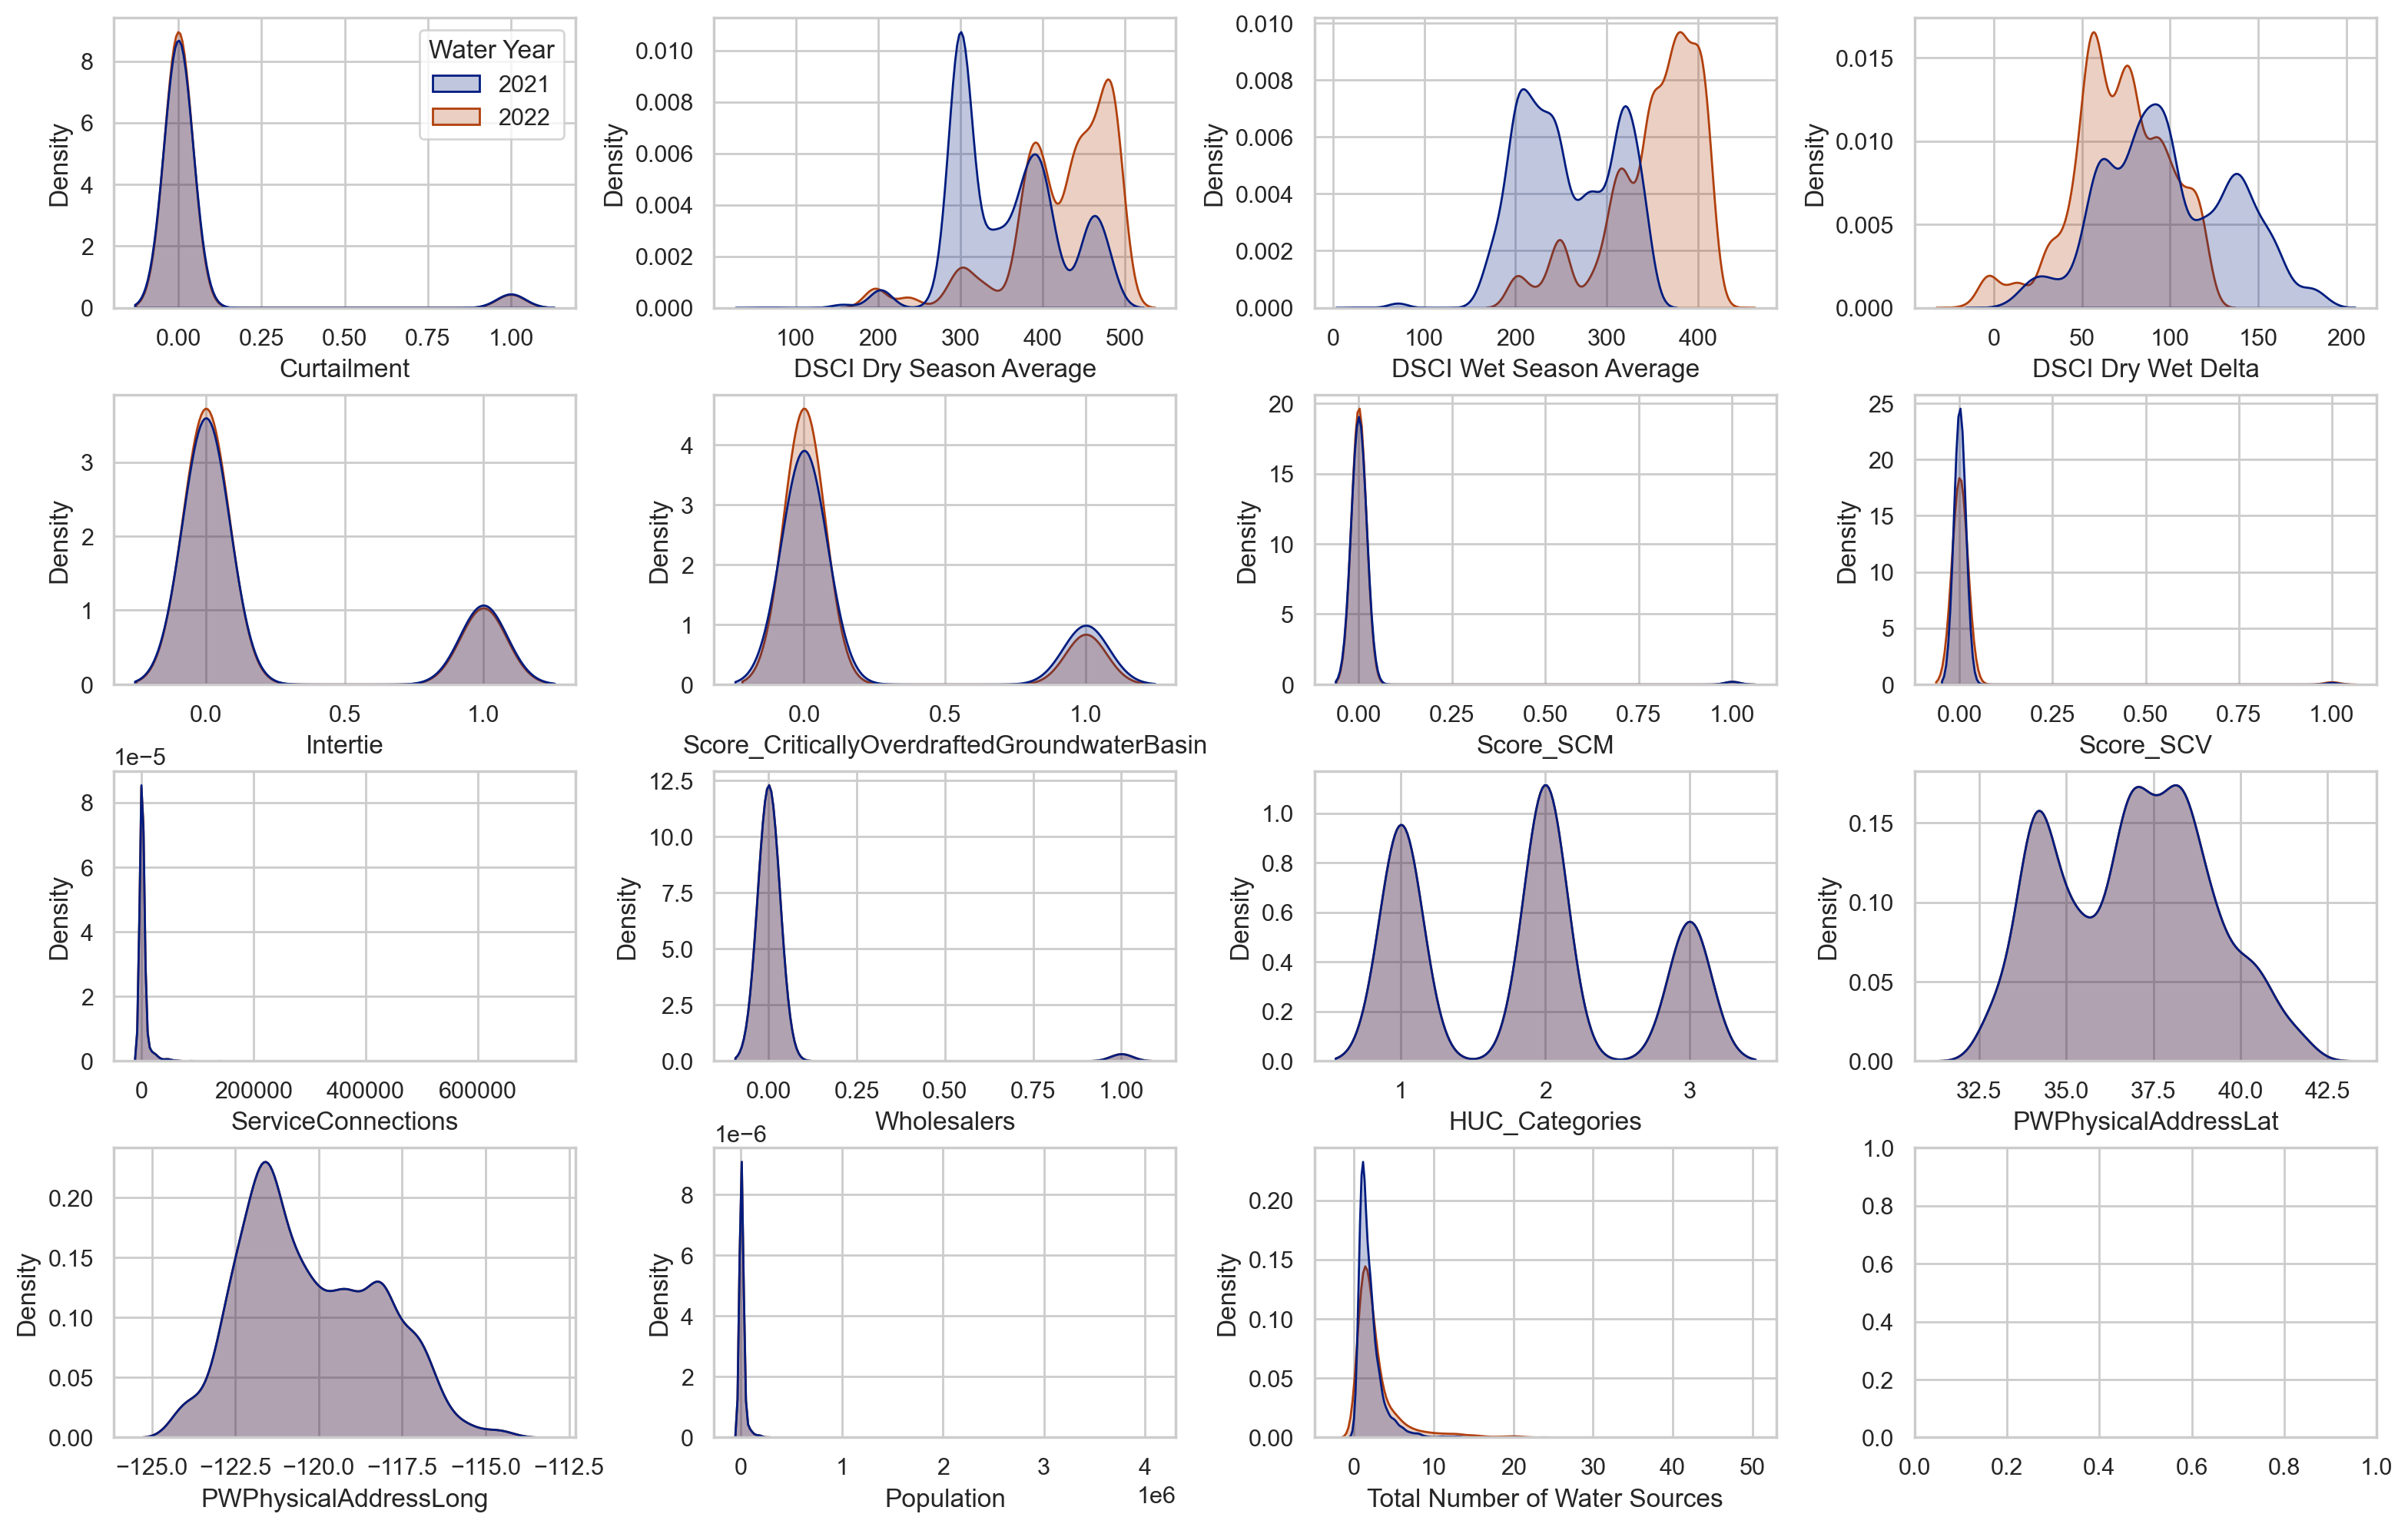

In [134]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(4,4, figsize=(19,12))
sns.kdeplot(df_combined, x='Curtailment', hue='Water Year', fill=True, ax=ax[0,0], legend=True, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Season Average', hue='Water Year', fill=True, ax=ax[0,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='Water Year', fill=True, ax=ax[0,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Wet Delta', hue='Water Year', fill=True, ax=ax[0,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Intertie', hue='Water Year', fill=True, ax=ax[1,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='Water Year', fill=True, ax=ax[1,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCM', hue='Water Year', fill=True, ax=ax[1,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCV', hue='Water Year', fill=True, ax=ax[1,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='ServiceConnections', hue='Water Year', fill=True, ax=ax[2,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Wholesalers', hue='Water Year', fill=True, ax=ax[2,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='HUC_Categories', hue='Water Year', fill=True, ax=ax[2,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLat', hue='Water Year', fill=True, ax=ax[2,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLong', hue='Water Year', fill=True, ax=ax[3,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Population', hue='Water Year', fill=True, ax=ax[3,1], legend=False, palette='dark')
sns.kdeplot(df_combined, x='Total Number of Water Sources', hue='Water Year', fill=True, ax=ax[3,2], legend=False, palette='dark')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('Features_per_WaterYear.png', dpi=300, transparent=True, bbox_inches='tight')

**Thinking about the label**

* `BottledHauledWaterOrZeroSource`: This describes whether a system currently relies on bottled water. 
* `WaterOutageDroughtViolation`: This directly describes whether a system had an outage due to drought.
* `CurtailmentExemptionPetition`: This is a petition to repeal the curtailment and unrelated to drought. The only ones who would appeal a curtailment are those who are already curtailed. `Curtailment` is a feature in the model, and highly correlated with the outcome label `CurtailmentExemptionPrediction`. A curtailment occurs when there is already a problem. According to the [DDW 2022 Water Right Curtailments Fact Sheet](https://www.waterboards.ca.gov/drought/resources-for-water-rights-holders/docs/curtailments-2022.pdf): "State Water Board staff evaluate water availability using current and forecasted hydrologic information, water use data from water right holders, environmental water needs, projected supplies, and more. When that evaluation shows there is not enough water to support all the known needs in a watershed, the State Water Board can send water right holders an order that prohibits water use. These orders are called Curtailment Orders."

<Axes: xlabel='CurtailmentExemptionPetition', ylabel='Density'>

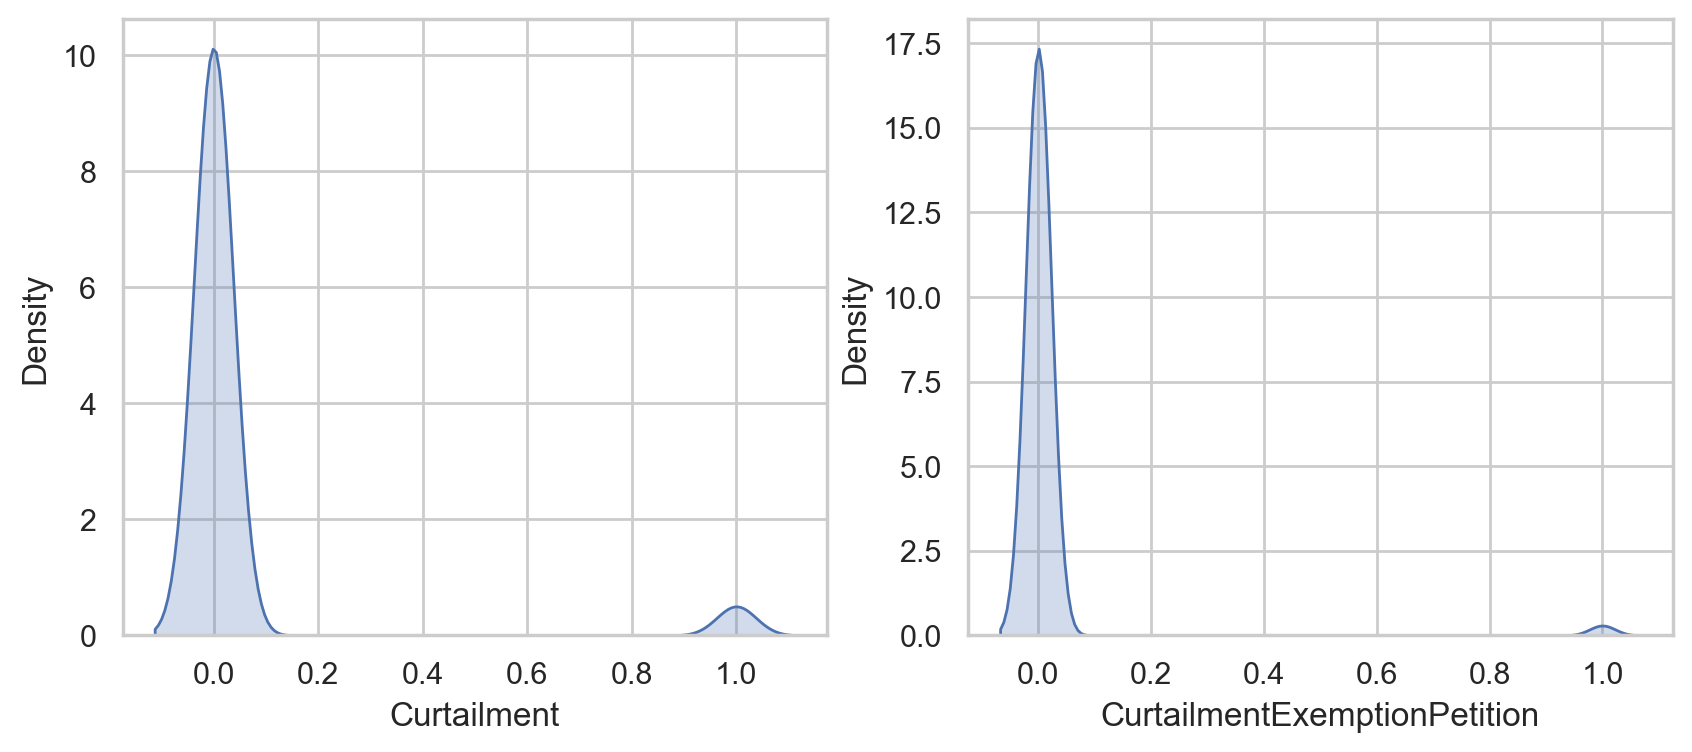

In [135]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.kdeplot(x=df_combined['Curtailment'], fill=True, legend=True, ax=ax[0])
sns.kdeplot(x=df_combined['CurtailmentExemptionPetition'], fill=True, legend=True, ax=ax[1])

In [136]:
print('Number of Curtailments in 2021: ',df_combined[df_combined['Water Year'] == 2021]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2021: ',df_combined[df_combined['Water Year'] == 2021]['CurtailmentExemptionPetition'].value_counts()[1])
print('Number of Curtailments in 2022: ',df_combined[df_combined['Water Year'] == 2022]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2022: ',df_combined[df_combined['Water Year'] == 2022]['CurtailmentExemptionPetition'].value_counts()[1])

Number of Curtailments in 2021:  139
Number of Petitions in 2021:  42
Number of Curtailments in 2022:  131
Number of Petitions in 2022:  53


Are there people who did not experience outages who wanted a petition? No. This is probably because a curtailment is a preventative measure. See:

```python
df_combined[df_combined['CurtailmentExemptionPetition'] == 1][['BottledHauledWaterOrZeroSource', 'WaterOutageDroughtViolation','Curtailment']]
```

Look at the difference in the labels between 2021 and 2022.

In [137]:
print('Year 2021')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2021]['DroughtExperienced'].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values| of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1])

Year 2021
Positive values of DroughtExperienced:  102
Positive values of WaterOutageDroughtViolation:  16
Positive values| of BottledHauledWaterOrZeroSource:  58
Positive values of CurtailmentExemptionPetition:  42


In [138]:
print('Year 2022')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1])

Year 2022
Positive values of DroughtExperienced:  122
Positive values of WaterOutageDroughtViolation:  3
Positive values of BottledHauledWaterOrZeroSource:  66
Positive values of CurtailmentExemptionPetition:  53


In [139]:
total = [
    df_combined[df_combined['Water Year'] == 2021][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1], 
    df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1]]    

year = [2021, 2021, 2021, 2021,
        2022, 2022, 2022, 2022]

labels = ['DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition',
          'DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition']

df_examples = pd.DataFrame(
    {'CWS': total,
     'Year': year,
     'Labels': labels})

Half of the label describes human behavior. We want to identify some empirical relationship between physical measurements -- like temperature, precipitation, and stream flow -- and drought impact. But physical processes cannot model human behavior. Whether someone files a petition for exemption from curtailment is a human behavior, and may not have any relationship with physical processes like the weather. 

<Axes: xlabel='CWS', ylabel='Labels'>

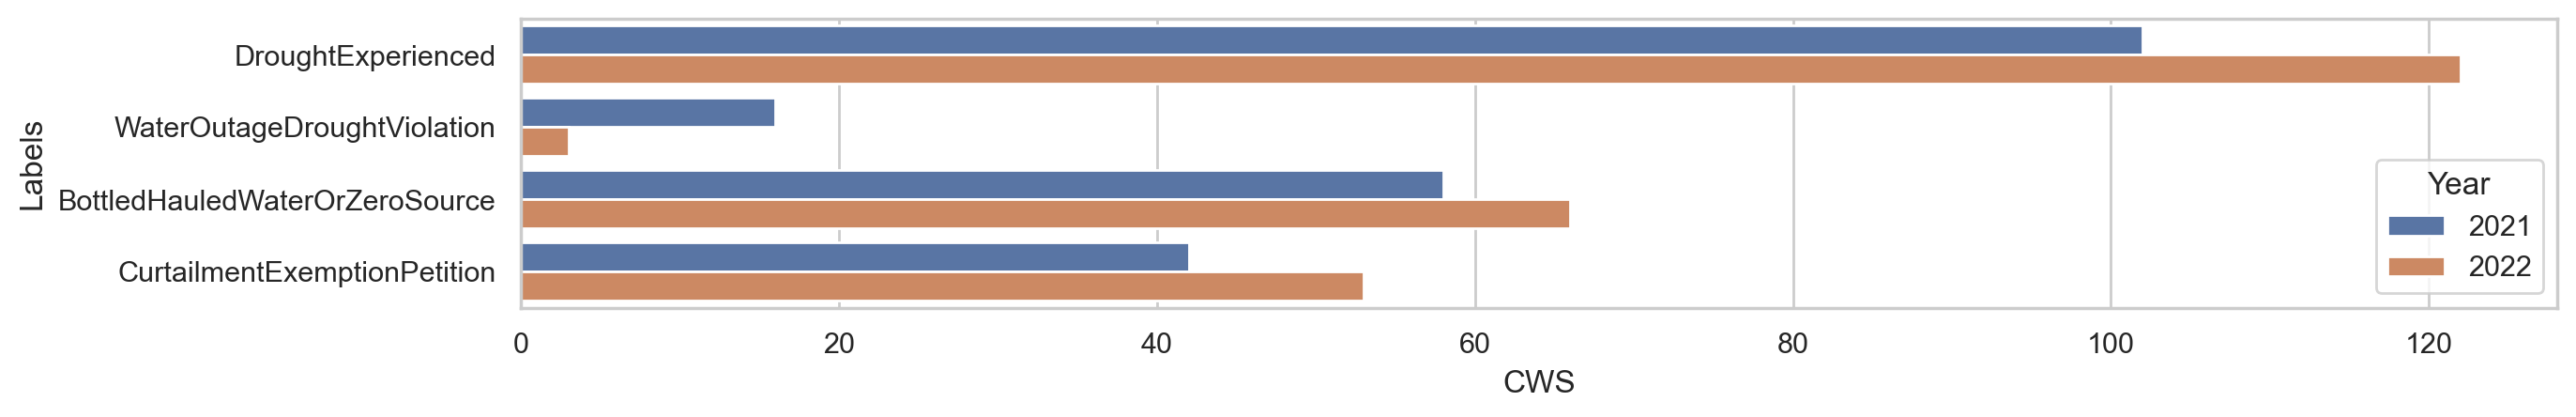

In [140]:
fig, ax = plt.subplots(figsize=(14,2))
sns.set_theme(style='whitegrid')

sns.barplot(orient="h", data=df_examples, x='CWS', y='Labels', hue='Year')
#fig.savefig('outcome.png', dpi=300, transparent=True, bbox_inches='tight')

#### B. Looking at CWS that experienced drought multiple years in a row

In [141]:
print("In 2021, ",df_combined[(df_combined['DroughtExperienced'] == 1) & (df_combined['Water Year'] == 2021)]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  952732 people in California experienced some form of drought.


In [142]:
print("In 2022,",df_combined[(df_combined['DroughtExperienced'] == 1) & (df_combined['Water Year'] == 2022)]['Population'].sum(),"people in California experienced some form of drought.")

In 2022, 1087825 people in California experienced some form of drought.


Most of the CWS experienced drought two years in a row. This means persistence (use of the previous outcome to predict the subsequent outcome) will be a useful feature.

In [143]:
total_CWS = len(df_combined)/2

In [144]:
safe_CWS_2021 = df_combined[(df_combined['DroughtExperienced'] == 0) & (df_combined['Water Year'] == 2021)]
safe_CWS_2022 = df_combined[(df_combined['DroughtExperienced'] == 0) & (df_combined['Water Year'] == 2022)]

In [145]:
number_of_safe_CWS_2021 = len(safe_CWS_2021)
number_of_safe_CWS_2022 = len(safe_CWS_2022)

In [146]:
print('{} CWS, or {:2.2%} of all CWS, experienced no issue in 2021.'.format(number_of_safe_CWS_2021, (number_of_safe_CWS_2021/total_CWS)))
print('{} CWS, or {:2.2%} of all CWS, experienced no issue in 2022.'.format(number_of_safe_CWS_2022, (number_of_safe_CWS_2022/total_CWS)))

2764 CWS, or 96.44% of all CWS, experienced no issue in 2021.
2744 CWS, or 95.74% of all CWS, experienced no issue in 2022.


Look at the breakdown for CWS that experienced drought:

In [147]:
number_of_drought_years = df_combined[(df_combined['DroughtExperienced'] == 1)][['CWSID', 'DroughtExperienced']].groupby('CWSID').sum()

In [148]:
number_of_safe_years = df_combined[(df_combined['DroughtExperienced'] == 0)][['CWSID', 'DroughtExperienced']].groupby('CWSID').sum()

In [149]:
number_of_no_years = len(number_of_safe_years[number_of_safe_years['DroughtExperienced'] == 0])

In [150]:
number_of_single_years = len(number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1])
number_of_repeat_years = len(number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 2])
total_number = len(number_of_drought_years)

Identify the list of CWS that experienced drought in only one year:

In [151]:
list_cws_one_year = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1].index.to_list()

In [152]:
df_cws_one_year = df_combined[df_combined['CWSID'].isin(list_cws_one_year)]

In [153]:
number_cws_2021 = len(df_cws_one_year[(df_cws_one_year['DroughtExperienced'] == 1) & (df_cws_one_year['Water Year'] == 2021)])

In [154]:
list_cws_2021 = df_cws_one_year[(df_cws_one_year['DroughtExperienced'] == 1) & (df_cws_one_year['Water Year'] == 2021)]['CWSID'].to_list()

In [155]:
number_cws_2022 = len(df_cws_one_year[(df_cws_one_year['DroughtExperienced'] == 1) & (df_cws_one_year['Water Year'] == 2022)])

In [156]:
print('{} CWS, or {:2.2%} of all CWS, did not experience drought.'.format(number_of_no_years, (number_of_no_years/total_CWS)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in both years.'.format(number_of_repeat_years, (number_of_repeat_years/total_number)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in only one year.'.format(number_of_single_years, (number_of_single_years/total_number)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in 2021.'.format(number_cws_2021, (number_cws_2021/total_number)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in 2022.'.format(number_cws_2022, (number_cws_2022/total_number)))

2777 CWS, or 96.89% of all CWS, did not experience drought.
89 CWS, or 65.93% of all drought-experienced CWS, experienced drought in both years.
46 CWS, or 34.07% of all drought-experienced CWS, experienced drought in only one year.
13 CWS, or 9.63% of all drought-experienced CWS, experienced drought in 2021.
33 CWS, or 24.44% of all drought-experienced CWS, experienced drought in 2022.


Plot these values.

In [157]:
df_drought_years = pd.DataFrame({'Years of Drought':[0,1,2], 
                                   'CWS':[number_of_no_years, number_of_single_years, number_of_repeat_years]})

[Text(0, 0.5, 'Years of \n Drought')]

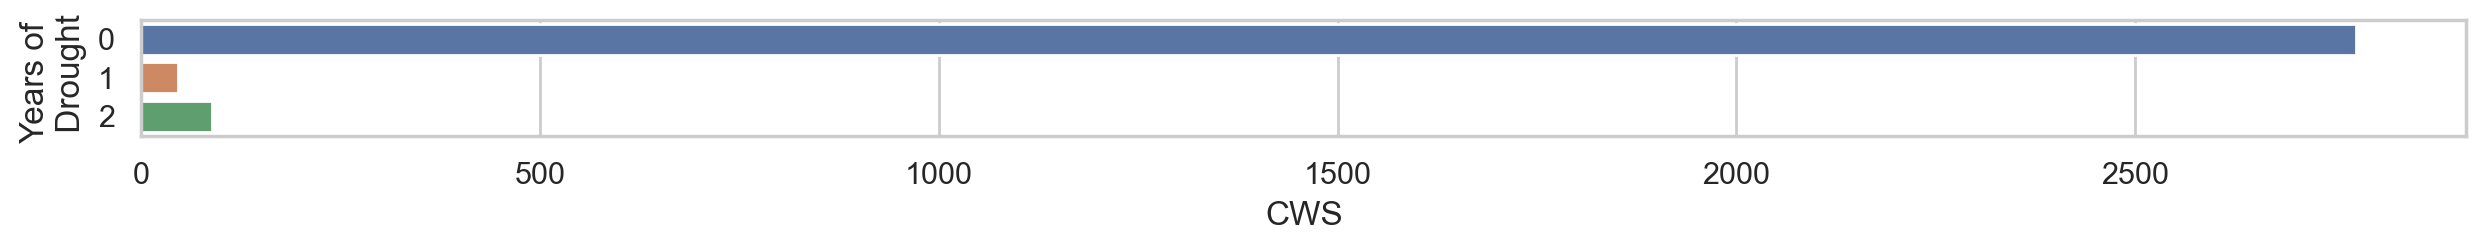

In [158]:
fig, ax = plt.subplots(figsize=(15,0.75))
sns.set_theme(style='whitegrid')
sns.barplot(orient="h", data=df_drought_years, x='CWS', y='Years of Drought')
ax.set(ylabel='Years of \n Drought')
#fig.savefig('droughtyears.png', dpi=300, transparent=True, bbox_inches='tight')

In addition, 28.26% of CWS that experienced drought only once had their experience in 2021. Comparatively, 71.74% of CWS that experienced drought only once had their experience in 2022.

In [159]:
df_single_CWSIDS = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1].merge(df_combined, how='left', on='CWSID').reset_index(drop=True)
df_repeat_CWSIDS = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 2].merge(df_combined, how='left', on='CWSID').reset_index(drop=True)

In [160]:
single_CWSIDS_list = df_single_CWSIDS['CWSID'].to_list()
repeat_CWSIDS_list = df_repeat_CWSIDS['CWSID'].to_list()

In [161]:
single_CWSIDS_index = df_combined[df_combined['CWSID'].isin(single_CWSIDS_list)].index
repeat_CWSIDS_index = df_combined[df_combined['CWSID'].isin(repeat_CWSIDS_list)].index

In [162]:
df_combined['DroughtExperienced Years'] = 0

In [163]:
df_combined.loc[single_CWSIDS_index, ('DroughtExperienced Years')] = 1
df_combined.loc[repeat_CWSIDS_index, ('DroughtExperienced Years')] = 2

Did the CWSIDs that experienced drought in both 2021 and 2022 experience it for the same reason?

There are a couple CWSIDs that experienced a water drought violation in 2021 and then relied on bottled or hauled water in 2022. We also see many CWSIDs that are relying on bottled or hauled water, but do not have a flag for a water outage drought violation. Why is that?

In [164]:
multi_reason_CWSIDS = []

for i in range(len(repeat_CWSIDS_list)):
    df_tmp = df_combined[df_combined['CWSID'] == repeat_CWSIDS_list[i]].reset_index()
    if (df_tmp['BottledHauledWaterOrZeroSource'][0] != df_tmp['BottledHauledWaterOrZeroSource'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])
    if (df_tmp['CurtailmentExemptionPetition'][0] != df_tmp['CurtailmentExemptionPetition'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])
    if (df_tmp['WaterOutageDroughtViolation'][0] != df_tmp['WaterOutageDroughtViolation'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])

In [165]:
print('There are {} CWS that were flagged for different reasons from year to year. {} CWS rest were flagged for the same reason.'.format(len(multi_reason_CWSIDS), len(repeat_CWSIDS_list)/2))

There are 32 CWS that were flagged for different reasons from year to year. 89.0 CWS rest were flagged for the same reason.


Is there any difference between the CWS that are drought-impacted both years, drought-impacted one year, and not drought-impacted?

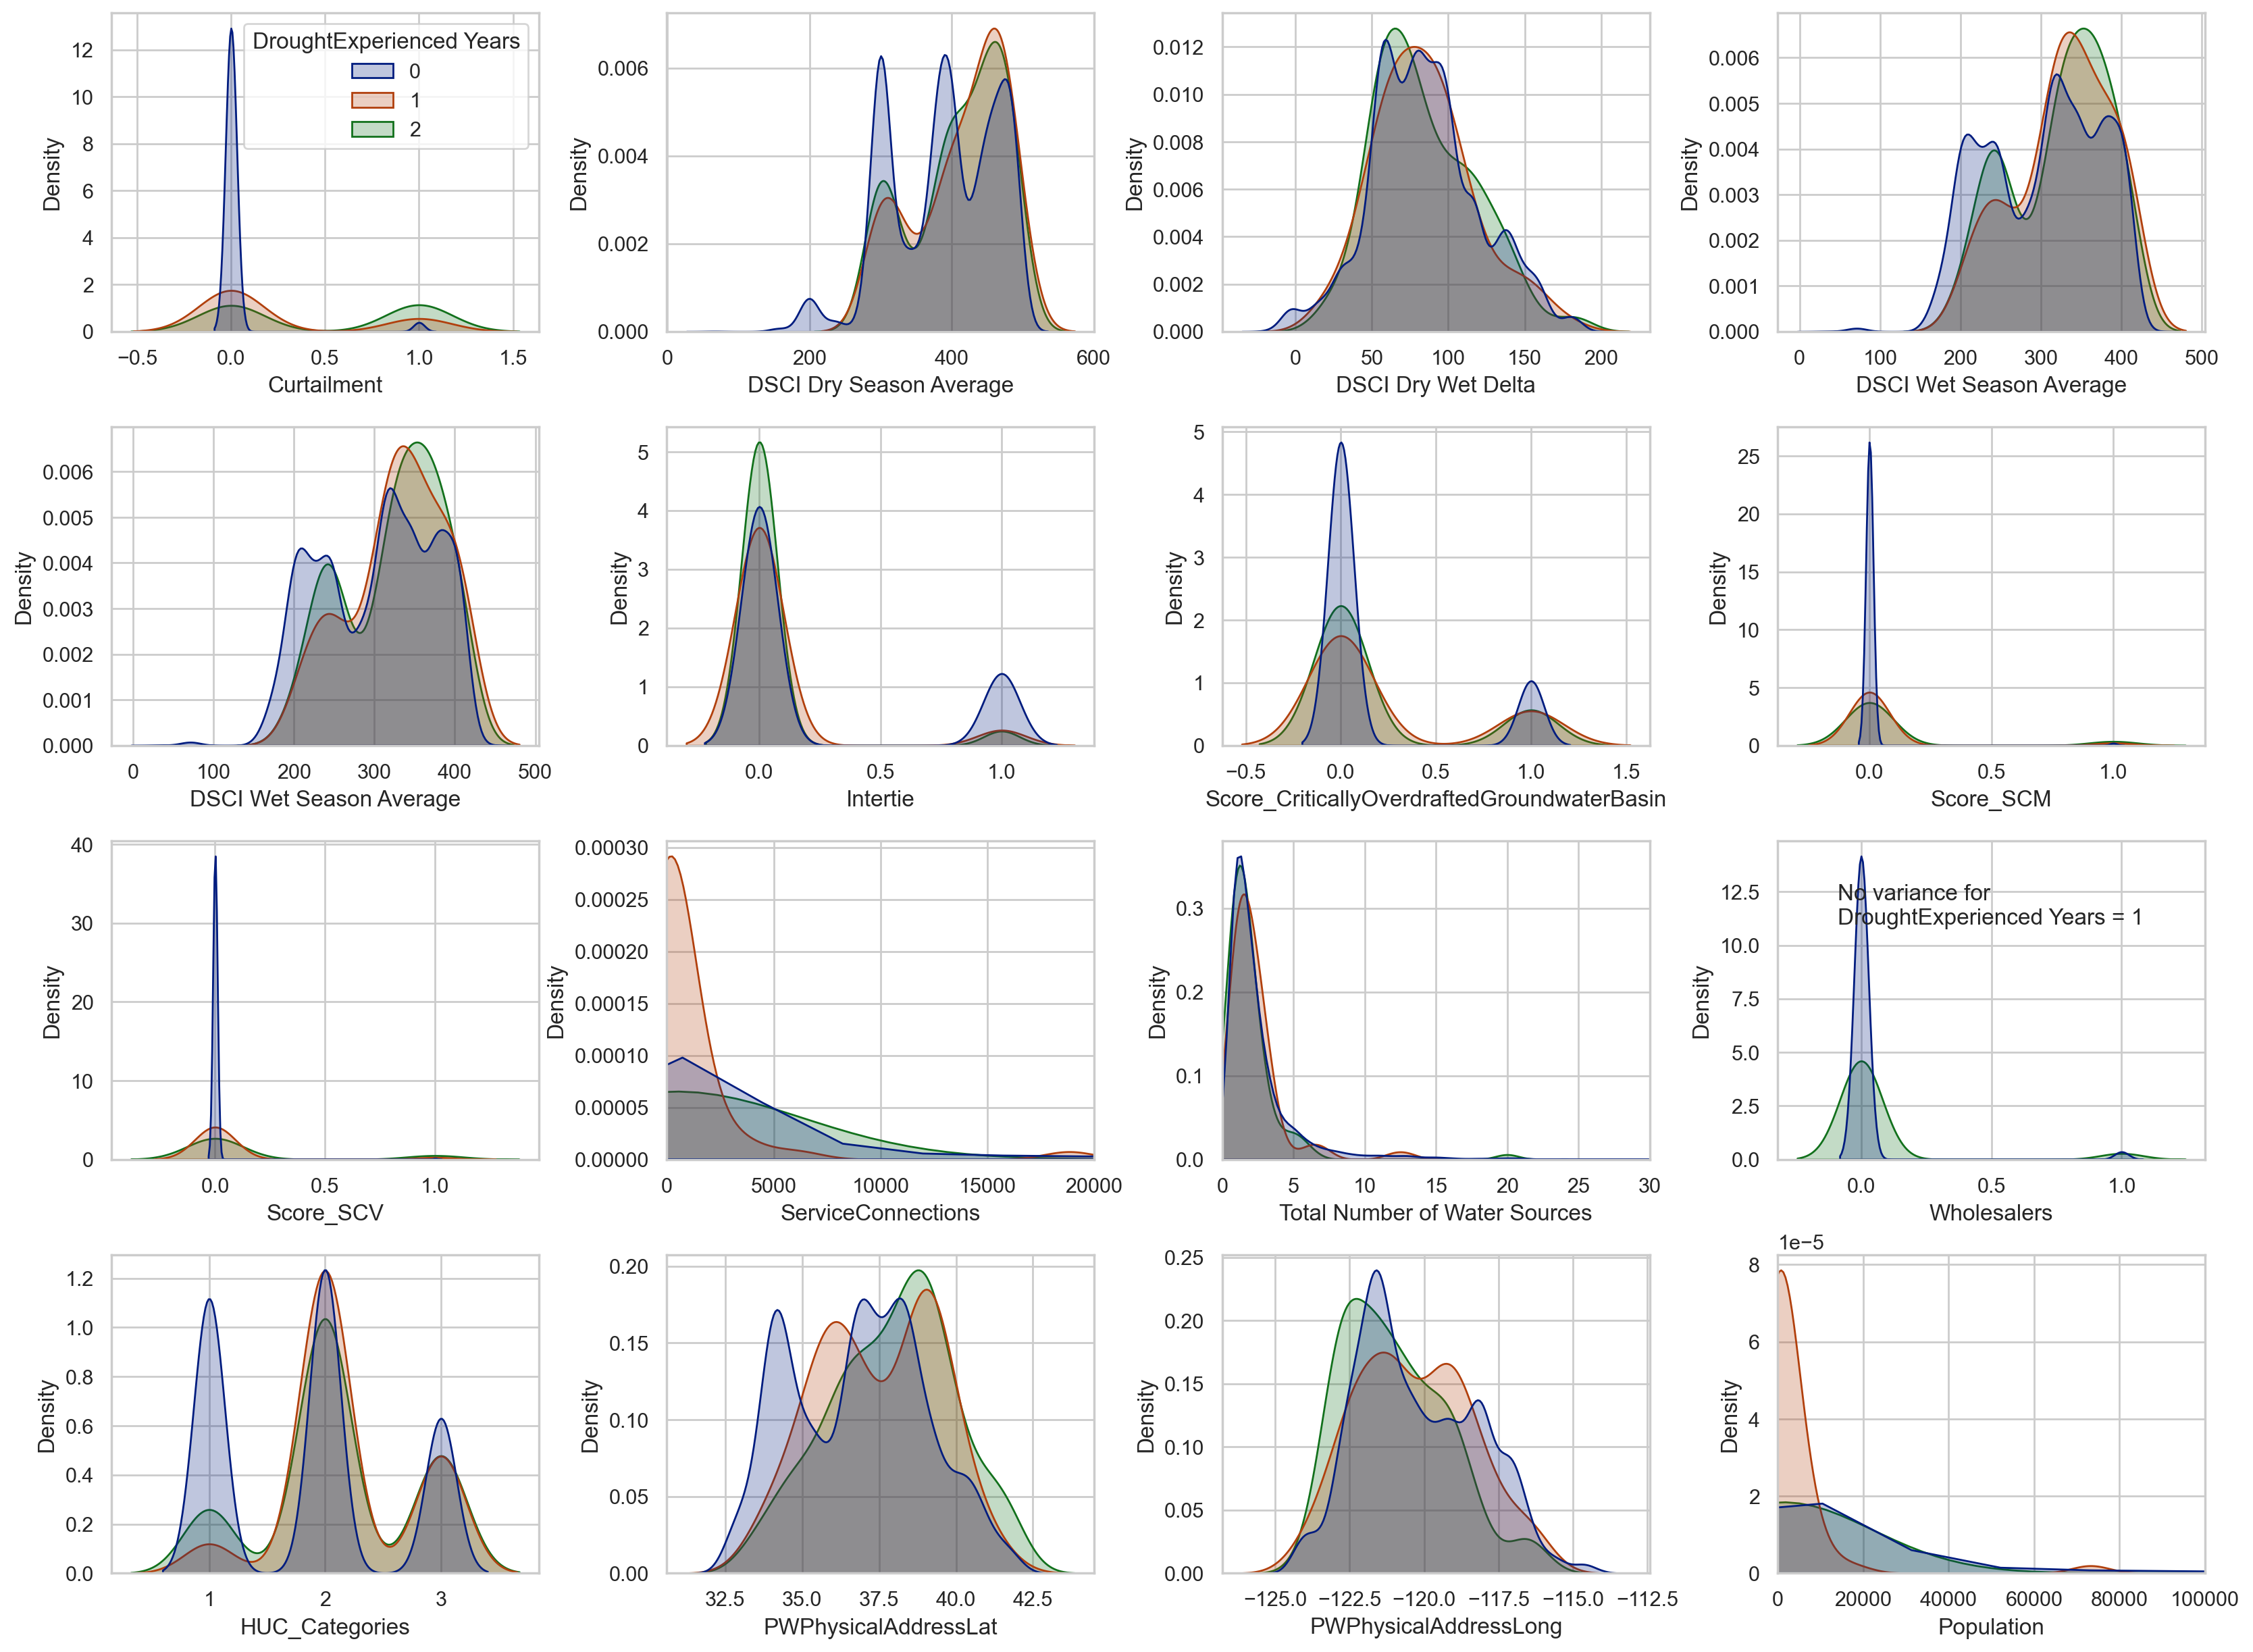

In [166]:
fig, ax = plt.subplots(4,4, figsize=(20,15))
sns.kdeplot(df_combined, x='Curtailment', hue='DroughtExperienced Years', fill=True, ax=ax[0,0], legend=True, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Dry Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[0,1], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Dry Wet Delta', hue='DroughtExperienced Years', fill=True, ax=ax[0,2], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[0,3], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[1,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Intertie', hue='DroughtExperienced Years', fill=True, ax=ax[1,1,], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='DroughtExperienced Years', fill=True, ax=ax[1,2], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Score_SCM', hue='DroughtExperienced Years', fill=True, ax=ax[1,3], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Score_SCV', hue='DroughtExperienced Years', fill=True, ax=ax[2,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='ServiceConnections', hue='DroughtExperienced Years', fill=True, ax=ax[2,1], log_scale=False, legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[2,1].set_xlim([0,20000])
sns.kdeplot(df_combined, x='Total Number of Water Sources', hue='DroughtExperienced Years', fill=True, ax=ax[2,2], log_scale=False, legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[2,2].set_xlim([0,30])
sns.kdeplot(df_combined, x='Wholesalers', hue='DroughtExperienced Years', fill=True, ax=ax[2,3], legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[2,3].annotate('No variance for \nDroughtExperienced Years = 1', xy=(-0.09, 11))
sns.kdeplot(df_combined, x='HUC_Categories', hue='DroughtExperienced Years', fill=True, ax=ax[3,0], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='PWPhysicalAddressLat', hue='DroughtExperienced Years', fill=True, ax=ax[3,1], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='PWPhysicalAddressLong', hue='DroughtExperienced Years', fill=True, ax=ax[3,2], legend=False, common_norm=False, palette='dark', warn_singular=False)
sns.kdeplot(df_combined, x='Population', hue='DroughtExperienced Years', fill=True, ax=ax[3,3], log_scale=False, legend=False, common_norm=False, palette='dark', warn_singular=False)
ax[3,3].set_xlim([0,100000])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('DroughtExperienced_years.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Create a training and validation dataset. 

* We ask the model to learn the relationship between everything that happened in 2021 and the label for 2022. Critically, this means that we treat the outcome, or label, for 2021 as a feature. Therefore, we train the model on 70% of the data from 2021 and 70% of the labels 2022. In addition, we make sure as many HUC8 codes as posible are represented in the training set. Note that there are a dozen HUC8 codes with only one CWS, so these cannot be represented in both samples. To do this, we temporarily add `HUC8`, `CWSID`, `Water Year` to the list of features, so we can stratify this feature across the training and testing sets and verify the results. After that, we will drop these three features from our data.
* We test the model by giving it the remaining 30% of data from 2021 and asking the model to predict the 2022 labels.
* Note that we do not use the 2022 features here. We will use the 2022 features and labels, together with the 2021 features and labels, to predict the 2023 outcome.

In [167]:
temporary_features = ['CWSID', 'Water Year', 'HUC8']

numeric_features = ['ServiceConnections', 'Population',
                    'PWPhysicalAddressLat', 'PWPhysicalAddressLong', 
                    'DSCI Dry Season Average', 'DSCI Wet Season Average',
                    'DSCI Dry Wet Delta', 'Total Number of Water Sources']

categorical_features = ['Score_SCV', 'Score_SCM',
                        'Score_CriticallyOverdraftedGroundwaterBasin',
                        'Intertie', 'Wholesalers',
                        'Curtailment', 'HUC_Categories', 'DroughtExperienced']

temporary_all_features = temporary_features + numeric_features + categorical_features

In [168]:
# Construct all the examples
X = df_combined[temporary_all_features][df_combined['Water Year'] == 2021]

# Construct all the labels
y = df_combined[['CWSID', 'Water Year', 'HUC8', 'DroughtExperienced']][df_combined['Water Year'] == 2022]

Right now there are two flavors of `DroughtExperienced` in the model:
1. The outcome label for 2021, which is a feature, and
2. The outcome label for 2022, which is a label.

To avoid confusion, rename the feature `DroughtExperienced` as `Outcome` and redefine the categorical features to include `Outcome`:

In [169]:
X = X.rename(columns={'DroughtExperienced' : 'Outcome'})

In [170]:
categorical_features = ['Score_SCV', 'Score_SCM',
                        'Score_CriticallyOverdraftedGroundwaterBasin',
                        'Intertie', 'Wholesalers',
                        'Curtailment', 'HUC_Categories', 'Outcome']

Now split the training and validation sets, stratifying by `HUC_Categories`:

In [171]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.36, random_state=77, stratify=X['HUC_Categories'])

In [172]:
print('There are {} positive examples in the training set.'.format(y_train['DroughtExperienced'].value_counts()[1]))
print('There are {} positive examples in the training set.'.format(y_val['DroughtExperienced'].value_counts()[1]))

There are 77 positive examples in the training set.
There are 45 positive examples in the training set.


In [173]:
print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")
print("")
print(f"The entire dataset includes {len(X['HUC8'].unique())} unique HUC8 codes.")
print(f"The training set includes {len(X_train['HUC8'].unique())} unique HUC8 codes.")
print(f"The validation set includes {len(X_val['HUC8'].unique())} unique HUC8 codes.")

The training set is 63.991625959525464% of the data.
The validation set is 36.00837404047453% of the data.

The entire dataset includes 125 unique HUC8 codes.
The training set includes 120 unique HUC8 codes.
The validation set includes 112 unique HUC8 codes.


Reset the indices on the train validation split so that they align nicely.
Note that this means they are decoupled from `df_combined`.

In [174]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

Make a copy of of all these dataframes in order to print the probabilities per CWS.
Then drop the temporary features.

In [175]:
df_X_train = X_train
df_y_train = y_train
df_X_val = X_val
df_y_val = y_val

In [176]:
X_train = X_train.drop(columns=temporary_features)
y_train = y_train.drop(columns=temporary_features)
X_val = X_val.drop(columns=temporary_features)
y_val = y_val.drop(columns=temporary_features)
X = X.drop(columns=temporary_features)
y = y.drop(columns=temporary_features)

Unravel the label

In [177]:
y_val = y_val.values.ravel()
y_train = y_train.values.ravel()
y = y.values.ravel()

### Scale the data

Scale the numeric features assuming the data obey a Gaussian distribution. Leave the categorical features unscaled.

In [178]:
all_features = numeric_features + categorical_features

In [179]:
if (len(numeric_features) + len(categorical_features)) == len(X.columns):
    print('All variables are included.')

All variables are included.


Select and scale the numeric features.

In [180]:
scaler = preprocessing.StandardScaler()

X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

Scale the validation set using the same mean and variance as the training set.

In [181]:
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

Append the unscaled categorical features.

In [182]:
X_train_categorical = np.array(X_train[categorical_features])
X_val_categorical = np.array(X_val[categorical_features])

X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

X_train_scaled.shape, X_val_scaled.shape

((1834, 16), (1032, 16))

In [183]:
X_train.columns

Index(['ServiceConnections', 'Population', 'PWPhysicalAddressLat',
       'PWPhysicalAddressLong', 'DSCI Dry Season Average',
       'DSCI Wet Season Average', 'DSCI Dry Wet Delta',
       'Total Number of Water Sources', 'Score_SCV', 'Score_SCM',
       'Score_CriticallyOverdraftedGroundwaterBasin', 'Intertie',
       'Wholesalers', 'Curtailment', 'HUC_Categories', 'Outcome'],
      dtype='object')

### Train the model

We use a SVM to train and test the model. Note that the class imbalance ratio here is roughly 1:20.
We choose the True Skill Statistic as an validation metric.

In [184]:
# Print the number of examples per label in the training set
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1757,   77]))

In [185]:
# Print the number of examples per label in the validation set
np.unique(y_val, return_counts=True)

(array([0, 1]), array([987,  45]))

In [186]:
# Initialize the model
clf = svm.SVC(gamma='auto', kernel='rbf', C=4.0, class_weight={0:1, 1: 5}, probability=True)

# Fit the model
model = clf.fit(X_train_scaled, y_train)

In [187]:
# Predict the outcome with the best estimator
y_pred = clf.predict(X_val_scaled)
y_pred_probability = clf.predict_proba(X_val_scaled)

Note that using a threshold of 0.5 on `y_predict_probability` will result in 13 false negatives, whereas using `y_pred` will result in 11 false negatives. We choose the first method.

### Question 1: Does the model perform well?

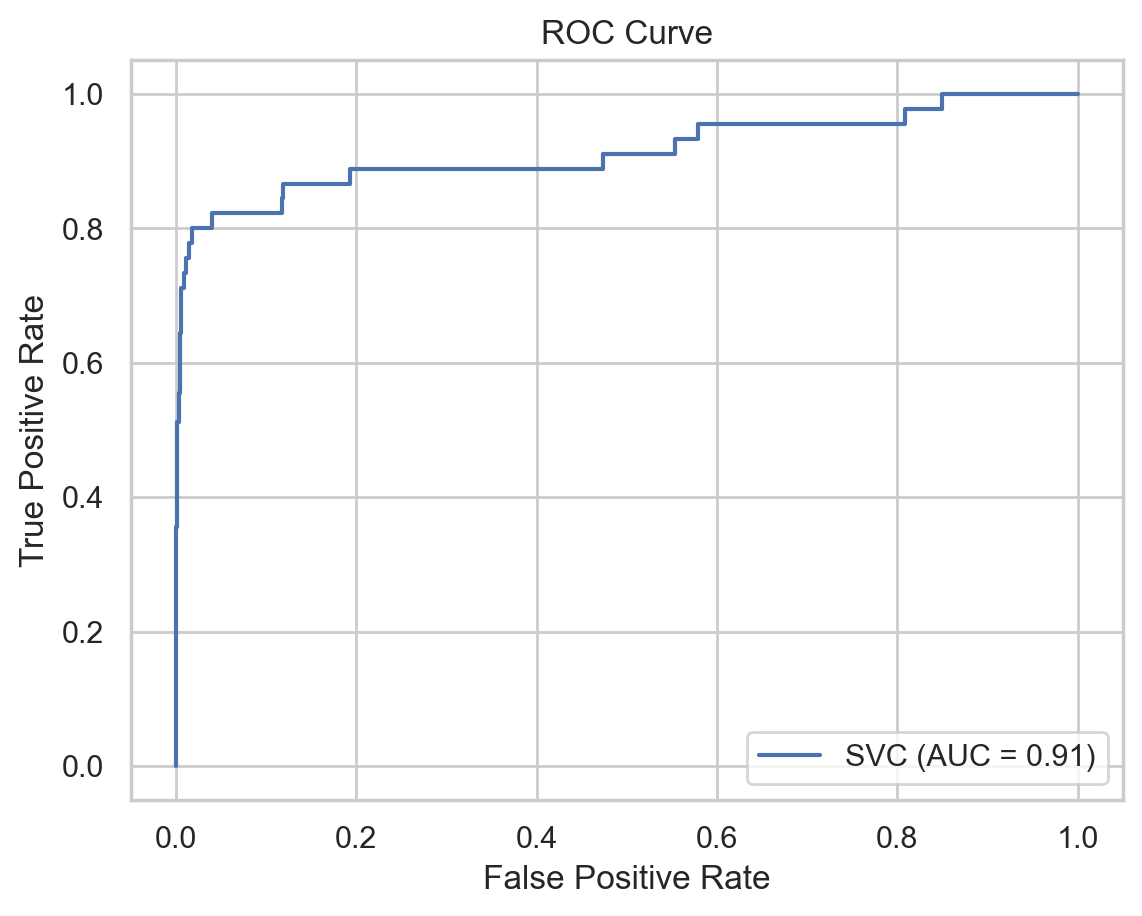

In [188]:
fig, ax = plt.subplots()
rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.show()
#fig.savefig('ROC_AUC.png', dpi=300, transparent=True, bbox_inches='tight')

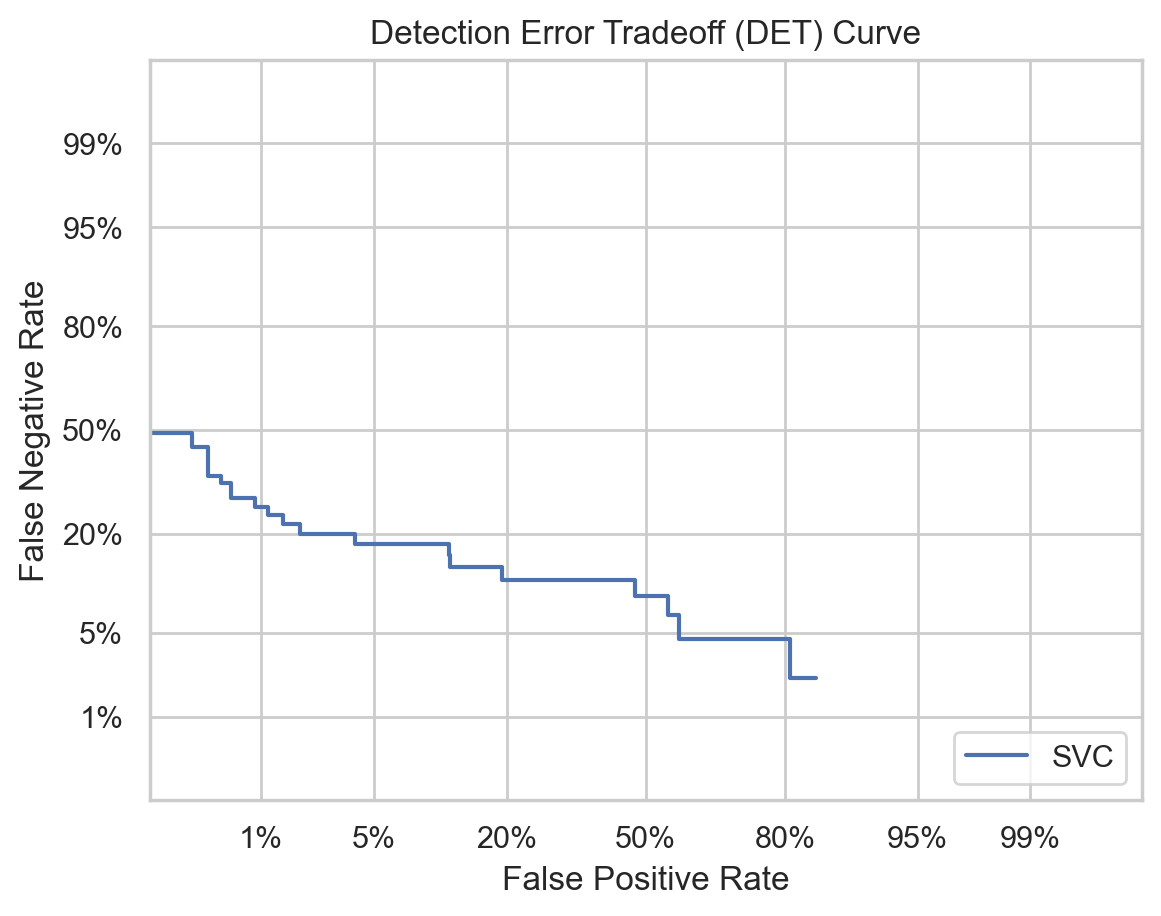

In [189]:
fig, ax = plt.subplots()
rfc_disp = metrics.DetCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('Detection Error Tradeoff (DET) Curve')
plt.show()
#fig.savefig('DET_2022.png', dpi=300, transparent=True, bbox_inches='tight')

Generate a list of the CWS most likely to fail in 2022.

In [190]:
cwsids = []
ground_truth = []
not_expected = []
expected = []
prediction = []

for i in range(len(y_val)):
    cwsids.append(df_y_val[['CWSID']].iloc[i][0])
    ground_truth.append(y_val[i])
    not_expected.append(y_pred_probability[i][0])
    expected.append(y_pred_probability[i][1])
    if (y_pred_probability[i][0] >= 0.5):
        prediction.append('Not Expected')
    if (y_pred_probability[i][1] >= 0.5):
        prediction.append('Expected')

In [191]:
df_predictions_2022 = pd.DataFrame({'CWSID':cwsids, 'Ground Truth':ground_truth, 'Not Expected': not_expected, 'Expected': expected, 'Prediction': prediction})

In [192]:
df_predictions_2022 = df_predictions_2022.sort_values(by=['Expected'], ascending=False).reset_index(drop=True)

In [193]:
df_predictions_2022[0:20]

CWSID  Ground Truth  Not Expected  Expected Prediction
0   CA1710003             1      0.000010  0.999990   Expected
1   CA2910016             1      0.005623  0.994377   Expected
2   CA0410007             1      0.005824  0.994176   Expected
3   CA0901217             1      0.005837  0.994163   Expected
4   CA1700519             1      0.008482  0.991518   Expected
5   CA1700502             1      0.010195  0.989805   Expected
6   CA0300037             1      0.012804  0.987196   Expected
7   CA3301491             1      0.020882  0.979118   Expected
8   CA4900646             1      0.024649  0.975351   Expected
9   CA4300573             1      0.055732  0.944268   Expected
10  CA3500527             1      0.059801  0.940199   Expected
11  CA5400641             1      0.075852  0.924148   Expected
12  CA0400012             1      0.100329  0.899671   Expected
13  CA4810007             1      0.106528  0.893472   Expected
14  CA2300644             1      0.118666  0.881334   Expected
15  CA5400567             1      0.124412  0.875588   Expected
16  CA4700513             0      0.126495  0.873505   Expected
17  CA1000359             1      0.135685  0.864315   Expected
18  CA2700713             1      0.135922  0.864078   Expected
19  CA2000592             1      0.144579  0.855421   Expected

List the false positives and false negatives:

In [194]:
# Set counter
count_false_positive = 0
count_false_negative = 0
index_values = []

for i in range(len(y_val)):
    if ((y_val[i] == 0) and (y_pred_probability[i][0] <= 0.5)):
        count_false_positive += 1
        index_values.append(i)
        print('CWS {}: False Positive. True Value = {}, Probability of 0 = {:2.2%}, Probability of 1 = {:2.2%}.'.format(df_y_val[['CWSID']].iloc[i][0], y_val[i], (y_pred_probability[i][0]), y_pred_probability[i][1]))
    if ((y_val[i] == 1) and (y_pred_probability[i][1] <= 0.5)):
        count_false_negative += 1
        index_values.append(i)
        print('CWS {}: False Negative. True Value = {}, Probability of 0 = {:2.2%}, Probability of 1 = {:2.2%}.'.format(df_y_val[['CWSID']].iloc[i][0], y_val[i], y_pred_probability[i][0], y_pred_probability[i][1]))
print('There were {} false positives.'.format(count_false_positive))
print('There were {} false negatives.'.format(count_false_negative))

# Reset counter
count_false_positive = 0
count_false_negative = 0

CWS CA2310006: False Negative. True Value = 1, Probability of 0 = 84.90%, Probability of 1 = 15.10%.
CWS CA3610125: False Positive. True Value = 0, Probability of 0 = 46.48%, Probability of 1 = 53.52%.
CWS CA4700503: False Negative. True Value = 1, Probability of 0 = 99.49%, Probability of 1 = 0.51%.
CWS CA1500442: False Positive. True Value = 0, Probability of 0 = 21.82%, Probability of 1 = 78.18%.
CWS CA1500458: False Positive. True Value = 0, Probability of 0 = 34.21%, Probability of 1 = 65.79%.
CWS CA4600017: False Negative. True Value = 1, Probability of 0 = 71.60%, Probability of 1 = 28.40%.
CWS CA0910013: False Negative. True Value = 1, Probability of 0 = 89.17%, Probability of 1 = 10.83%.
CWS CA3600114: False Negative. True Value = 1, Probability of 0 = 97.90%, Probability of 1 = 2.10%.
CWS CA1500455: False Positive. True Value = 0, Probability of 0 = 19.23%, Probability of 1 = 80.77%.
CWS CA4900568: False Positive. True Value = 0, Probability of 0 = 16.41%, Probability of 1 = 

In [195]:
df_X_val.iloc[index_values]

CWSID  Water Year      HUC8  ServiceConnections  Population  \
39    CA2310006        2021  18010110              1609.0        5500   
100   CA3610125        2021  18090208              3382.0       12513   
116   CA4700503        2021  18010208                34.0          70   
152   CA1500442        2021  18090206                20.0          37   
226   CA1500458        2021  18030001                24.0          67   
233   CA4600017        2021  18020125               120.0         324   
348   CA0910013        2021  18020128              3733.0        9112   
421   CA3600114        2021  18100201               165.0         695   
435   CA1500455        2021  18090206                16.0          56   
448   CA4900568        2021  18010108                23.0          61   
467   CA4700513        2021  18020154               147.0         280   
546   CA5401003        2021  18030007               103.0         932   
547   CA4400571        2021  18050006               108.0         350   
561   CA4100529        2021  18050006                21.0         186   
649   CA5403144        2021  18030006                13.0          39   
704   CA5400544        2021  18030005               164.0         521   
712   CA3910012        2021  18040003             49167.0      183046   
807   CA2300634        2021  18010108                71.0         250   
999   CA3410020        2021  18020163            142794.0      510931   
1031  CA2000527        2021  18040007                99.0         110   

      PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
39               39.125805            -123.205817               300.000000   
100              34.514030            -117.363240               352.995000   
116              41.309588            -122.801418               400.000000   
152              35.009511            -117.837943               406.360000   
226              35.706896            -118.456197               472.813182   
233              39.574504            -120.615826               307.907273   
348              38.912373            -120.833732               314.318182   
421              34.076247            -116.552461               294.676818   
435              34.941642            -118.254592               406.360000   
448              39.348357            -123.803266               300.000000   
467              40.575264            -122.357484               400.000000   
546              36.548304            -119.262064               468.468636   
547              37.019132            -122.205399               300.000000   
561              37.275809            -122.283000               300.000000   
649              36.211397            -119.260021               459.883636   
704              35.850411            -119.384157               446.157273   
712              37.936480            -121.325984               366.423636   
807              39.490059            -123.782471               300.000000   
999              38.522549            -121.506577               385.502727   
1031             37.328000            -119.649315               475.170000   

      DSCI Wet Season Average  DSCI Dry Wet Delta  \
39                 246.010769           53.989231   
100                287.754615           65.240385   
116                329.102692           70.897308   
152                311.637692           94.722308   
226                293.557692          179.255490   
233                229.781538           78.125734   
348                216.788846           97.529336   
421                252.918462           41.758357   
435                311.637692           94.722308   
448                209.446923           90.553077   
467                338.580000           61.420000   
546                314.529615          153.939021   
547                217.634231           82.365769   
561                217.634231           82.365769   
649                321.320000          138

### Question 2: What does the model get wrong?

Figure out if there are any differences in the distribution of true positives, true negatives, false positives, and false negatives.

In [196]:
def probability_based_confusion_matrix(y_val=y_val, y_pred_probablity=y_pred_probability):
    """
    This function takes in the validation set and the predicted probabilities
    and returns indices of the false positives, false negatives, true positives, and true negatives.

    Parameters:
    y_val: The validation set
    y_pred_probability: The predicted probabilities

    Returns:
    examples_false_positive: The indices of the false positives
    examples_false_negative: The indices of the false negatives
    examples_true_positive: The indices of the true positives
    examples_true_negative: The indices of the true negatives

    Example:
    >>> probability_based_confusion_matrix(y_val, y_pred_probability)
    """
    
    # Set counter
    count_false_positive = 0
    count_false_negative = 0
    count_true_positive = 0
    count_true_negative = 0
    examples_false_positive = []
    examples_false_negative = []
    examples_true_positive = []
    examples_true_negative = []

    for i in range(len(y_val)):
        if ((y_val[i] == 0) and (y_pred_probability[i][0] <= 0.5)):
            count_false_positive += 1
            examples_false_positive.append(i)
        if ((y_val[i] == 1) and (y_pred_probability[i][1] <= 0.5)):
            count_false_negative += 1
            examples_false_negative.append(i)
        if ((y_val[i] == 0) and (y_pred_probability[i][0] >= 0.5)):
            count_true_negative += 1
            examples_true_negative.append(i)
        if ((y_val[i] == 1) and (y_pred_probability[i][1] >= 0.5)):
            count_true_positive += 1
            examples_true_positive.append(i)
    print('There were {} false positives.'.format(count_false_positive))
    print('There were {} false negatives.'.format(count_false_negative))
    print('There were {} true positives.'.format(count_true_positive))
    print('There were {} true negatives.'.format(count_true_negative))

    # Reset counter
    count = 0
    count_false_positive = 0
    count_false_negative = 0
    count_true_positive = 0
    count_true_negative = 0

    return examples_false_positive, examples_false_negative, examples_true_positive, examples_true_negative

In [197]:
examples_false_positive, examples_false_negative, examples_true_positive, examples_true_negative = probability_based_confusion_matrix(y_val=y_val, y_pred_probablity=y_pred_probability)

There were 7 false positives.
There were 13 false negatives.
There were 32 true positives.
There were 980 true negatives.


In [198]:
df_false_positives = df_X_val.loc[examples_false_positive].reset_index(drop=True).assign(Classification='False Positive')
df_false_negatives = df_X_val.loc[examples_false_negative].reset_index(drop=True).assign(Classification='False Negative')
df_true_positives = df_X_val.loc[examples_true_positive].reset_index(drop=True).assign(Classification='True Positive')
df_true_negatives = df_X_val.loc[examples_true_negative].reset_index(drop=True).assign(Classification='True Negative')

In [199]:
frames = [df_false_positives, df_false_negatives, df_true_positives, df_true_negatives]
df_all = pd.concat(frames)

In [200]:
# Replace populations of 0 with 0.1 to account for the log plot
df_all['Population'] = df_all['Population'].replace(0, 0.1)

In [201]:
# Replace service connections of 0 with 0.1 to account for the log plot
df_all['ServiceConnections'] = df_all['ServiceConnections'].replace(0, 0.1)

Look at the false negatives:

In [202]:
df_all[df_all['Classification'] == 'False Negative']

CWSID  Water Year      HUC8  ServiceConnections  Population  \
0   CA2310006        2021  18010110              1609.0      5500.0   
1   CA4700503        2021  18010208                34.0        70.0   
2   CA4600017        2021  18020125               120.0       324.0   
3   CA0910013        2021  18020128              3733.0      9112.0   
4   CA3600114        2021  18100201               165.0       695.0   
5   CA5401003        2021  18030007               103.0       932.0   
6   CA4400571        2021  18050006               108.0       350.0   
7   CA5403144        2021  18030006                13.0        39.0   
8   CA5400544        2021  18030005               164.0       521.0   
9   CA3910012        2021  18040003             49167.0    183046.0   
10  CA2300634        2021  18010108                71.0       250.0   
11  CA3410020        2021  18020163            142794.0    510931.0   
12  CA2000527        2021  18040007                99.0       110.0   

    PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
0              39.125805            -123.205817               300.000000   
1              41.309588            -122.801418               400.000000   
2              39.574504            -120.615826               307.907273   
3              38.912373            -120.833732               314.318182   
4              34.076247            -116.552461               294.676818   
5              36.548304            -119.262064               468.468636   
6              37.019132            -122.205399               300.000000   
7              36.211397            -119.260021               459.883636   
8              35.850411            -119.384157               446.157273   
9              37.936480            -121.325984               366.423636   
10             39.490059            -123.782471               300.000000   
11             38.522549            -121.506577               385.502727   
12             37.328000            -119.649315               475.170000   

    DSCI Wet Season Average  DSCI Dry Wet Delta  \
0                246.010769           53.989231   
1                329.102692           70.897308   
2                229.781538           78.125734   
3                216.788846           97.529336   
4                252.918462           41.758357   
5                314.529615          153.939021   
6                217.634231           82.365769   
7                321.320000          138.563636   
8                330.364615          115.792657   
9                277.444615           88.979021   
10               209.446923           90.553077   
11               302.060769           83.441958   
12               314.201154          160.968846   

    Total Number of Water Sources  Score_SCV  Score_SCM  \
0                            20.0        0.0        0.0   
1                             1.0        0.0        1.0   
2                             2.0        0.0        0.0   
3                             1.0        0.0        0.0   
4                             2.0        0.0        0.0   
5                             2.0        0.0        0.0   
6                             2.0        0.0        0.0   
7                             1.0        0.0        0.0   
8                             2.0        0.0        0.0   
9                             1.0        0.0        0.0   
10                            3.0        0.0        0.0   
11                            1.0        0.0        0.0   
12                            4.0        0.0        0.0   

    Score_CriticallyOverdraftedGroundwaterBasin  Intertie  Wholesalers  \
0                                             0       0.0          0.0   
1                                             0       0.0          0.0   
2                                             0       0.0          0.0   
3                                             0       0.0          0.0   
4                                   

Are these 13 false negatives the same ones that experienced drought in only 2021? No.

In [203]:
df_all[df_all['Classification'] == 'False Negative']['CWSID'].isin(list_cws_2021)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
Name: CWSID, dtype: bool

Look at the false positives:

In [204]:
df_all[df_all['Classification'] == 'False Positive']

CWSID  Water Year      HUC8  ServiceConnections  Population  \
0  CA3610125        2021  18090208              3382.0     12513.0   
1  CA1500442        2021  18090206                20.0        37.0   
2  CA1500458        2021  18030001                24.0        67.0   
3  CA1500455        2021  18090206                16.0        56.0   
4  CA4900568        2021  18010108                23.0        61.0   
5  CA4700513        2021  18020154               147.0       280.0   
6  CA4100529        2021  18050006                21.0       186.0   

   PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
0             34.514030            -117.363240               352.995000   
1             35.009511            -117.837943               406.360000   
2             35.706896            -118.456197               472.813182   
3             34.941642            -118.254592               406.360000   
4             39.348357            -123.803266               300.000000   
5             40.575264            -122.357484               400.000000   
6             37.275809            -122.283000               300.000000   

   DSCI Wet Season Average  DSCI Dry Wet Delta  Total Number of Water Sources  \
0               287.754615           65.240385                            1.0   
1               311.637692           94.722308                            1.0   
2               293.557692          179.255490                            1.0   
3               311.637692           94.722308                            1.0   
4               209.446923           90.553077                            3.0   
5               338.580000           61.420000                            3.0   
6               217.634231           82.365769                            1.0   

   Score_SCV  Score_SCM  Score_CriticallyOverdraftedGroundwaterBasin  \
0        0.0        1.0                                            0   
1        0.0        0.0                                            0   
2        0.0        0.0                                            0   
3        0.0        0.0                                            0   
4        0.0        0.0                                            0   
5        1.0        0.0                                            0   
6        0.0        0.0                                            0   

   Intertie  Wholesalers  Curtailment  HUC_Categories  Outcome  Classification  
0       0.0          0.0            0               3        0  False Positive  
1       0.0          0.0            0               3        1  False Positive  
2       0.0          0.0            0               2        1  False Positive  
3       0.0          0.0            0               3        1  False Positive  
4       0.0          0.0            0               3        1  False Positive  
5       0.0          0.0            0               2        1  False Positive  
6       0.0          0.0            0               1        1  False Positive

Are these 6 false negatives among those that experienced drought only in 2022? Yes.

In [205]:
df_all[df_all['Classification'] == 'False Positive']['CWSID'].isin(list_cws_2021)

0    False
1     True
2     True
3     True
4     True
5     True
6     True
Name: CWSID, dtype: bool

Plot all of the features per classification type:

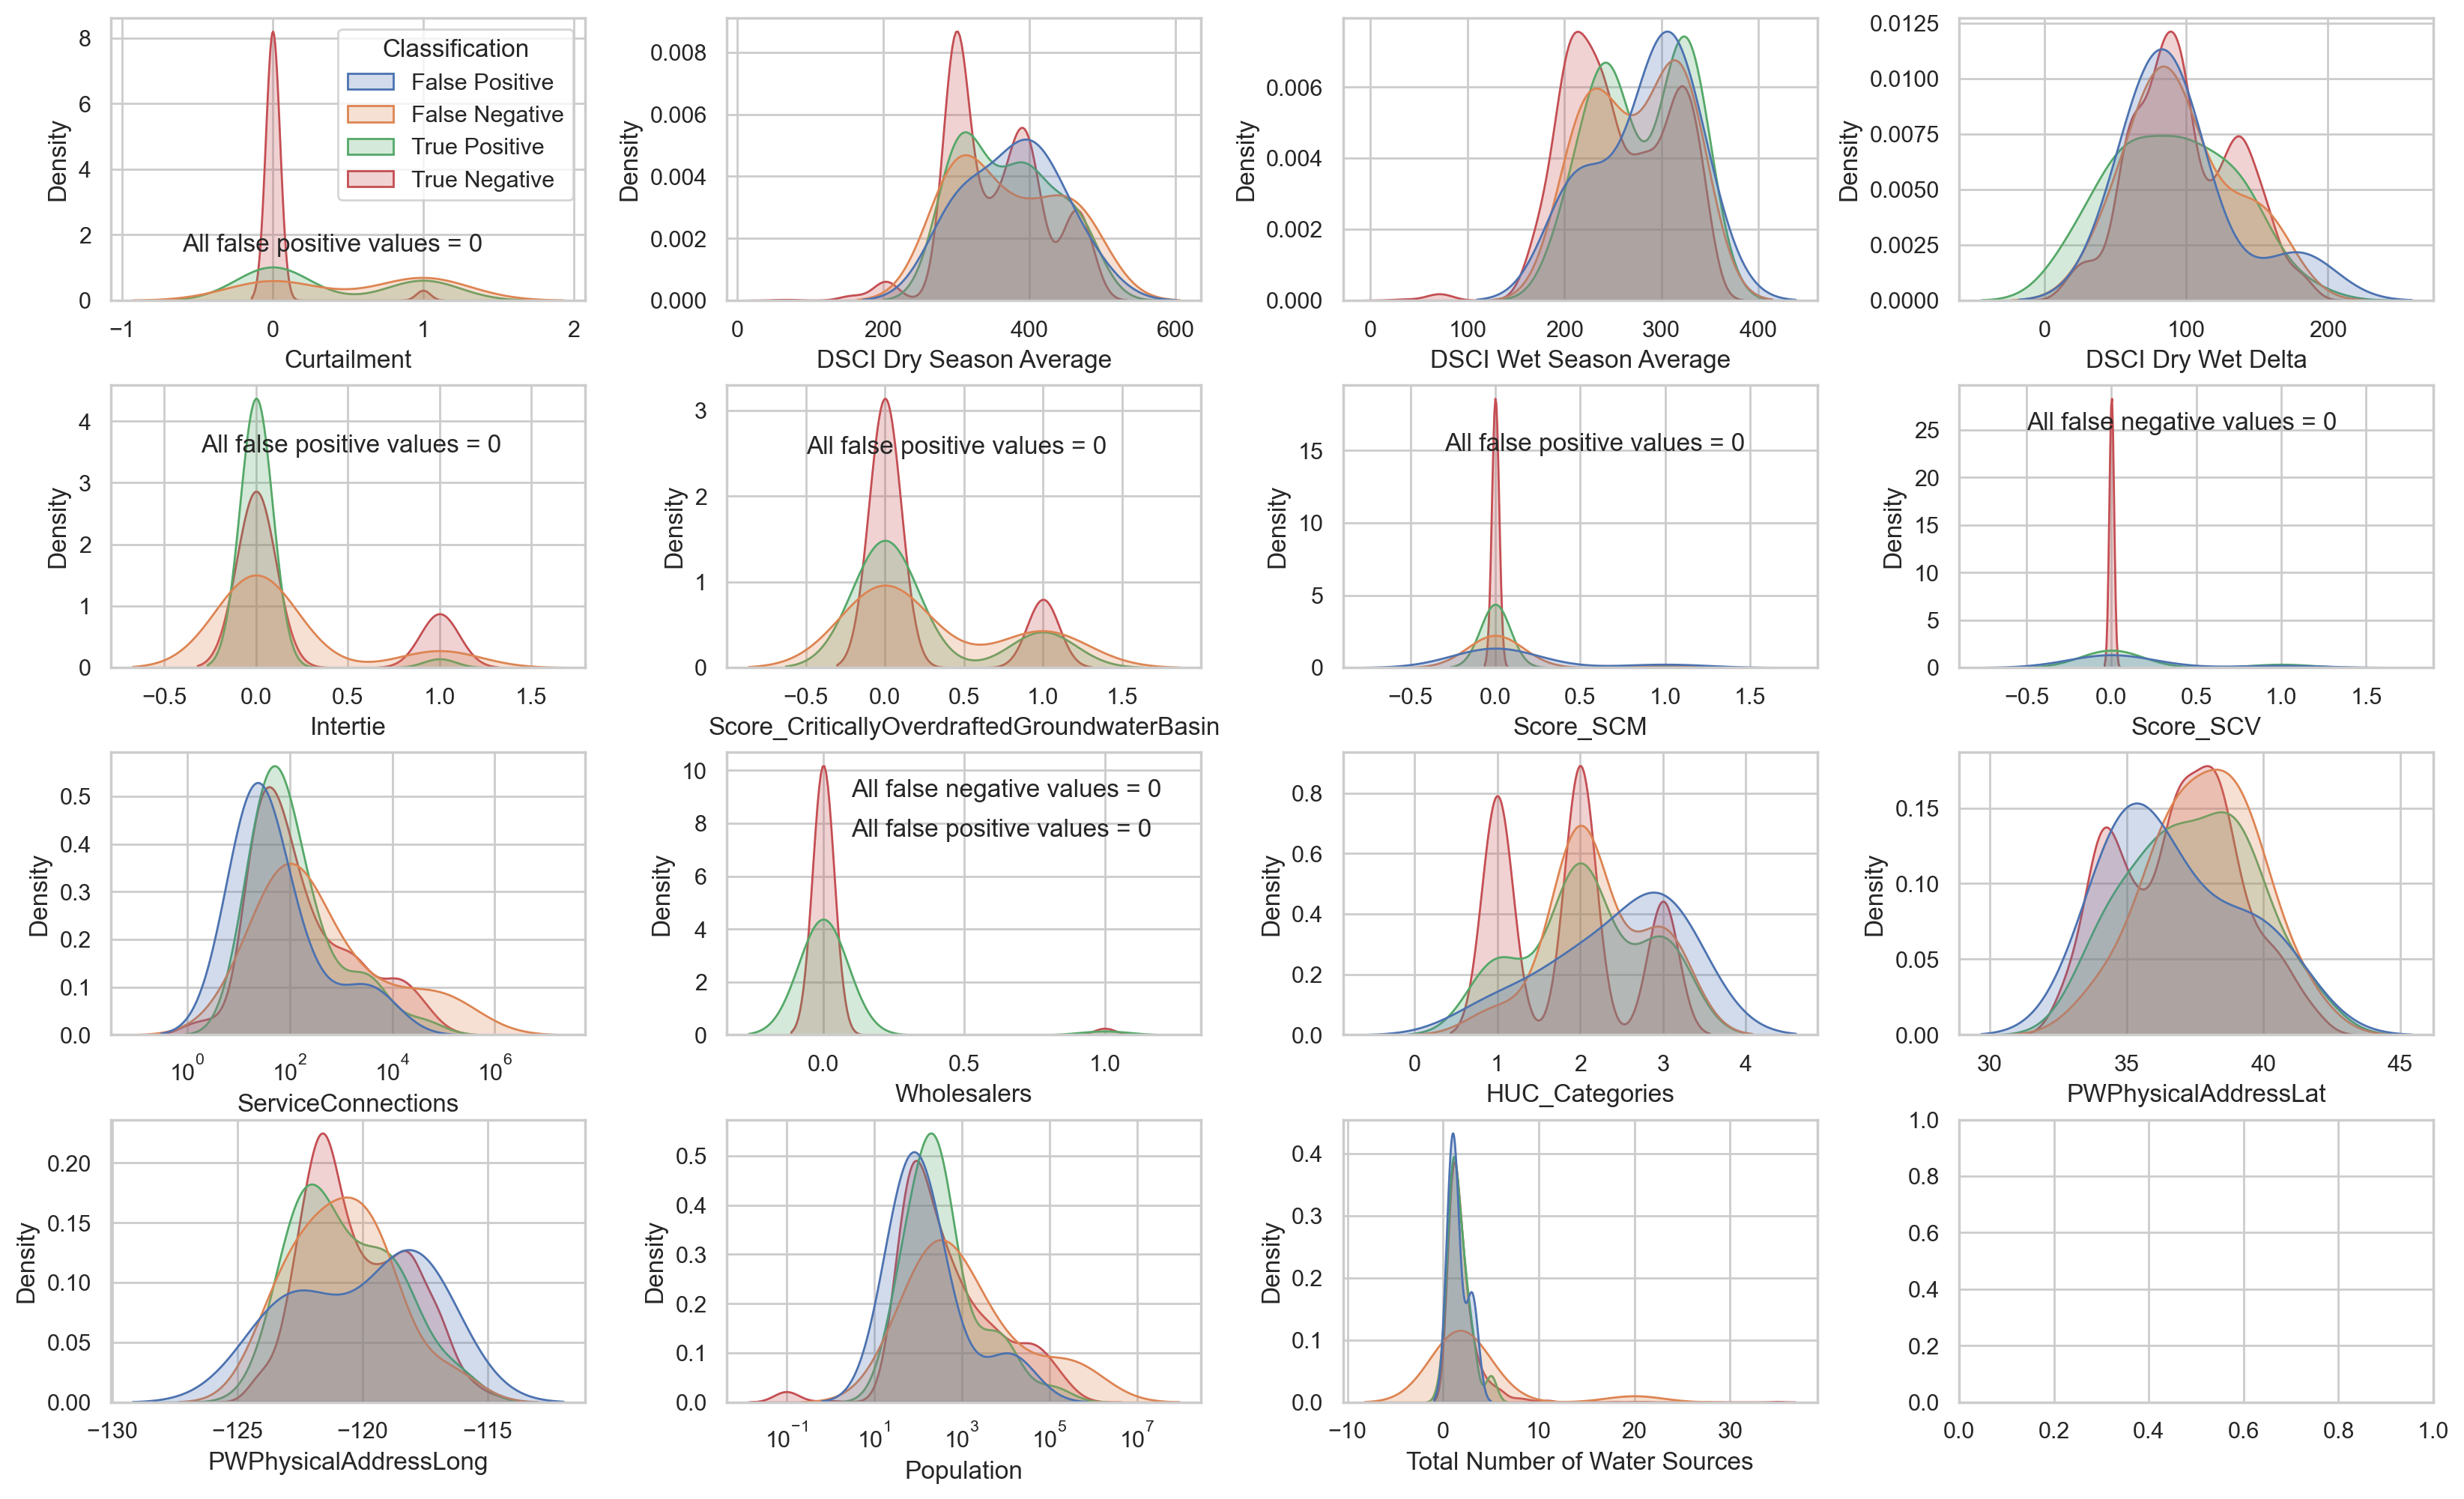

In [206]:
fig, ax = plt.subplots(4,4, figsize=(20,12))
sns.kdeplot(df_all, x='Curtailment', hue='Classification', fill=True, ax=ax[0,0], legend=True, common_norm=False, warn_singular=False)
ax[0,0].annotate('All false positive values = 0', xy=(-0.6, 1.5))
sns.kdeplot(df_all, x='DSCI Dry Season Average', hue='Classification', fill=True, ax=ax[0,1], legend=False, common_norm=False)
sns.kdeplot(df_all, x='DSCI Wet Season Average', hue='Classification', fill=True, ax=ax[0,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='DSCI Dry Wet Delta', hue='Classification', fill=True, ax=ax[0,3], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Intertie', hue='Classification', fill=True, ax=ax[1,0], legend=False, common_norm=False, warn_singular=False)
ax[1,0].annotate('All false positive values = 0', xy=(-0.3, 3.5))
sns.kdeplot(df_all, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='Classification', fill=True, ax=ax[1,1], legend=False, common_norm=False, warn_singular=False)
ax[1,1].annotate('All false positive values = 0', xy=(-0.5, 2.5))
sns.kdeplot(df_all, x='Score_SCM', hue='Classification', fill=True, ax=ax[1,2], legend=False, common_norm=False, warn_singular=False)
ax[1,2].annotate('All false positive values = 0', xy=(-0.3, 15.0))
sns.kdeplot(df_all, x='Score_SCV', hue='Classification', fill=True, ax=ax[1,3], legend=False, common_norm=False, warn_singular=False)
ax[1,3].annotate('All false negative values = 0', xy=(-0.5, 25.0))
sns.kdeplot(df_all, x='ServiceConnections', hue='Classification', fill=True, ax=ax[2,0], log_scale=True, legend=False, common_norm=False)
sns.kdeplot(df_all, x='Wholesalers', hue='Classification', fill=True, ax=ax[2,1], legend=False, common_norm=False, warn_singular=False)
ax[2,1].annotate('All false positive values = 0', xy=(0.1, 7.5))
ax[2,1].annotate('All false negative values = 0', xy=(0.1, 9.0))
sns.kdeplot(df_all, x='HUC_Categories', hue='Classification', fill=True, ax=ax[2,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='PWPhysicalAddressLat', hue='Classification', fill=True, ax=ax[2,3], legend=False, common_norm=False)
sns.kdeplot(df_all, x='PWPhysicalAddressLong', hue='Classification', fill=True, ax=ax[3,0], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Population', hue='Classification', fill=True, ax=ax[3,1], legend=False, log_scale=True, common_norm=False)
sns.kdeplot(df_all, x='Total Number of Water Sources', hue='Classification', fill=True, ax=ax[3,2], legend=False, common_norm=False)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('Misclassifications_2022.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 3: What are the most predictive features?

We assess predictive capacity based the Univariate F Score.

[Text(0.5, 0, 'Normalized Fisher Score')]

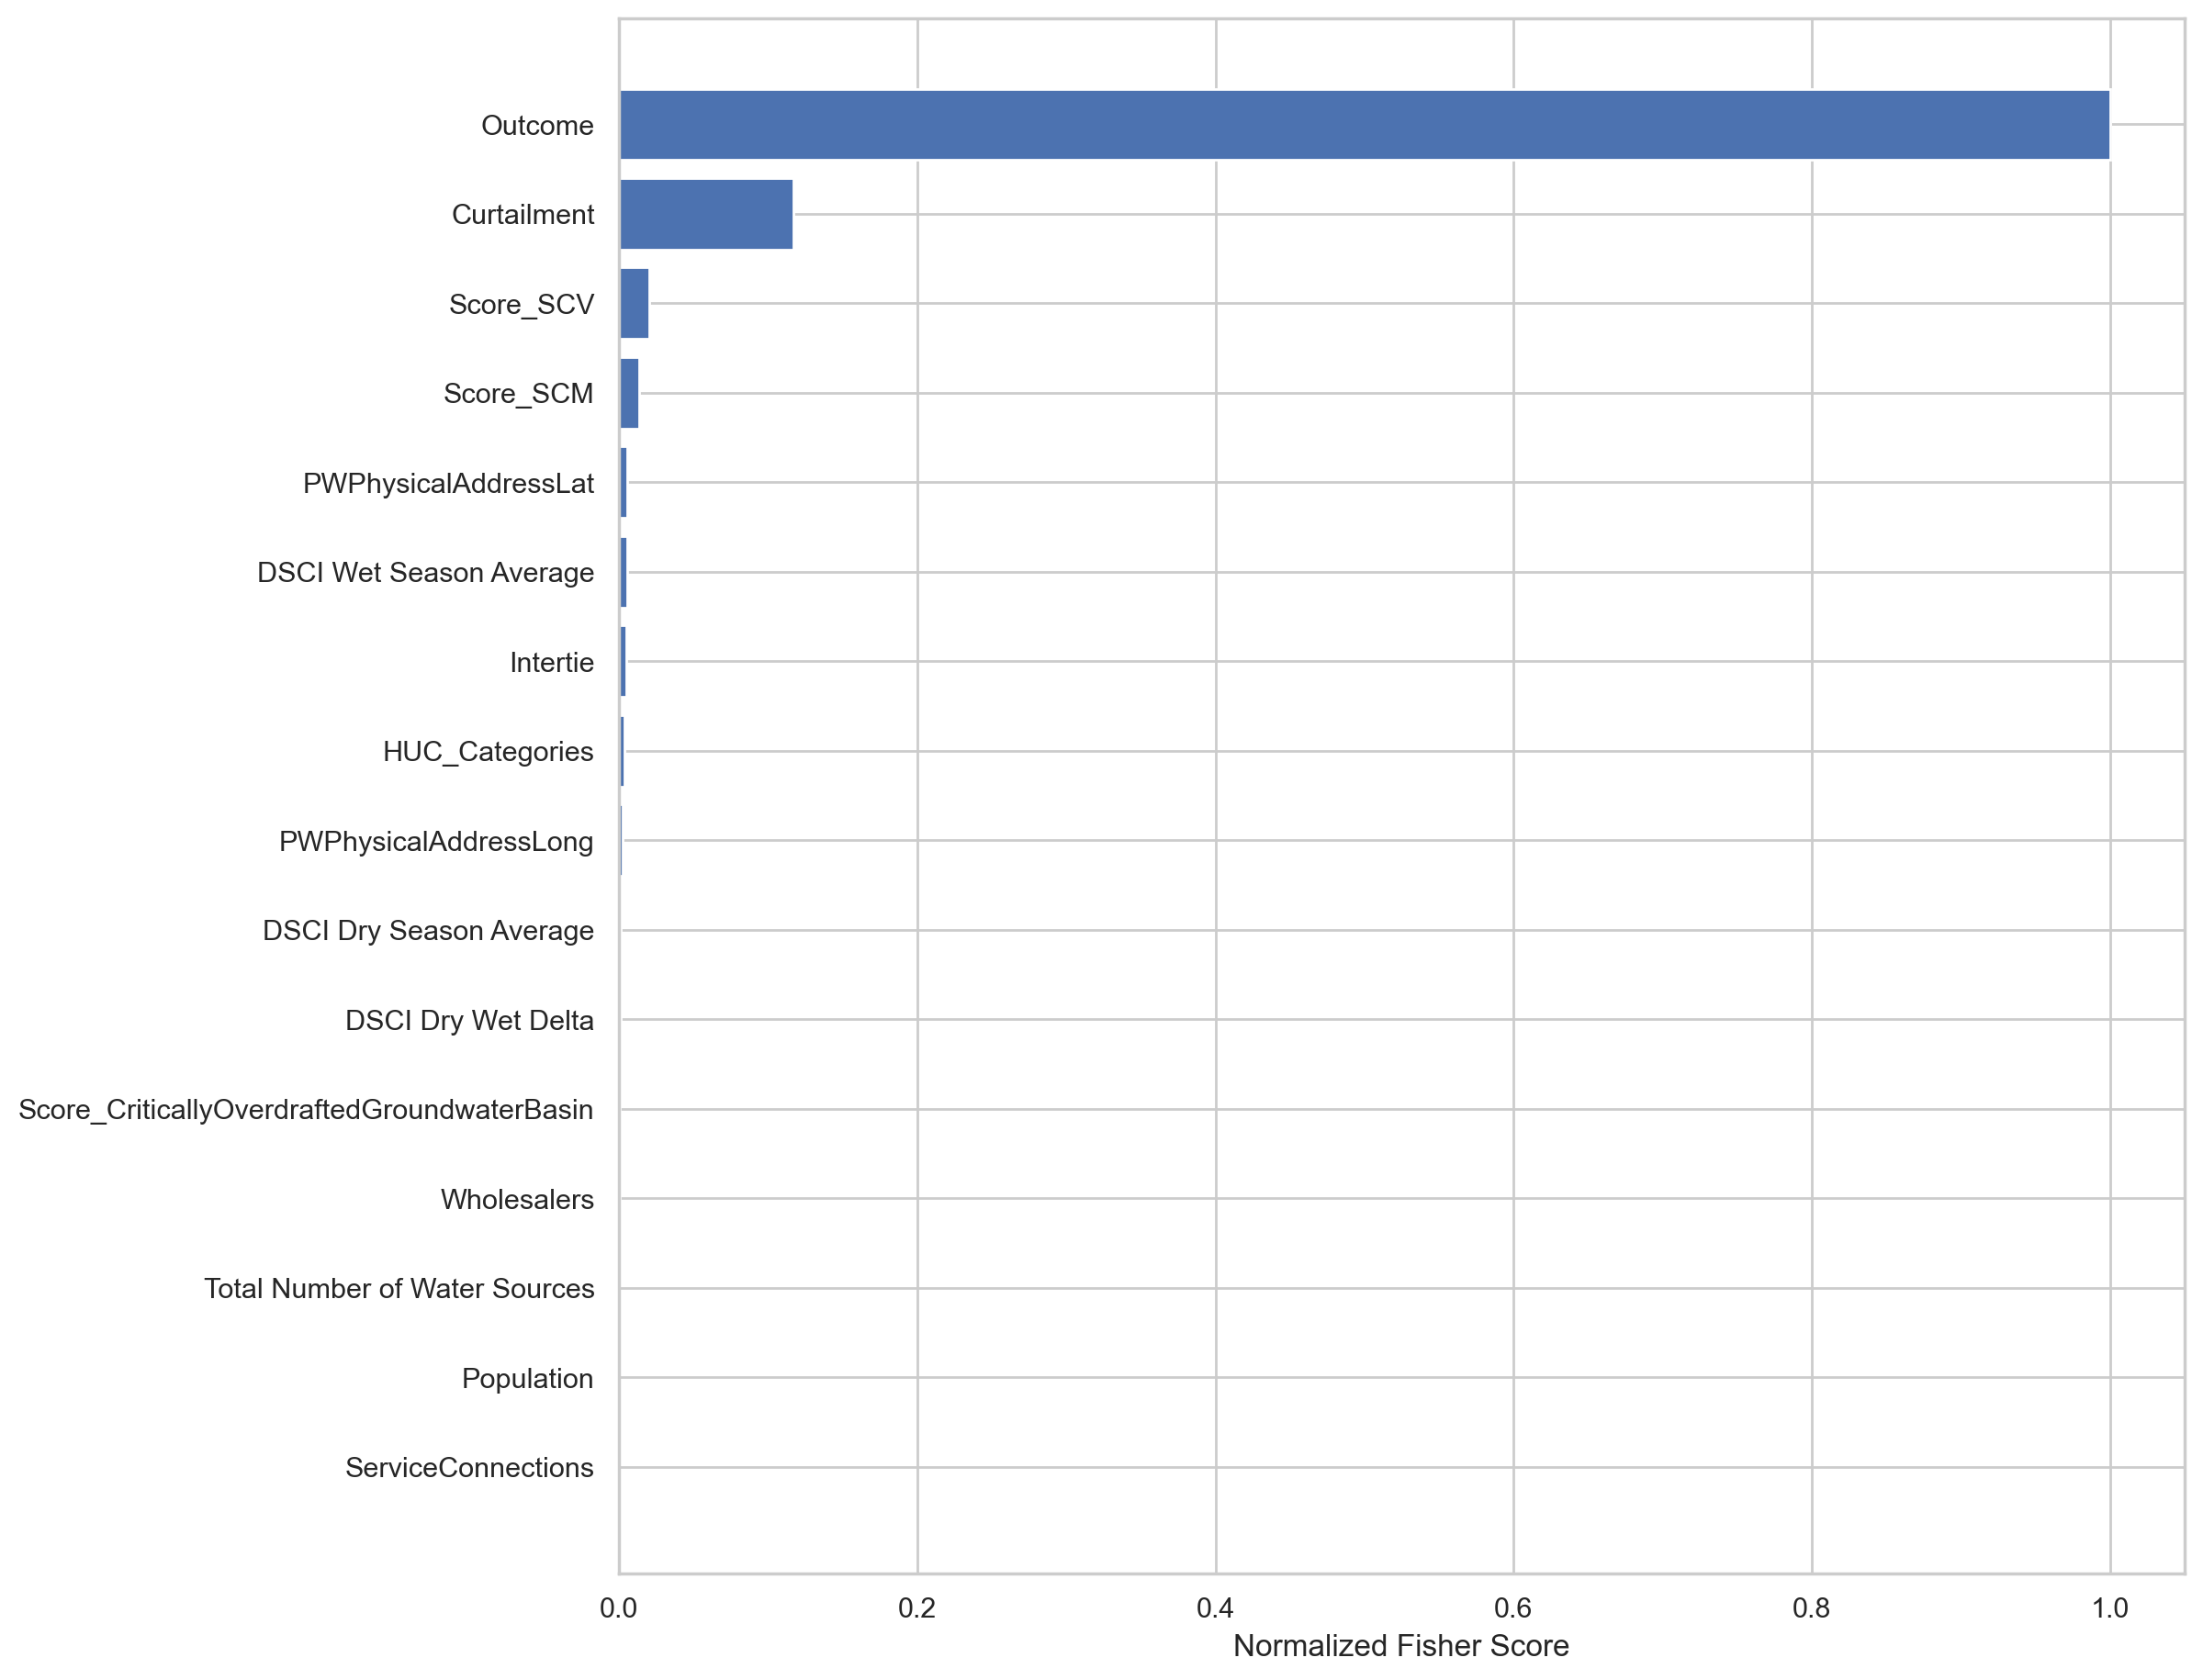

In [207]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

# Select method and fit
selector=SelectKBest(f_classif, k='all')
selector.fit(X, y)
scores_fisher = selector.scores_
scores_fisher[np.isnan(scores_fisher)] = 0.0

# Select, sort, and normalize features
features = X_train.columns.to_list()
order = np.argsort(scores_fisher)
ordered_features_fisher = [features[i] for i in order]
ordered_normalized_scores_fisher = sorted(scores_fisher/np.nanmax(scores_fisher))
ordered_scores_fisher = sorted(scores_fisher)

ax.barh(ordered_features_fisher, ordered_normalized_scores_fisher)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 4: How does the false positive rate and false negative rate change as a function of class weight?

In [208]:
def test_sample_weights(C, max_range, step_size):
    """
    This function tests the sample weights for a given C value.

    Parameters
    ----------
    C : float
        The C value for the SVM model.
    max_range : int
        The maximum value for the sample weight.
    step_size : int
        The step size for the sample weight.
    
    Returns
    -------
    df_weight : dataframe
        A dataframe containing the C value, sample weight, total misclassifications,
        total false positives, and total false negatives.
    
    Examples
    --------
    >>> df_weight = test_sample_weights(C=1, max_range=100, step_size=1)
    """

    # Convert validation labels into a numpy array
    y_val_np = np.array(y_val)

    # Create an empty dataframe
    out = [np.NaN]*int(max_range/step_size)
    df_weight = pd.DataFrame({'C':out, 'weight':out,
                          'total_false_positives':out, 'total_false_negatives':out,
                          'total_misclassifications':out})

    # Define some counters
    count_misclassifications = 0
    count_false_positive = 0
    count_false_negative = 0
    count_true_positive = 0
    count_true_negative = 0

    print ("C:", C)

    for i in range(0, max_range, step_size):
            
            # Define a counter
            df_weight['C'].iloc[i]=C
            positive_class_weight = i+1
            df_weight['weight'].iloc[i] = positive_class_weight
            print("--> Sample weight:", positive_class_weight)

            # Initialize the model
            clf = svm.SVC(gamma='auto', kernel='rbf', C=C, class_weight={0:1, 1: positive_class_weight}, probability=True)

            # Fit the model
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_val_scaled)

            for j in range(len(y_val_np)):
                if y_val_np[j] != y_pred[j]:
                    count_misclassifications += 1
                if ((y_val_np[j] == 1.0) and (y_pred[j] == 0.0)):
                    count_false_negative += 1      
                if ((y_val_np[j] == 0.0) and (y_pred[j] == 1.0)):
                    count_false_positive += 1    
                if ((y_val_np[j] == 1.0) and (y_pred[j] == 1.0)):
                    count_true_positive += 1      
                if ((y_val_np[j] == 0.0) and (y_pred[j] == 0.0)):
                    count_true_negative += 1    

            df_weight['total_misclassifications'].iloc[i] = count_misclassifications
            df_weight['total_false_negatives'].iloc[i] = count_false_negative
            df_weight['total_false_positives'].iloc[i] = count_false_positive

            count_misclassifications = 0
            count_false_positive = 0
            count_false_negative = 0
            count_true_positive = 0
            count_true_negative = 0
            
    return df_weight

In [209]:
df_weights = []
for i in (0.5, 1.0, 2.0, 4.0, 8.0):
    df_weight = test_sample_weights(C = i, max_range=20, step_size=1)
    df_weights.append(df_weight)

C: 0.5
--> Sample weight: 1
--> Sample weight: 2
--> Sample weight: 3
--> Sample weight: 4
--> Sample weight: 5
--> Sample weight: 6
--> Sample weight: 7
--> Sample weight: 8
--> Sample weight: 9
--> Sample weight: 10
--> Sample weight: 11
--> Sample weight: 12
--> Sample weight: 13
--> Sample weight: 14
--> Sample weight: 15
--> Sample weight: 16
--> Sample weight: 17
--> Sample weight: 18
--> Sample weight: 19
--> Sample weight: 20
C: 1.0
--> Sample weight: 1
--> Sample weight: 2
--> Sample weight: 3
--> Sample weight: 4
--> Sample weight: 5
--> Sample weight: 6
--> Sample weight: 7
--> Sample weight: 8
--> Sample weight: 9
--> Sample weight: 10
--> Sample weight: 11
--> Sample weight: 12
--> Sample weight: 13
--> Sample weight: 14
--> Sample weight: 15
--> Sample weight: 16
--> Sample weight: 17
--> Sample weight: 18
--> Sample weight: 19
--> Sample weight: 20
C: 2.0
--> Sample weight: 1
--> Sample weight: 2
--> Sample weight: 3
--> Sample weight: 4
--> Sample weight: 5
--> Sample w

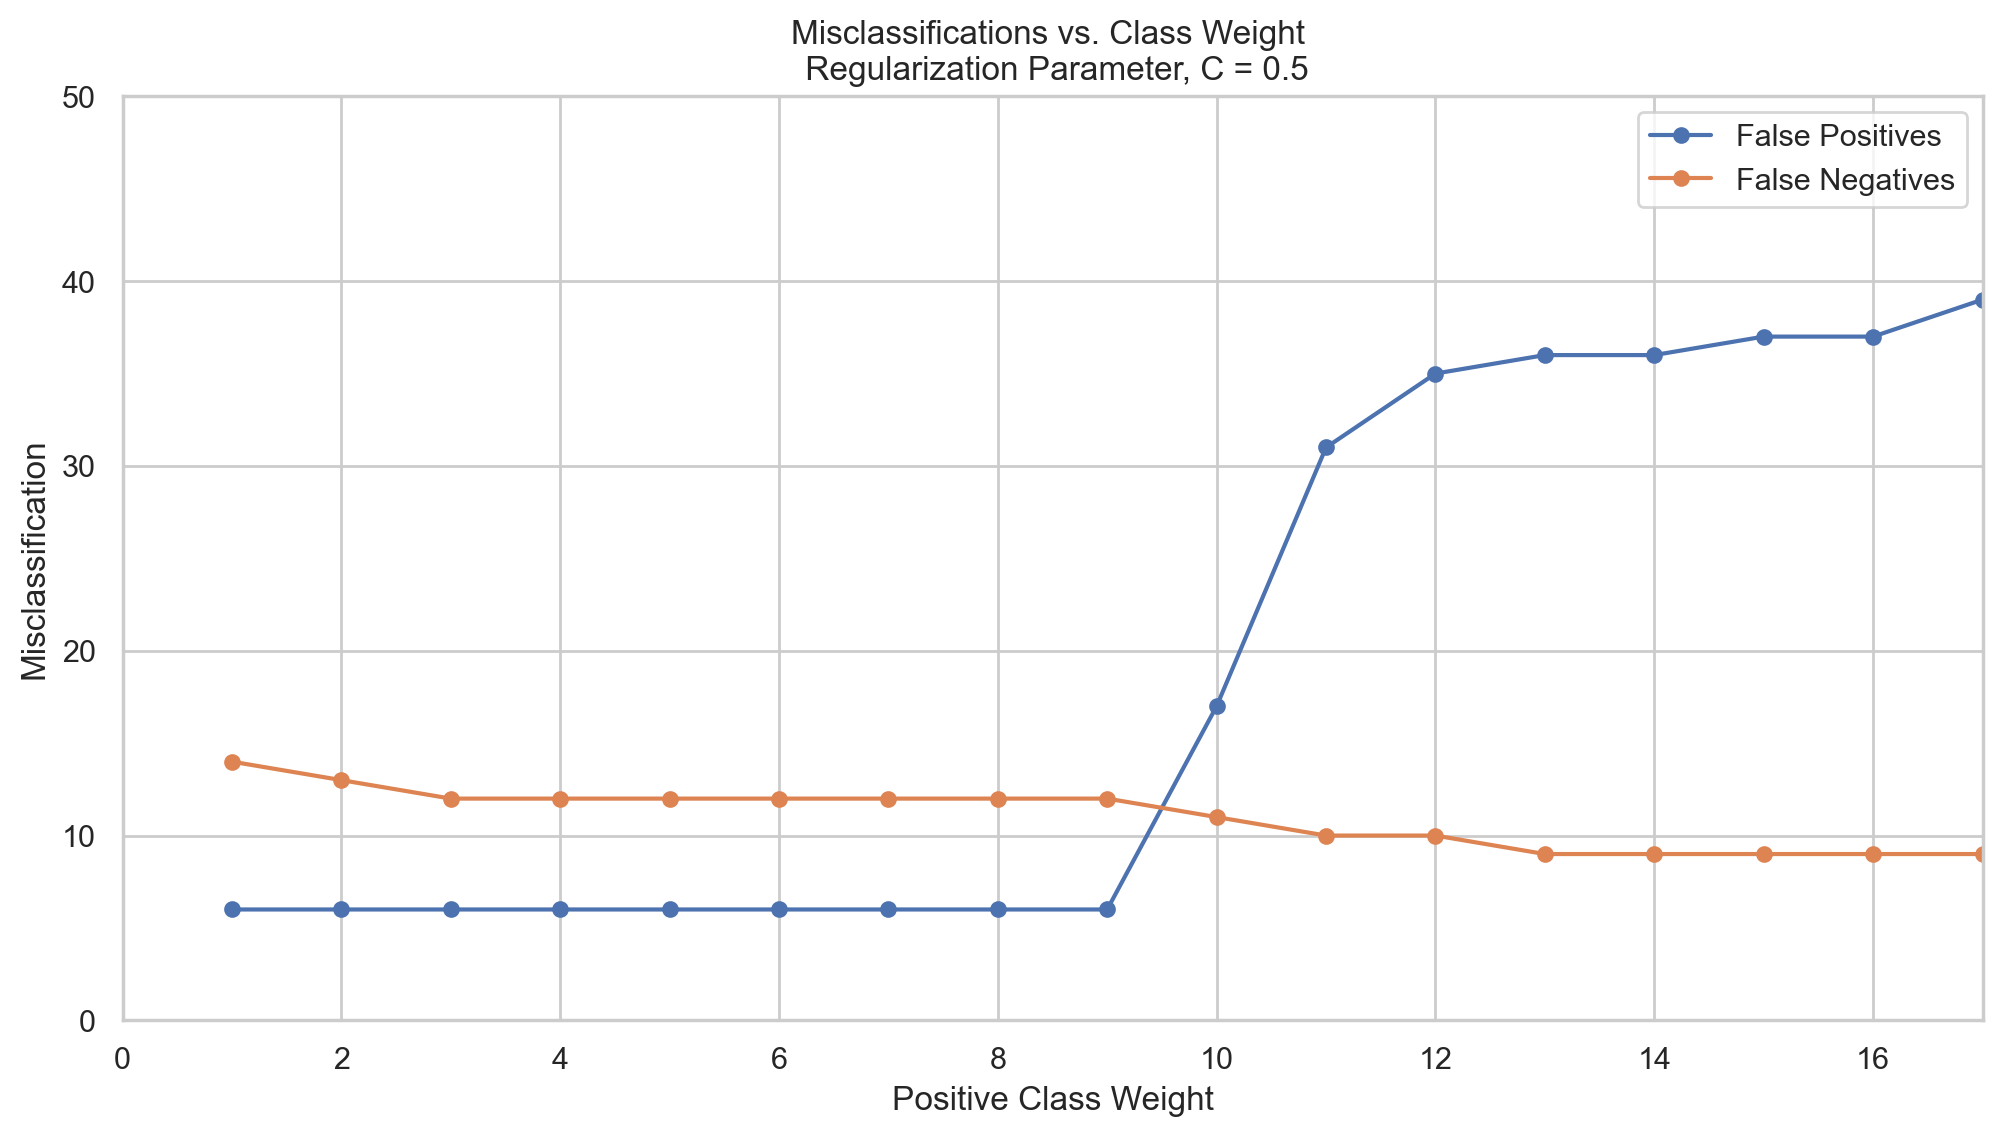

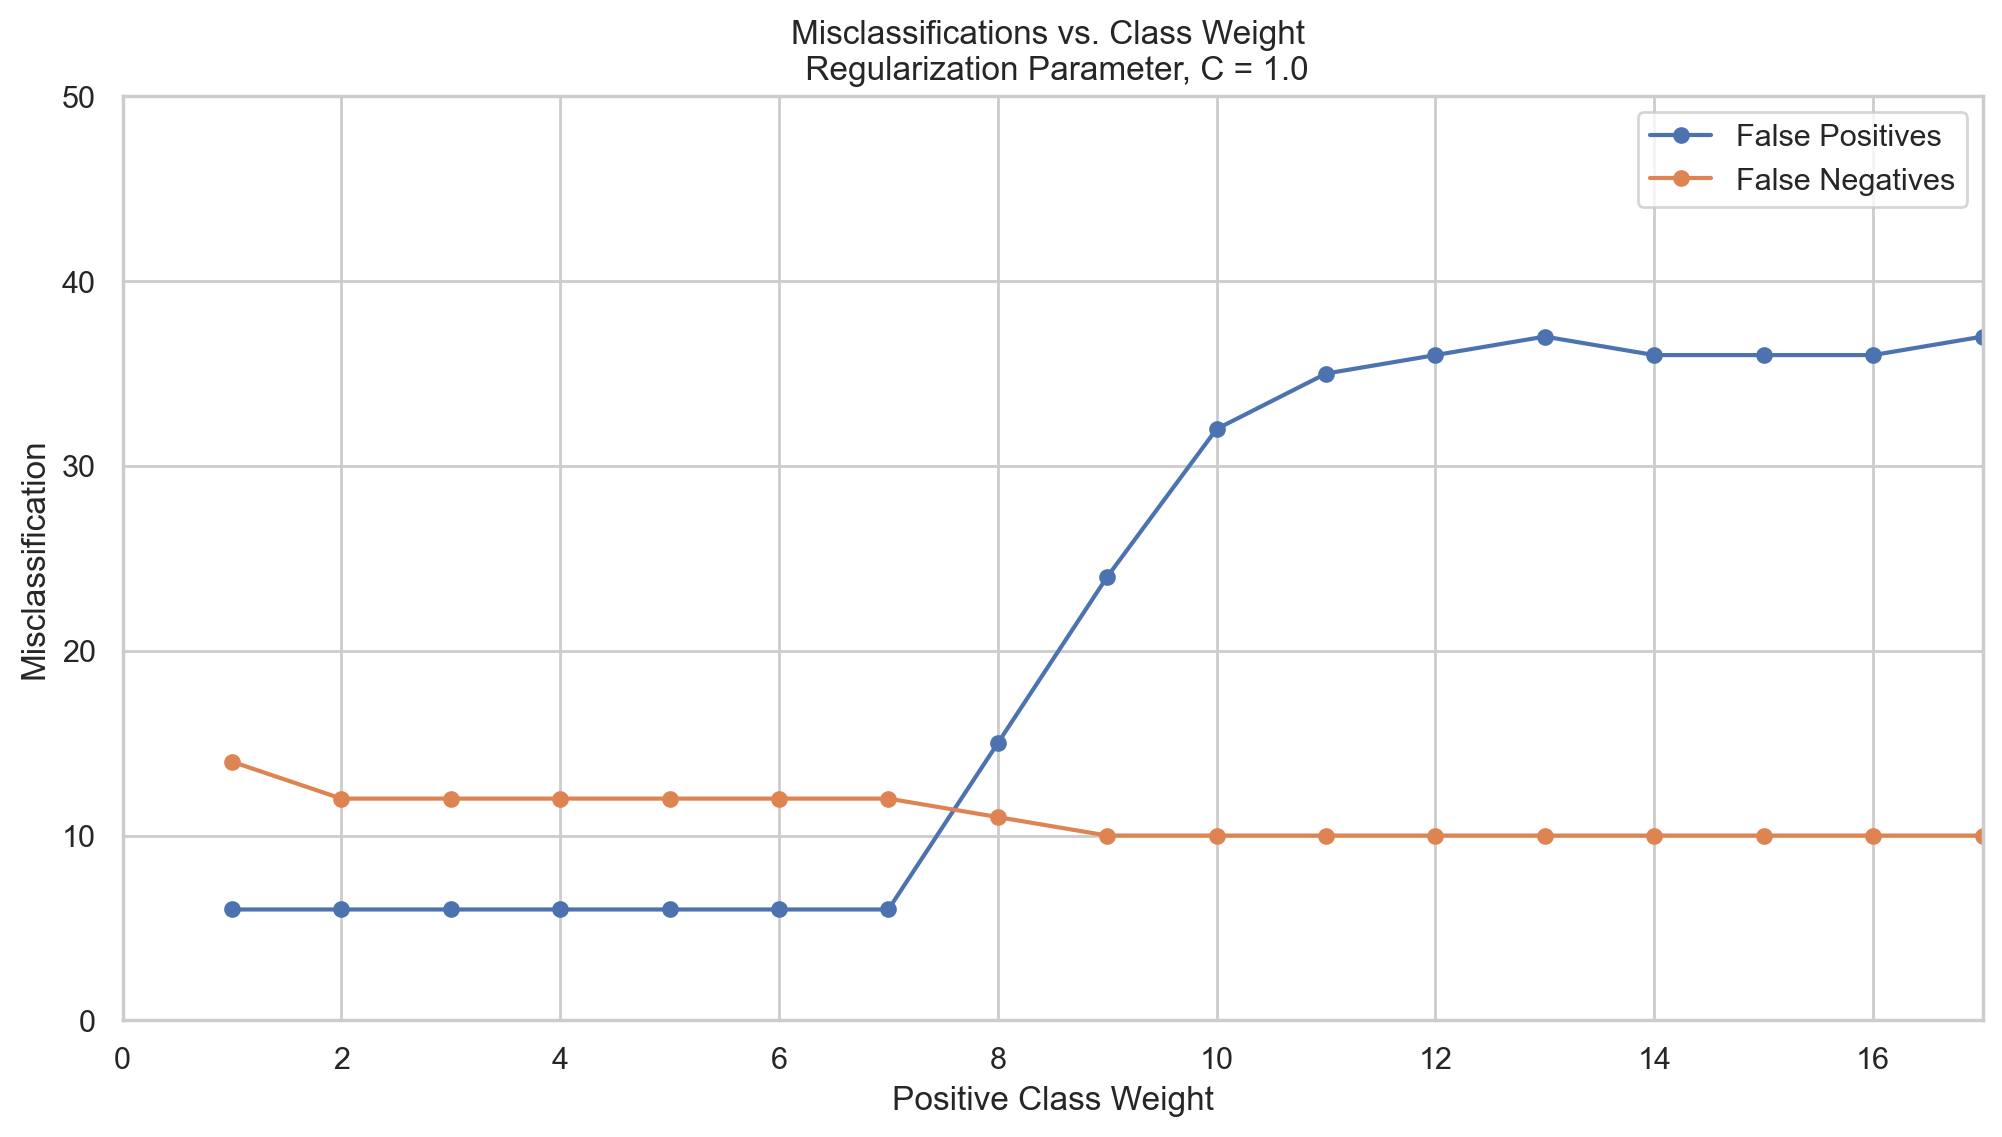

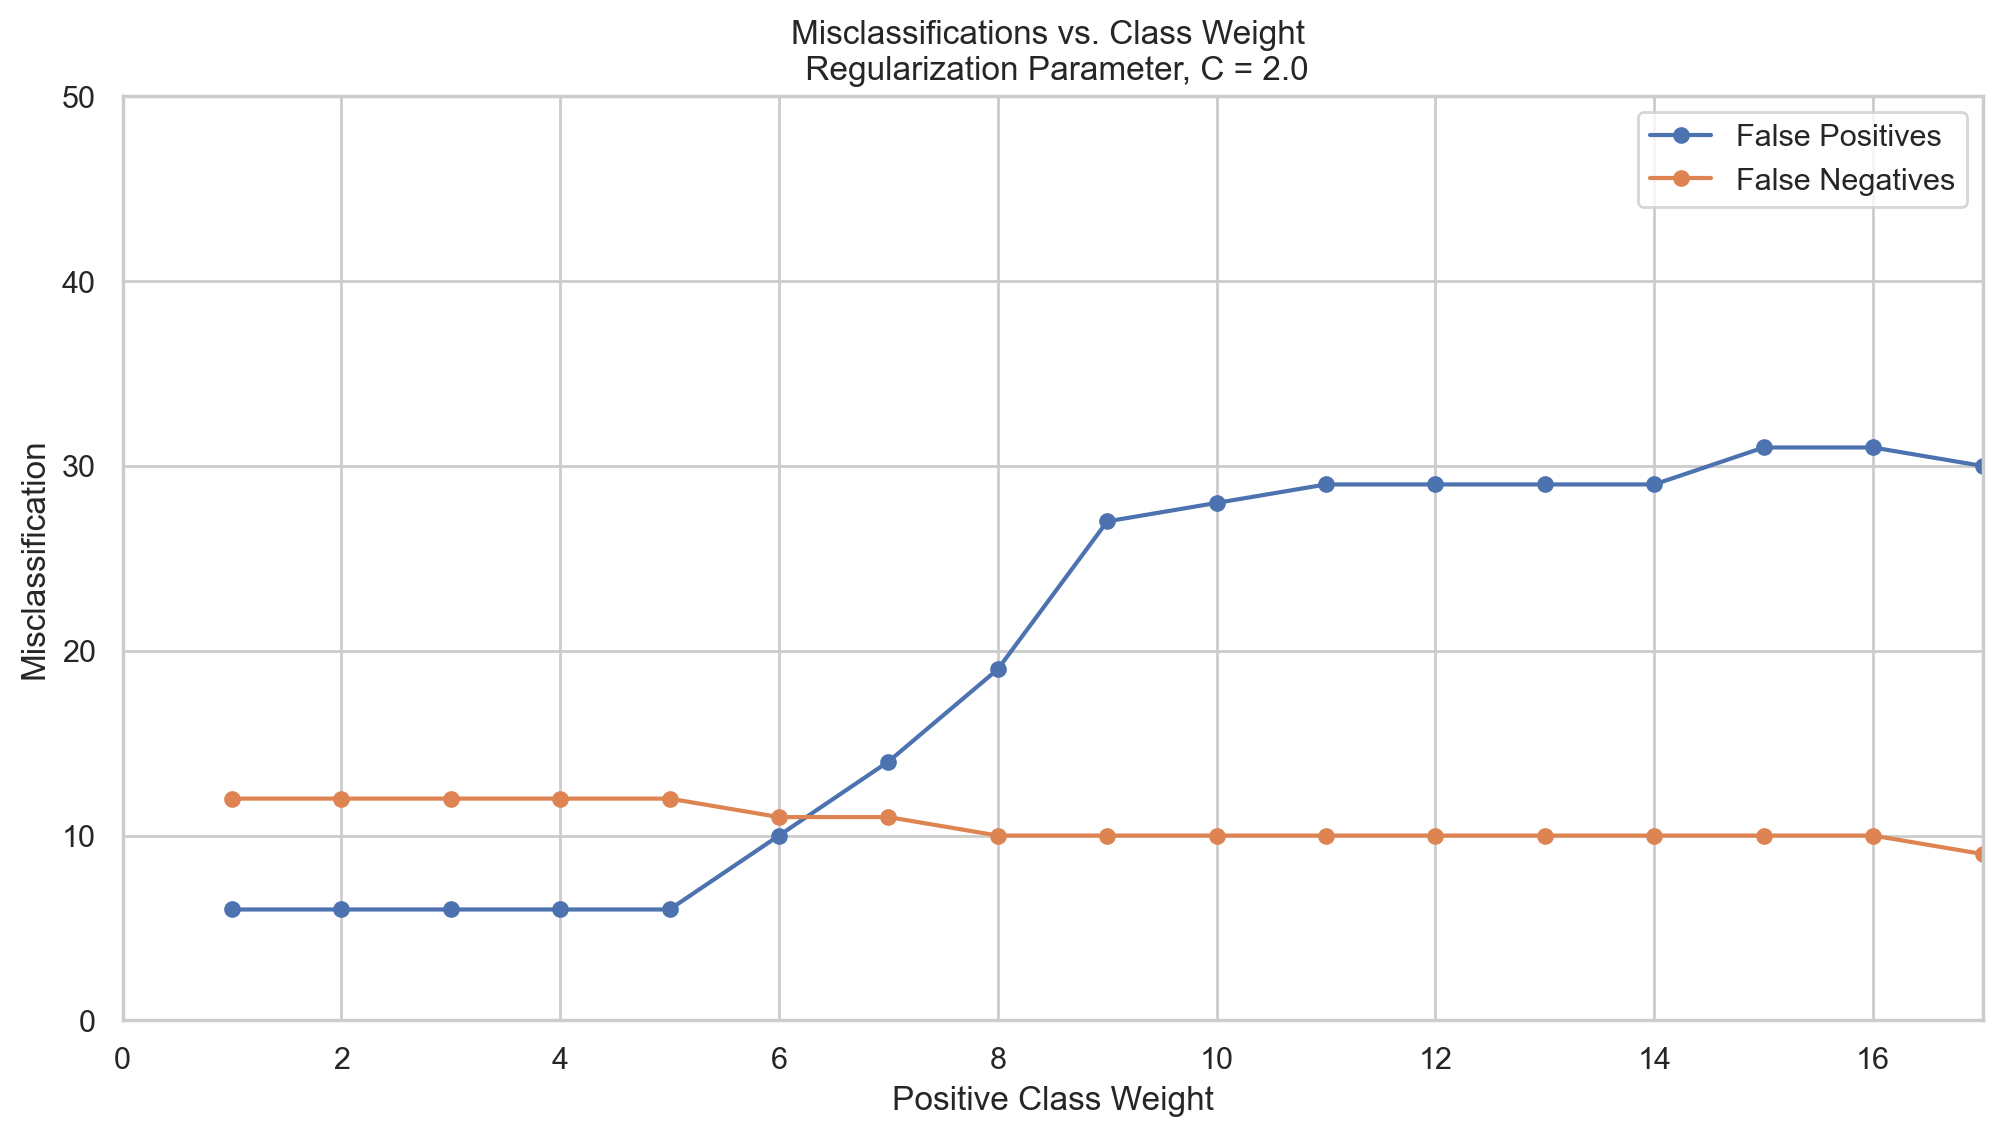

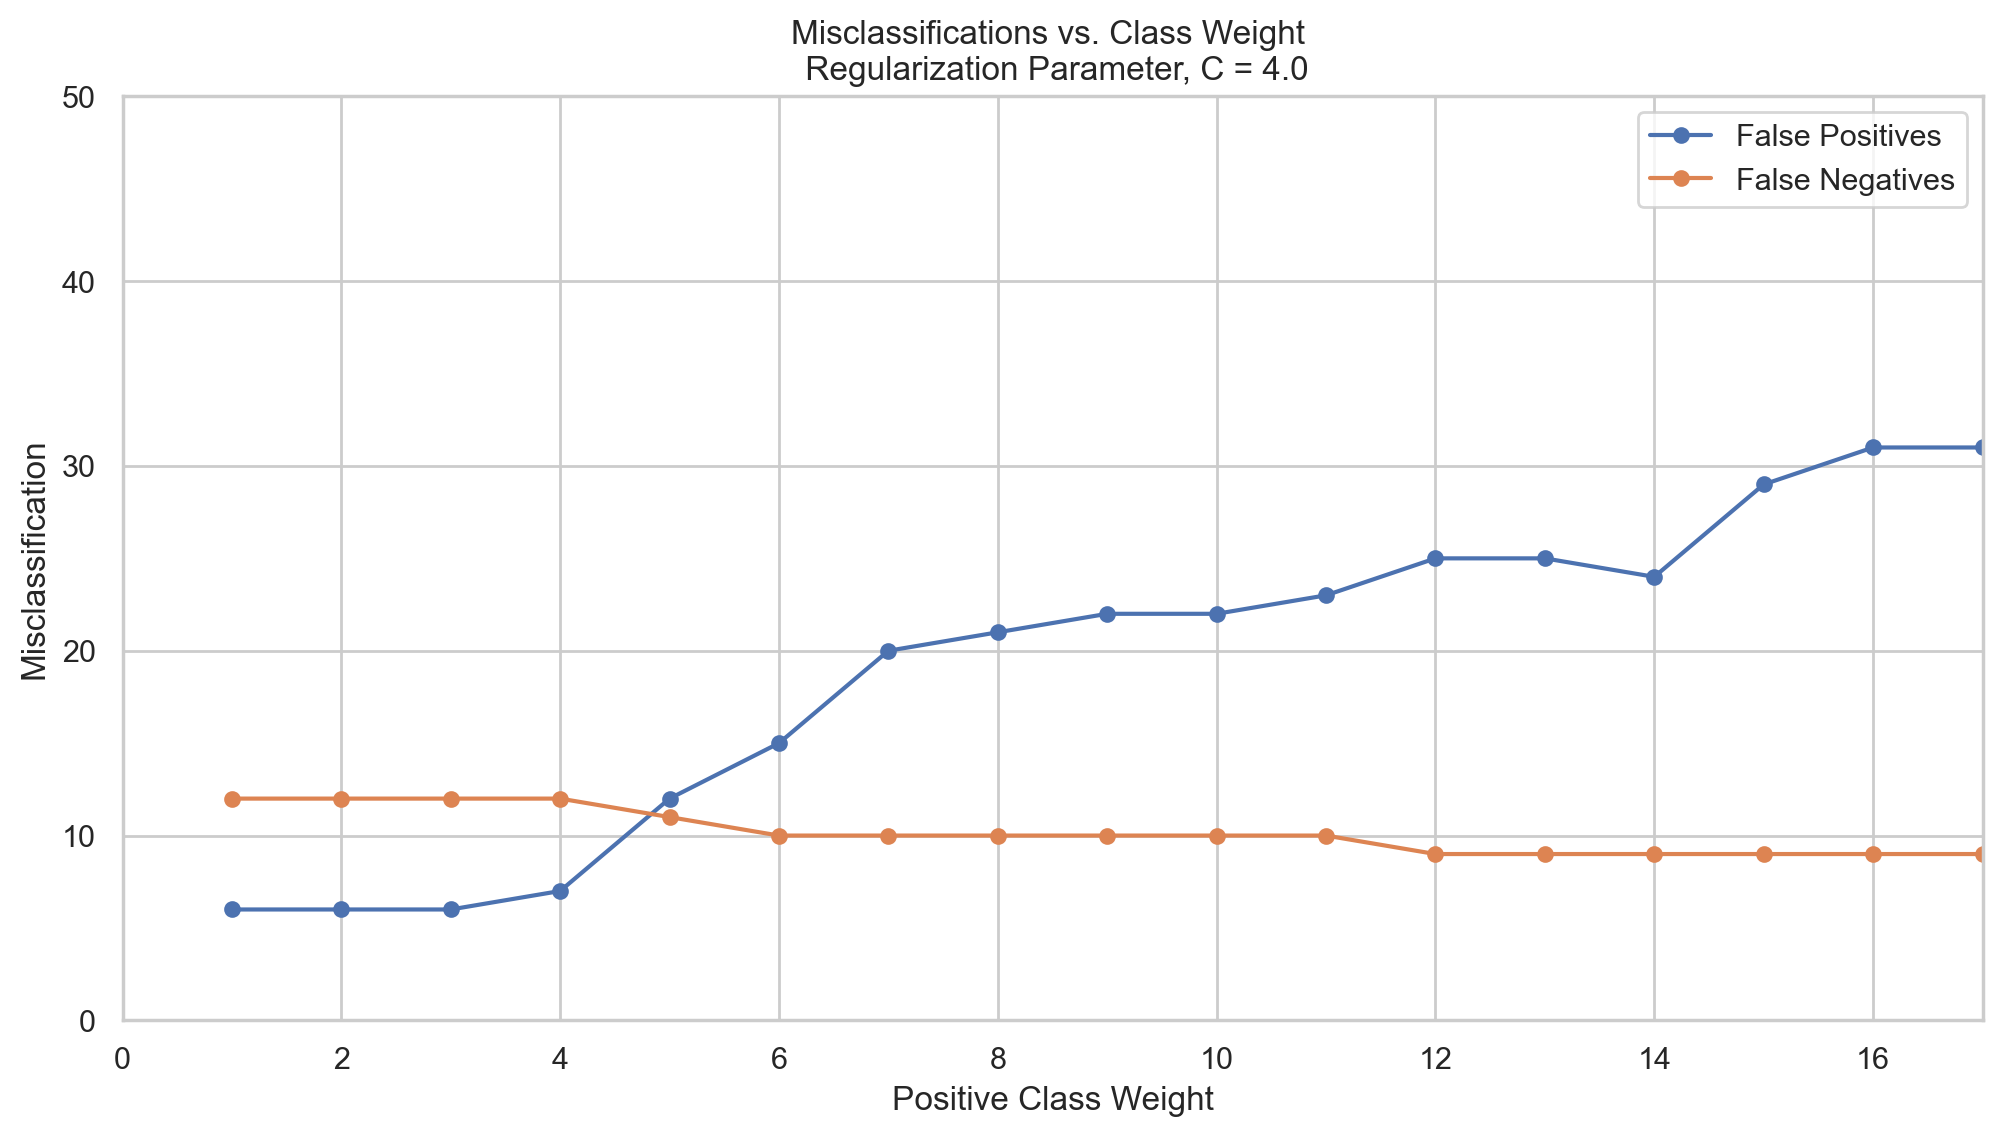

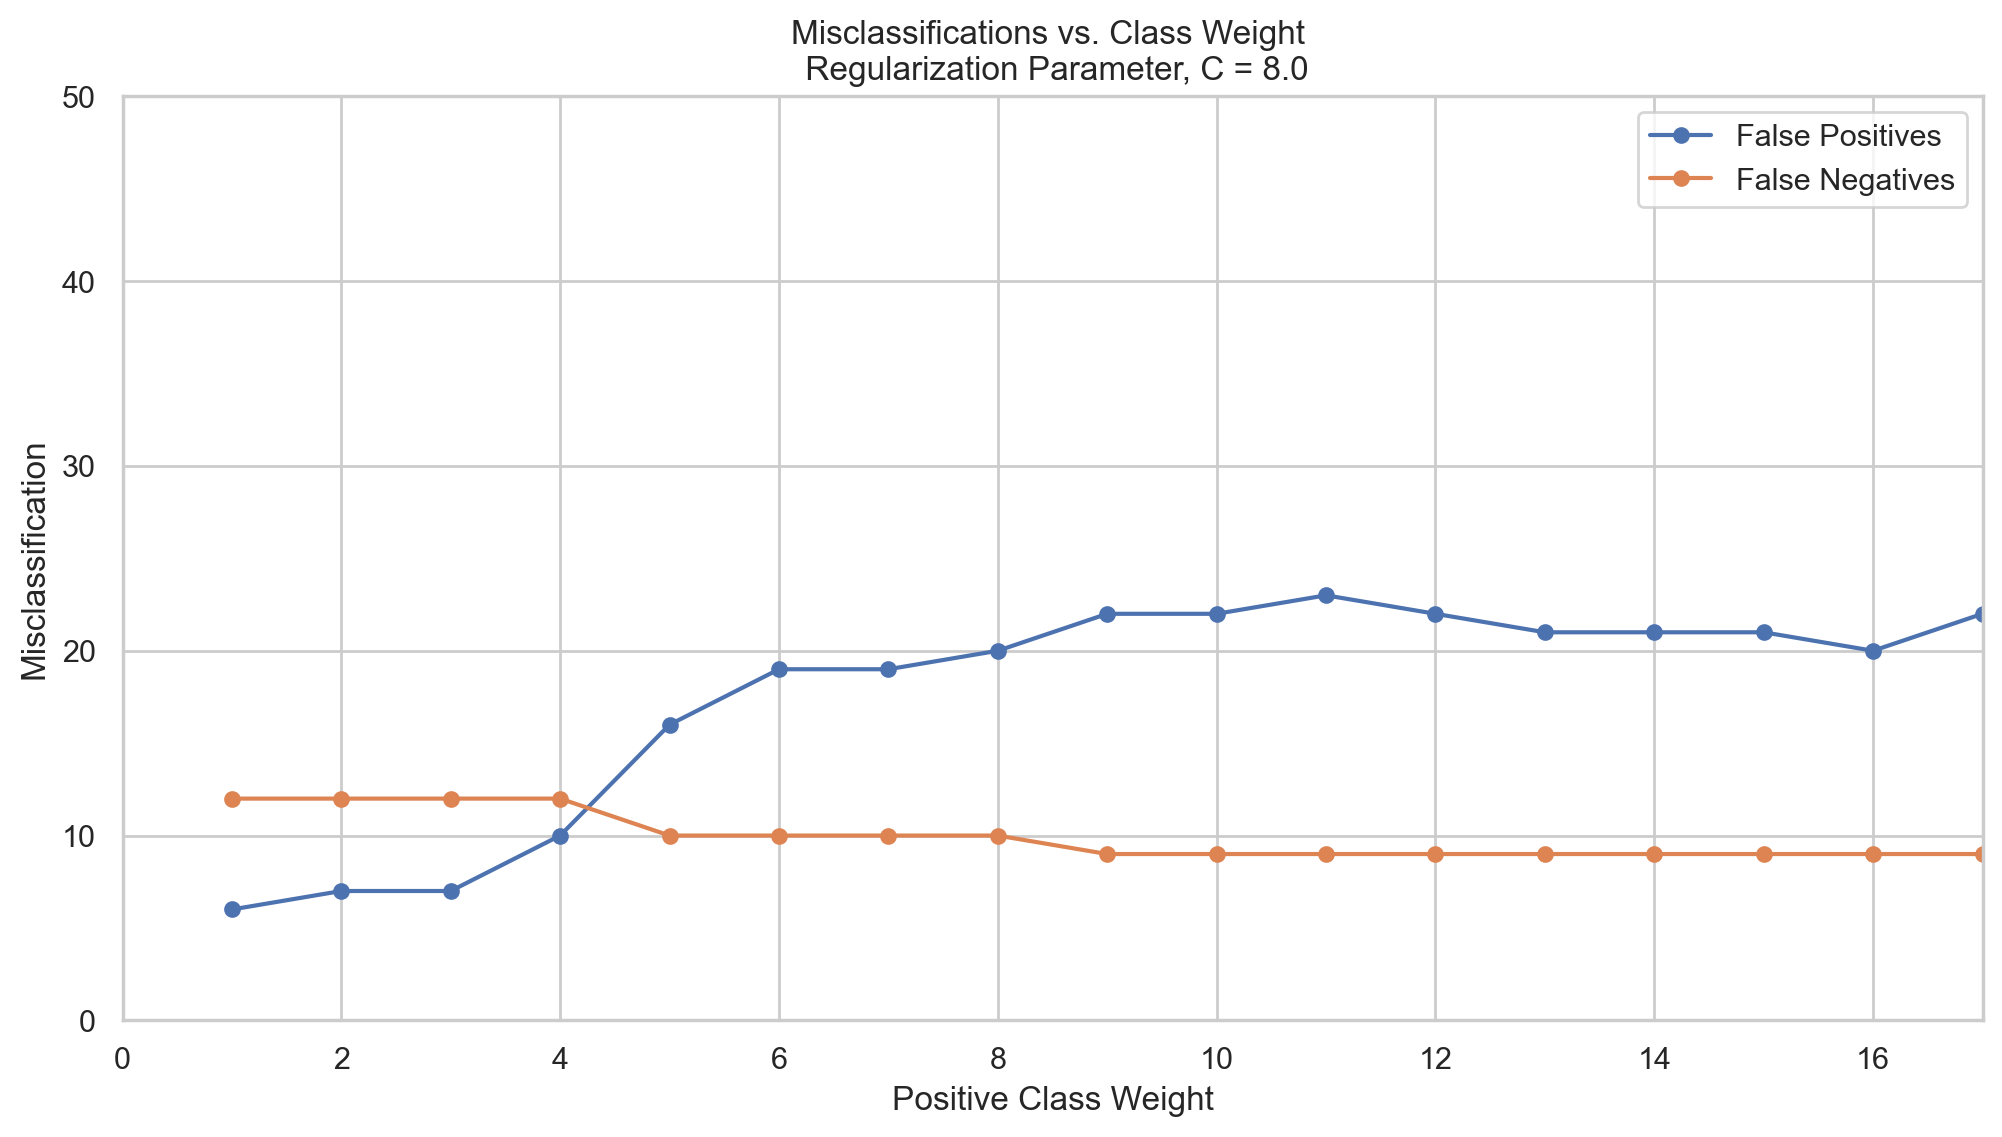

In [210]:
for i in range(len(df_weights)):
    fig, ax = plt.subplots(figsize=(12,6))
    sns.set_theme(style='whitegrid')
    ax.errorbar(df_weights[i]['weight'], df_weights[i]['total_false_positives'], marker=".", markersize=10, label='False Positives')
    ax.errorbar(df_weights[i]['weight'], df_weights[i]['total_false_negatives'], marker=".", markersize=10, label='False Negatives')
    ax.set_ylabel('Misclassification')
    ax.set_xlabel('Positive Class Weight')
    C = (df_weights[i]['C'][0])
    ax.set_title('Misclassifications vs. Class Weight \n Regularization Parameter, C = '+str(C))
    ax.legend()
    ax.set_ylim(0,50)
    ax.set_xlim(0,17)
    #fig.savefig('weightsversusmisclassifications_C_'+str(C)+'_svm.png', dpi=300, transparent=True, bbox_inches='tight')

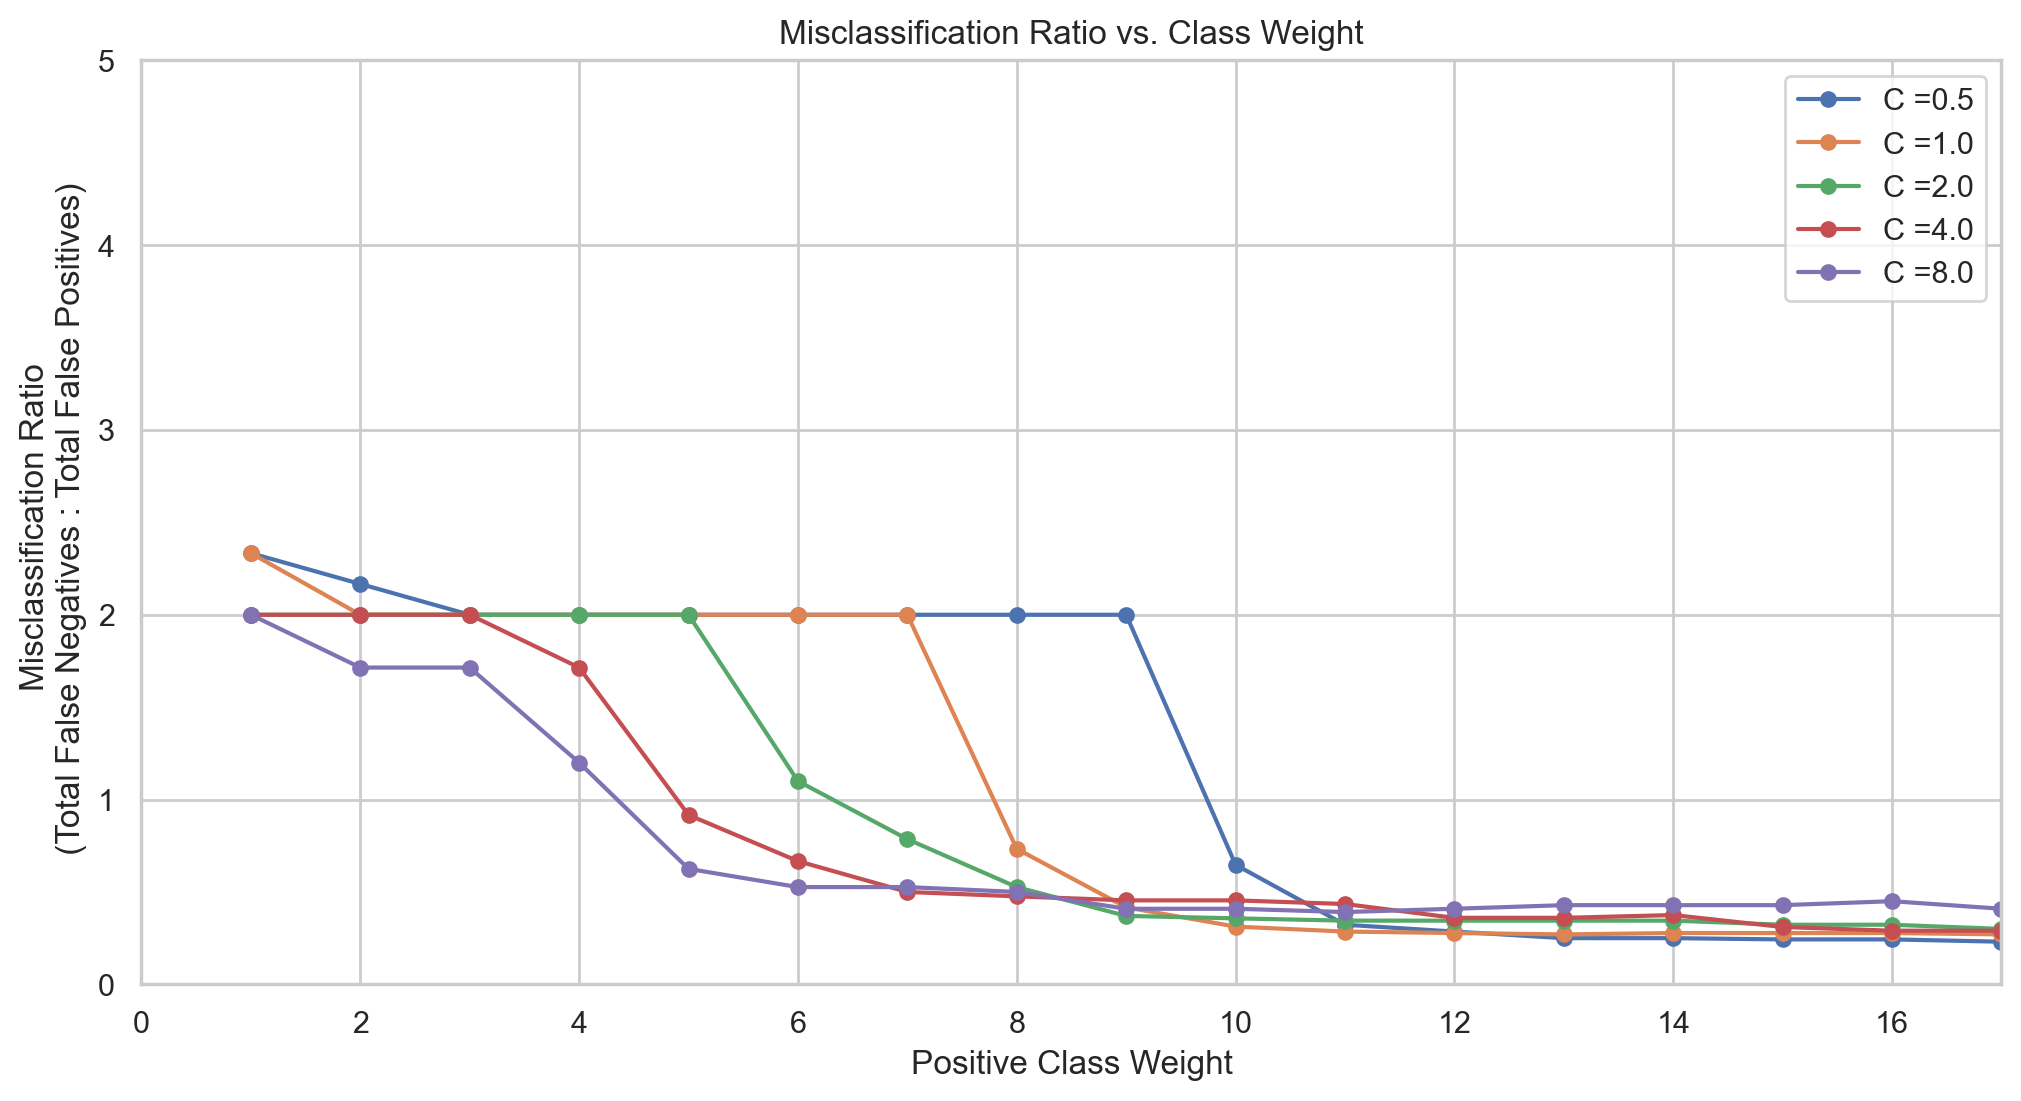

In [211]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(df_weights[0]['weight'].astype('int'), 
            df_weights[0]['total_false_negatives']/df_weights[0]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[0]['C'][0]))
ax.errorbar(df_weights[1]['weight'].astype('int'), 
            df_weights[1]['total_false_negatives']/df_weights[1]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[1]['C'][0]))
ax.errorbar(df_weights[2]['weight'].astype('int'), 
            df_weights[2]['total_false_negatives']/df_weights[2]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[2]['C'][0]))
ax.errorbar(df_weights[3]['weight'].astype('int'), 
            df_weights[3]['total_false_negatives']/df_weights[3]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[3]['C'][0]))
ax.errorbar(df_weights[4]['weight'].astype('int'), 
            df_weights[4]['total_false_negatives']/df_weights[4]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[4]['C'][0]))
ax.set_ylabel('Misclassification Ratio \n (Total False Negatives : Total False Positives)')
ax.set_xlabel('Positive Class Weight')
ax.set_title('Misclassification Ratio vs. Class Weight')
ax.set_ylim(0,5)
ax.set_xlim(0,17)
ax.legend()
#fig.savefig('weightsversusmisclassificationsratio_estimators_svm.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 5: Which label performs the best?

Plot the skill score as a function of number of features per label.

Note that the label `WaterOutageDroughtViolation` only has three examples, so it cannot be reliably split across training and test when stratifying by HUC category.

In [212]:
df_water_year_2022 = df_combined[df_combined['Water Year'] == 2022]

In [213]:
print("Number of positive examples in DroughtExperienced:",len(df_water_year_2022[df_water_year_2022['DroughtExperienced'] == 1]))
print("Number of positive examples in WaterOutageDroughtViolation:",len(df_water_year_2022[df_water_year_2022['WaterOutageDroughtViolation'] == 1]))
print("Number of positive examples in BottledHauledWaterOrZeroSource:",len(df_water_year_2022[df_water_year_2022['BottledHauledWaterOrZeroSource'] == 1]))
print("Number of positive examples in CurtailmentExemptionPetition:",len(df_water_year_2022[df_water_year_2022['CurtailmentExemptionPetition'] == 1]))

Number of positive examples in DroughtExperienced: 122
Number of positive examples in WaterOutageDroughtViolation: 3
Number of positive examples in BottledHauledWaterOrZeroSource: 66
Number of positive examples in CurtailmentExemptionPetition: 53


In [214]:
len(df_water_year_2022) - 122

2744

In [215]:
outcome_label = [
 'DroughtExperienced',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition']

In [216]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

In [217]:
print(ordered_features_fisher)

['ServiceConnections', 'Population', 'Total Number of Water Sources', 'Wholesalers', 'Score_CriticallyOverdraftedGroundwaterBasin', 'DSCI Dry Wet Delta', 'DSCI Dry Season Average', 'PWPhysicalAddressLong', 'HUC_Categories', 'Intertie', 'DSCI Wet Season Average', 'PWPhysicalAddressLat', 'Score_SCM', 'Score_SCV', 'Curtailment', 'Outcome']


In [218]:
TSS_values_per_label = []
TSS_std_per_label = []

for k in range(len(outcome_label)):
    TSS_values = []
    TSS_std = []
    
    # Construct the features        
    X = df_combined[df_combined['Water Year'] == 2021]
    X = X.drop(columns=temporary_features)
    X = X.rename(columns={'DroughtExperienced' : 'Outcome'})
    X = X[ordered_features_fisher]

    # Construct and select the label
    y = df_combined[outcome_label[k]][df_combined['Water Year'] == 2022]
    print(outcome_label[k])
    y = y.drop(columns=temporary_features)

    # Construct the splits
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.36, random_state=77, stratify=X['HUC_Categories'])

    # Unravel the label
    y_val = y_val.values.ravel()
    y_train = y_train.values.ravel()
    
    for i in range(len(ordered_features_fisher)):
        
        # Select the features
        X_train = X_train[ordered_features_fisher[i:]]
        X_val = X_val[ordered_features_fisher[i:]]
        total_features = X_train.columns.to_list()
        
        # Identify the numeric and categorical features
        total_numeric_features = list(set(total_features).intersection(numeric_features))
        total_categorical_features = list(set(total_features).intersection(categorical_features))
        
        TSS_scores = []
        for j in range(10):    # This should eventually be 100

            # Select and scale the numeric features
            if total_numeric_features:
                scaler = preprocessing.StandardScaler()
                X_train_numeric = X_train[total_numeric_features]
                X_val_numeric = X_val[total_numeric_features]
                X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
                X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

            # Select the categorical features
            if total_categorical_features:
                X_train_categorical = np.array(X_train[total_categorical_features])
                X_val_categorical = np.array(X_val[total_categorical_features])

            # Create training and validation sets
            if total_numeric_features and total_categorical_features:
                X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
                X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
            if total_numeric_features and not total_categorical_features:
                X_train_scaled = X_train_numeric_scaled
                X_val_scaled = X_val_numeric_scaled
            if not total_numeric_features and total_categorical_features:
                X_train_scaled = X_train_categorical
                X_val_scaled = X_val_categorical

            # Train the model
            clf = svm.SVC(gamma='auto', kernel='rbf', C=4, class_weight={0:1, 1: 5}, probability=True)
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_val_scaled)
            
            # Calculate TSS
            TN, FP, TP, FN = confusion_table(np.array(y_pred), np.array(y_val))
            TSS_score = TP/(TP+FN) - FP/(FP+TN)
            TSS_scores.append(TSS_score)
        
        TSS_std.append(np.std(TSS_scores))
        TSS_values.append(np.mean(TSS_scores))
        print(i,np.mean(TSS_scores), np.std(TSS_scores))

    TSS_std_per_label.append(TSS_std)
    TSS_values_per_label.append(TSS_values)

DroughtExperienced
0 0.7433975008443092 1.1102230246251565e-16
1 0.7433975008443092 1.1102230246251565e-16
2 0.7454238432961837 0.0
3 0.768659236744343 1.1102230246251565e-16
4 0.768659236744343 1.1102230246251565e-16
5 0.768659236744343 1.1102230246251565e-16
6 0.7696724079702804 0.0
7 0.7706855791962175 0.0
8 0.7706855791962175 0.0
9 0.7706855791962175 0.0
10 0.7696724079702804 0.0
11 0.7696724079702804 0.0
12 0.7716987504221546 1.1102230246251565e-16
13 0.7716987504221546 1.1102230246251565e-16
14 0.7716987504221546 1.1102230246251565e-16
15 0.7716987504221546 1.1102230246251565e-16
BottledHauledWaterOrZeroSource
0 0.7612784829484631 0.0
1 0.7612784829484631 0.0
2 0.7602844471631748 1.1102230246251565e-16
3 0.7602844471631748 1.1102230246251565e-16
4 0.7612784829484631 0.0
5 0.7612784829484631 0.0
6 0.7612784829484631 0.0
7 0.7602844471631748 1.1102230246251565e-16
8 0.7622725187337513 0.0
9 0.7612784829484631 0.0
10 0.7612784829484631 0.0
11 0.7632665545190396 1.1102230246251565e-1

In [219]:
df_TSS = pd.DataFrame({'TSS Scores': TSS_values_per_label, 
                       'TSS Standard Deviation': TSS_std_per_label, 
                       'Outcome Label': outcome_label})

In [220]:
np.arange(len(df_TSS['TSS Scores'][1]))+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

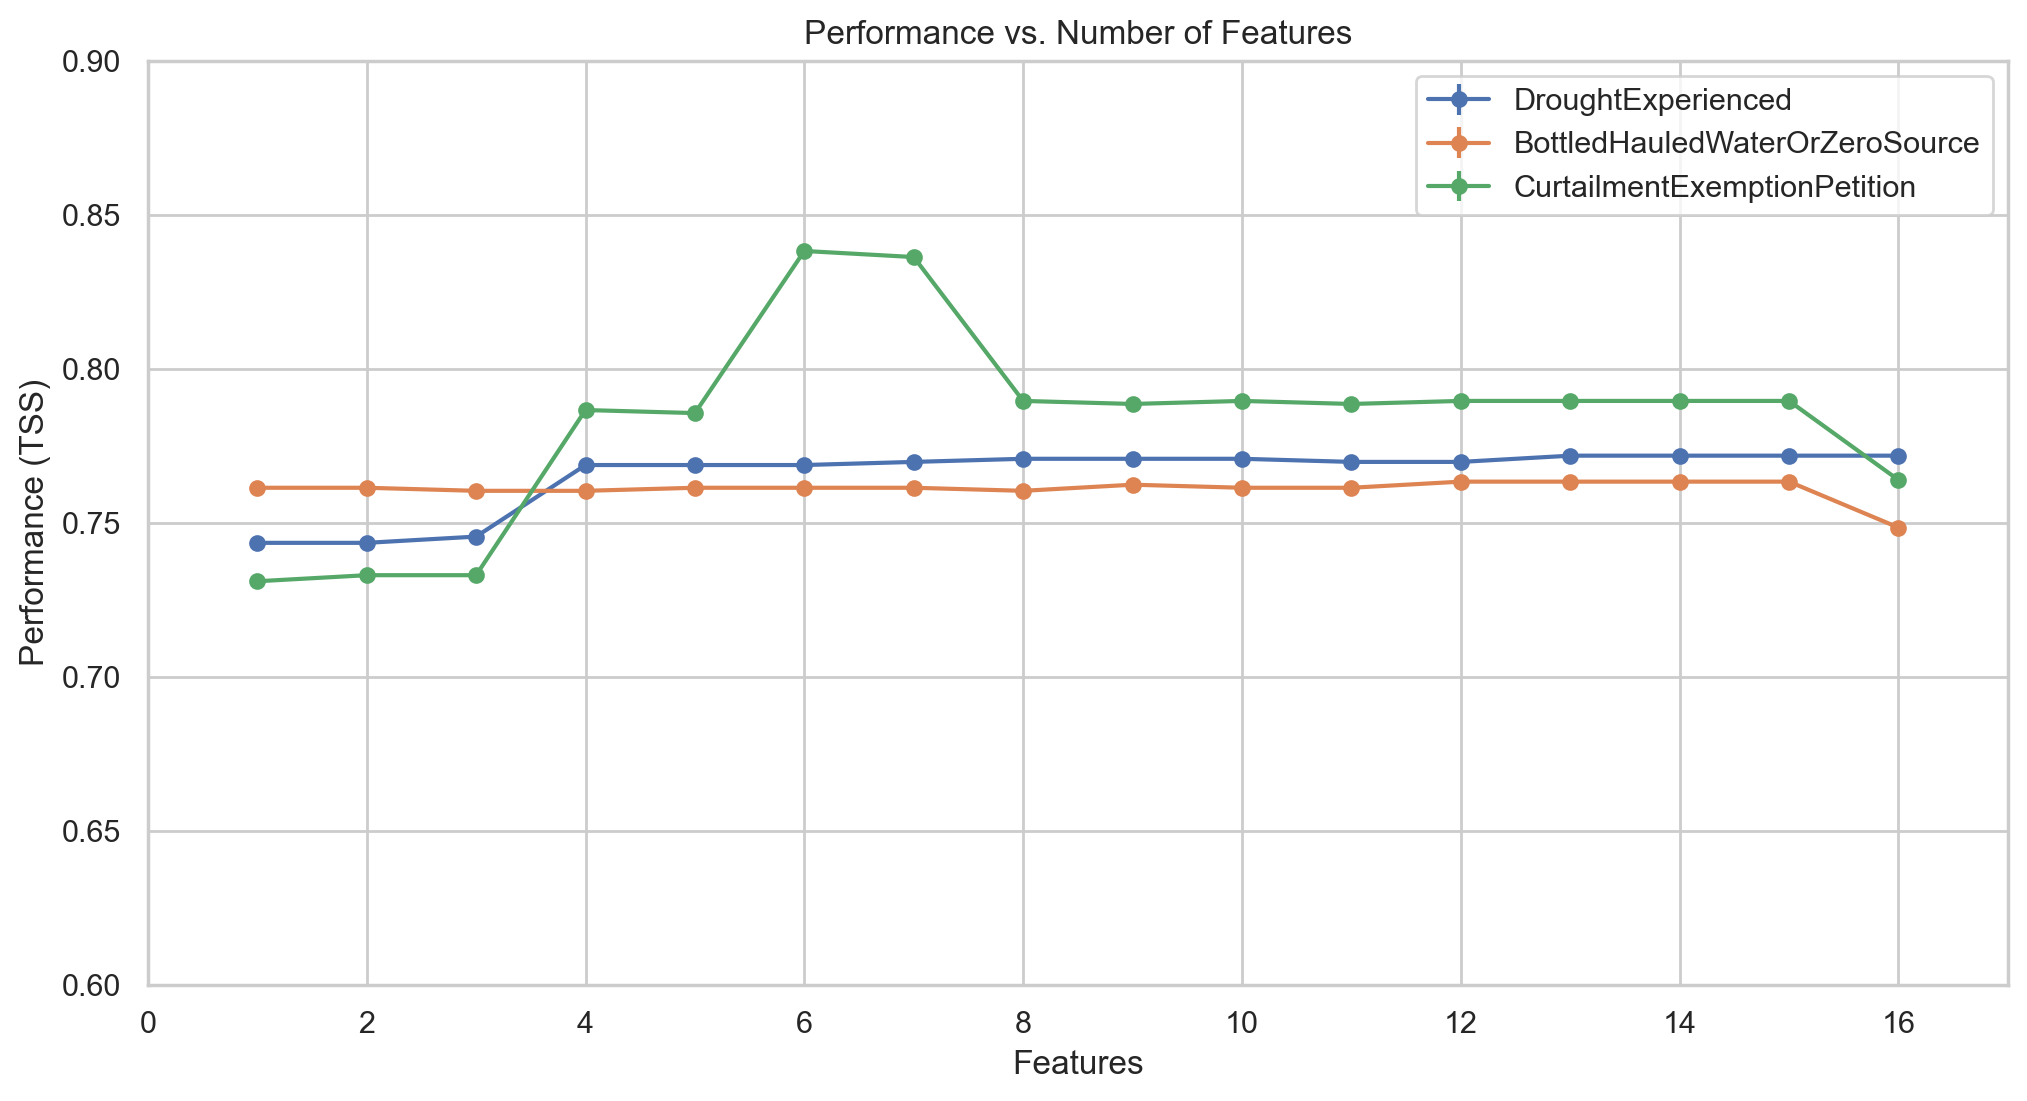

In [221]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(len(df_TSS['TSS Scores'][0]))+1,(df_TSS['TSS Scores'][0]), yerr=(df_TSS['TSS Standard Deviation'][0]), 
            marker=".", markersize=10, label=df_TSS['Outcome Label'][0])
ax.errorbar(np.arange(len(df_TSS['TSS Scores'][1]))+1,(df_TSS['TSS Scores'][1]), yerr=(df_TSS['TSS Standard Deviation'][1]), 
            marker=".", markersize=10, label=df_TSS['Outcome Label'][1])
ax.errorbar(np.arange(len(df_TSS['TSS Scores'][2]))+1,(df_TSS['TSS Scores'][2]), yerr=(df_TSS['TSS Standard Deviation'][2]), 
            marker=".", markersize=10, label=df_TSS['Outcome Label'][2])
ax.set_xlabel('Features')
ax.set_ylabel('Performance (TSS)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.6, 0.9])
ax.set_xlim(0,17)
ax.legend()
#fig.savefig('performancevsfeaturesvslabel_TSS_svm.png', dpi=300, transparent=True, bbox_inches='tight')

### Re-train model

Now that we have validated the model and confirmed that it performs reasonably well, we can re-train it with all the data to predict the outcome for 2023. This means we will have 100% training data and 0% test data. Although we do not split the data, we do scale it again.

* The training data then includes 100% of the features for 2021, including the outcome of 2021, to predict 100% of the labels for 2022.
* The trained model will then run on 100% of the features for 2022, including the outcome of 2022, to predict 100% of the lables for 2023.

Construct the examples

In [222]:
# Construct the features
X_train = df_combined[temporary_all_features][df_combined['Water Year'] == 2021]
X_train = X_train.rename(columns={'DroughtExperienced' : 'Outcome'})
X_train = X_train.drop(columns=temporary_features)

# Construct and unravel the label
y_train = df_combined[['DroughtExperienced']][df_combined['Water Year'] == 2022].reset_index(drop=True)
y_train = y_train.values.ravel()

Select and scale the numeric features and append the categorical ones.

In [223]:
# Select the standard scaler
scaler = preprocessing.StandardScaler()

# Scale the numeric features
X_train_numeric = X_train[numeric_features]
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform

# Select and append the categorical features
X_train_categorical = np.array(X_train[categorical_features])
X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)

Train the model

In [224]:
# Initialize the model
clf = svm.SVC(gamma='auto', kernel='rbf', C=4.0, class_weight={0:1, 1: 5}, probability=True)

# Fit the model
model = clf.fit(X_train_scaled, y_train)

### Predict the 2023 outcomes

Define the test set and scale it using the same scaling as the training set.

In [225]:
# Construct the features
X_test = df_combined[temporary_all_features][df_combined['Water Year'] == 2022]
X_test = X_test.rename(columns={'DroughtExperienced' : 'Outcome'})

# Construct dataframes with temporary features in order to print predicted probabilities
df_X_test = X_test.reset_index(drop=True)

# Drop temporary features
X_test = X_test.drop(columns=temporary_features).reset_index(drop=True)

In [226]:
# Scale the numeric features
X_test_numeric = X_test[numeric_features]
X_test_numeric_scaled = scaler.transform(X_test_numeric) # Use transform

# Select and append the categorical features
X_test_categorical = np.array(X_test[categorical_features])
X_test_scaled = np.concatenate((X_test_numeric_scaled, X_test_categorical), axis=1)

In [227]:
# Predict the outcome with the best estimator
y_pred = clf.predict(X_test_scaled)
y_pred_probability = clf.predict_proba(X_test_scaled)

In [228]:
df_X_test.columns

Index(['CWSID', 'Water Year', 'HUC8', 'ServiceConnections', 'Population',
       'PWPhysicalAddressLat', 'PWPhysicalAddressLong',
       'DSCI Dry Season Average', 'DSCI Wet Season Average',
       'DSCI Dry Wet Delta', 'Total Number of Water Sources', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 'Intertie',
       'Wholesalers', 'Curtailment', 'HUC_Categories', 'Outcome'],
      dtype='object')

In [229]:
cwsids = []
lats = []
longs = []
not_expected = []
expected = []
prediction = []

for i in range(len(X_test)):
    cwsids.append(df_X_test[['CWSID']].iloc[i][0])
    lats.append(df_X_test[['PWPhysicalAddressLat']].iloc[i][0])
    longs.append(df_X_test[['PWPhysicalAddressLong']].iloc[i][0])
    not_expected.append(y_pred_probability[i][0])
    expected.append(y_pred_probability[i][1])

In [230]:
df_predictions_2023 = pd.DataFrame({'CWSID':cwsids, 'latitude':lats, 'longitude':longs, 'Not Expected': not_expected, 'Expected': expected})

In [231]:
df_predictions_2023 = df_predictions_2023.sort_values(by=['Expected'], ascending=False).reset_index(drop=True)

In [232]:
# Get names of all the CWS
df_CWS_names = df_2021_initial[['CWSID', 'RegulatingAgency', 'WaterSystemName']]

In [233]:
df_predictions_2023 = df_predictions_2023.merge(df_CWS_names, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [234]:
df_predictions_2023 = df_predictions_2023.merge(df_X_test[['CWSID', 'Water Year', 'HUC8', 'ServiceConnections', 'Population',
       'DSCI Dry Season Average', 'DSCI Wet Season Average',
       'DSCI Dry Wet Delta', 'Total Number of Water Sources', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 'Intertie',
       'Wholesalers', 'Curtailment', 'HUC_Categories', 'Outcome']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [235]:
df_predictions_2023.to_csv('Predictions_2023.csv')

We define drought impacted CWS as those with a 50% or greater probability of drought. If we conservatively reduce this threshold to 20%, we capture 47 CWS (or 1.6% of all CWS).
The initial Random Forest model had a comparable number of false negatives (10), but identified 500 drought-impacted CWS, or 17.4% of all CWS (albeit during a dry year). 

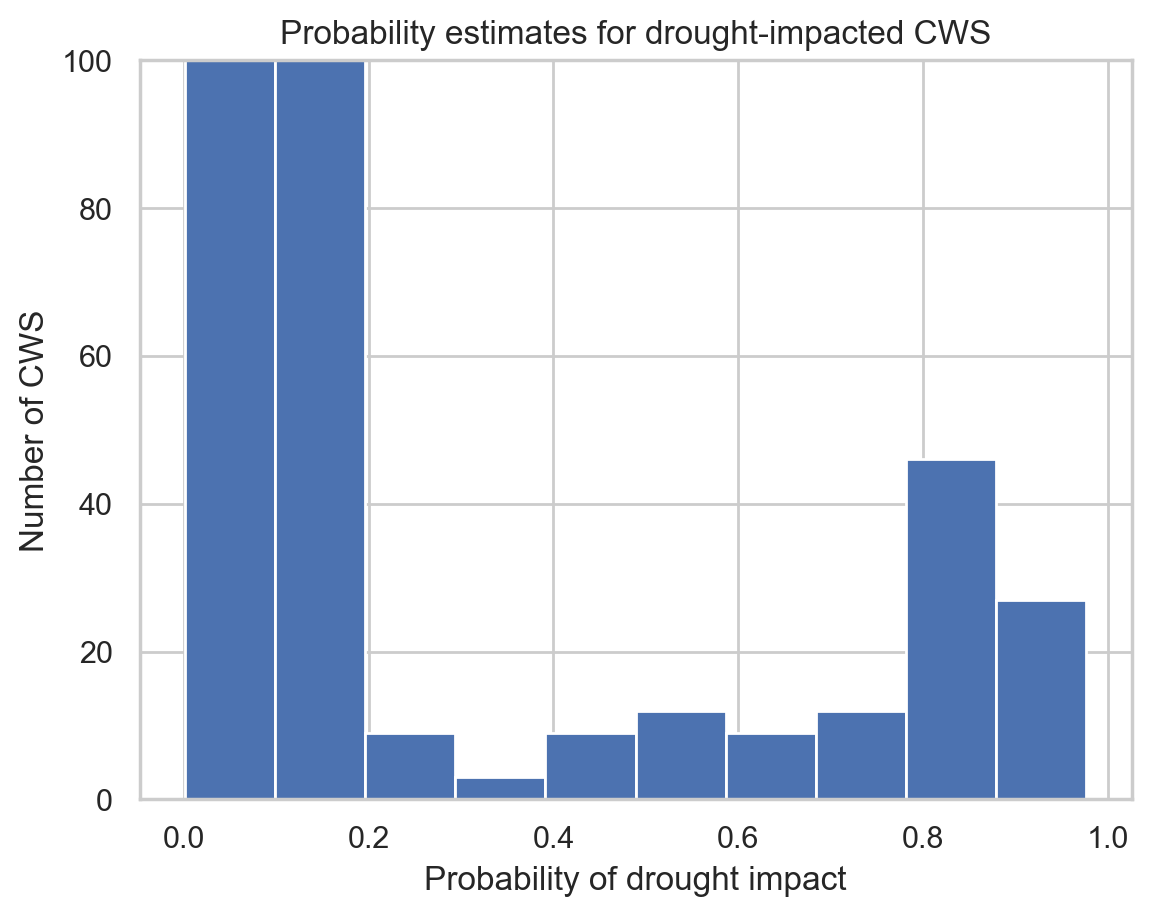

In [236]:
fig, ax = plt.subplots()
ax.hist(df_predictions_2023['Expected'])
ax.set_xlabel('Probability of drought impact')
ax.set_ylabel('Number of CWS')
ax.set_title('Probability estimates for drought-impacted CWS')
ax.set_ylim([0,100])
fig.savefig('probability_drought_zoom.png', dpi=300, transparent=True, bbox_inches='tight')

### Why were these flagged?

We can use an interpretability tool called [Diverse Counterfactual Explanations (DiCE)](http://interpret.ml/DiCE/) ([Mothilal et al. 2021](https://arxiv.org/abs/2011.04917)) to show us why any given CWS was flagged to have a high probability of drought impact. DiCE asks: Given that the model's output for input $x$ is $y$, what would be the output if input is changed to $x'$? To answer this question, DiCE permutes the values of all the features for any given example, uses the model to predict an outcome for this new set of features, and continually repeats this process until the model predicts a different outcome. We can then examine the features of this so-called counterfactual example to give us insight into what it takes to predict a different outcome. 

In [237]:
# Identify all 2022 features
X_test_dice_with_cwsid = df_X_test

In [238]:
# Assume 2023 predictions are true values
df_y_test = df_predictions_2023[['CWSID','Expected']]

In [239]:
# Convert probabilities to binary values. For now, use a threshold of 0.9 to identify CWS with the highest probability of failure.
df_y_test.loc[df_y_test['Expected'] < 0.9, 'Expected'] = 0
df_y_test.loc[df_y_test['Expected'] >= 0.9, 'Expected'] = 1

In [240]:
# Unravel the label
y_test = df_y_test['Expected'].values.ravel()

In [241]:
# Merge predictions with features
X_test_dice_with_cwsid = X_test_dice_with_cwsid.merge(df_y_test, on='CWSID', how='left').drop_duplicates().reset_index(drop=True)

Identify the index values of the the community water systems with a 90% or greater probability of failing.

In [242]:
high_probability_of_failure_index = X_test_dice_with_cwsid[X_test_dice_with_cwsid['Expected'] == 1].index.to_list()

In [243]:
# Drop CWSID
X_test_dice = X_test_dice_with_cwsid.drop(columns=['CWSID', 'Water Year', 'HUC8'])

In [244]:
# Create the DiCE data
d = dice_ml.Data(dataframe=X_test_dice, continuous_features=numeric_features, outcome_name='Expected')

In [245]:
# Initialize the model
clf = svm.SVC(gamma='auto', kernel='rbf', C=4, class_weight={0:1, 1: 5}, probability=True)

In [246]:
X_test_dice = X_test_dice.drop(columns=['Expected'])

In [247]:
# Fit the model
model = clf.fit(X_test_dice, y_test)

In [248]:
# Create the DiCE model
m = dice_ml.Model(model=model, backend="sklearn")

In [249]:
#Create the DiCE explainer
dice_explainer = dice_ml.Dice(d, m, method="kdtree")

In [250]:
# Create the counterfactuals. Note that this is computationally expensive.
dice_counterfactuals = dice_explainer.generate_counterfactuals(X_test_dice.loc[high_probability_of_failure_index], 
                                                                total_CFs=3, desired_class="opposite")

100%|███████████████████████████████████████████| 21/21 [00:05<00:00,  3.56it/s]


In [251]:
X_test_dice_with_cwsid.loc[high_probability_of_failure_index]

CWSID  Water Year      HUC8  ServiceConnections  Population  \
169   CA0900300        2022  18020129               118.0         150   
170   CA0900308        2022  18020129                52.0          79   
173   CA0901217        2022  18020128                48.0         100   
180   CA0910013        2022  18020128              3791.0        9112   
183   CA0910018        2022  18020129               191.0         538   
346   CA1210022        2022  18010107               656.0         803   
679   CA1900062        2022  18070102                22.0         184   
720   CA1900903        2022  18070102                58.0         130   
1266  CA2910002        2022  18020125              1252.0        3148   
1274  CA2910016        2022  18020125               358.0         310   
1375  CA3200102        2022  18020123               197.0         765   
1396  CA3210005        2022  18020123               937.0         737   
1431  CA3301512        2022  18100201                82.0         160   
1433  CA3301529        2022  18070302                95.0         250   
1637  CA3600226        2022  18100201                83.0         450   
2065  CA4200851        2022  18060008                21.0          66   
2115  CA4300573        2022  18060002                18.0          53   
2279  CA4600017        2022  18020125               120.0         324   
2280  CA4600018        2022  18020123               113.0         200   
2285  CA4700503        2022  18010208                31.0          70   
2744  CA5510011        2022  18040010               537.0         153   

      PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
169              38.774630            -120.296860               426.315909   
170              38.906844            -120.838546               426.315909   
173              38.988992            -120.761835               423.284545   
180              38.912373            -120.833732               423.284545   
183              38.735615            -120.787240               426.315909   
346              40.028593            -124.065326               288.556364   
679              34.478605            -118.463357               437.200909   
720              34.510166            -118.361835               437.200909   
1266             39.247201            -121.002271               430.571818   
1274             39.326603            -120.392434               430.571818   
1375             39.715890            -120.546551               416.270455   
1396             39.767241            -120.619600               416.270455   
1431             33.597200            -116.449735               322.437273   
1433             33.555269            -116.674182               284.908636   
1637             34.094725            -116.521654               322.437273   
2065             34.953034            -120.435719               377.272727   
2115             37.109972            -121.683960               390.096818   
2279             39.574504            -120.615826               430.571818   
2280             39.584577            -120.369267               416.270455   
2285             41.309588            -122.801418               389.505909   
2744             38.161773            -120.056822               433.173182   

      DSCI Wet Season Average  DSCI Dry Wet Delta  \
169                356.399231           69.916678   
170                356.399231           69.916678   
173                351.342308           71.942238   
180                351.342308           71.942238   
183                356.399231           69.916678   
346                286.422692            2.133671   
679                349.014231           88.186678   
720                349.014231           88.186678   
1266               353.948846           76.622972   
1274               353.948846           76.622972   
1375               317.053077           99.217378   
1396               317.053077           99.217378 

Visualize each counterfactual as a dataframe. 

Why does the counterfactual get the original outcome wrong?

In [252]:
dice_counterfactuals.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               118.0         150             38.774632   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0             -120.29686               426.315918               356.399231   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           69.916679                            2.0       0.0       1.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
18              863.0     7851.0             38.68997             -120.0714   
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
18                   426.3               356.39923          69.916679   
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
18                           4.0         -       0.0   
17                           1.0         -       0.0   
20                           1.0         -       0.0   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
18                                           -        -           -   
17                                           -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
18           0              -       0        -  
17           -              -       0        -  
20           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                52.0          79             38.906845   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.838547               426.315918               356.399231   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           69.916679                            1.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
18              863.0     7851.0             38.68997             -120.0714   
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
18                   426.3               356.39923          69.916679   
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
18                           4.0         -         -   
17                             -         -         -   
20                             -         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
18                                           -        -           -   
17                                           -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
18           0              -       0        -  
17           -              -       0        -  
20           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                48.0         100             38.988991   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.761833               423.284546               351.342316   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           71.942238                            3.0       1.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
0                19.0       50.0             37.73708             -122.0277   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
0                    454.9               385.90961          68.974022   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                           1.0       0.0         -   
0                              -       0.0         -   
20                           1.0       0.0         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
0                                            -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
0            0              1       0        -  
20           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0              3791.0        9112             38.912373   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.833733               423.284546               351.342316   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           71.942238                            2.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
18              863.0     7851.0             38.68997             -120.0714   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
18                   426.3               356.39923          69.916679   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                           1.0         -         -   
18                           4.0         -         -   
20                           1.0         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
18                                           -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
18           0              -       0        -  
20           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               191.0         538             38.735615   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.787239               426.315918               356.399231   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           69.916679                            1.0       1.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
18              863.0     7851.0             38.68997             -120.0714   
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
18                   426.3               356.39923          69.916679   
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
18                           4.0       0.0         -   
17                             -       0.0         -   
20                             -       0.0         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
18                                           -        -           -   
17                                           -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
18           0              -       0        -  
17           -              -       0        -  
20           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               656.0         803             40.028595   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -124.065323               288.556366               286.422699   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0            2.133671                           19.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              3       0       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
15              167.0       25.0             38.69372             -119.7797   
16               32.0       70.0             38.75767             -119.8165   
14               16.0       50.0             38.69372             -119.7797   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
15                   390.7               294.61539          96.070976   
16                   390.7               294.61539          96.070976   
14                   390.7               294.61539          96.070976   

   Total Number of Water Sources Score_SCV Score_SCM  \
15                           3.0         -         -   
16                           1.0         -         -   
14                           2.0         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
15                                           -        -           -   
16                                           -        -           -   
14                                           1        -           -   

   Curtailment HUC_Categories Outcome Expected  
15           -              -       -        -  
16           -              -       -        -  
14           -              -       -        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                22.0         184             34.478603   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -118.463356               437.200897               349.014221   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           88.186676                            0.0       1.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              1       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
0                19.0       50.0             37.73708             -122.0277   
16               32.0       70.0             38.75767             -119.8165   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
0                    454.9               385.90961          68.974022   
16                   390.7               294.61539          96.070976   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
0                            3.0       0.0         -   
16                           1.0       0.0         -   
20                           1.0       0.0         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                            -        -           -   
16                                           -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
0            -              -       0        -  
16           -              3       0        -  
20           -              2       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                58.0         130             34.510166   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -118.361832               437.200897               349.014221   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           88.186676                            3.0       1.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              1       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
0                19.0       50.0             37.73708             -122.0277   
15              167.0       25.0             38.69372             -119.7797   
10             9943.0    30000.0             37.69114             -121.8072   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
0                    454.9               385.90961          68.974022   
15                   390.7               294.61539          96.070976   
10                   454.9               385.90961          68.974022   

   Total Number of Water Sources Score_SCV Score_SCM  \
0                              -       0.0         -   
15                             -       0.0         -   
10                             -       0.0         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                            -        -           -   
15                                           -        -           -   
10                                           -      1.0           -   

   Curtailment HUC_Categories Outcome Expected  
0            -              -       0        -  
15           -              3       0        -  
10           -              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0              1252.0        3148               39.2472   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -121.002274               430.571808               353.948853   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           76.622971                            1.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   
19               67.0      214.0             38.44102             -120.8544   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   
19                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                             -         -         -   
20                             -         -         -   
19                             -         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
20                                           -        -           -   
19                                           -      1.0           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
20           0              -       0        -  
19           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               358.0         310             39.326603   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.392433               430.571808               353.948853   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           76.622971                            1.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   
19               67.0      214.0             38.44102             -120.8544   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   
19                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                             -         -         -   
20                             -         -         -   
19                             -         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
20                                           -        -           -   
19                                           -      1.0           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
20           0              -       0        -  
19           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               197.0         765             39.715889   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.546555               416.270447                317.05307   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           99.217377                            1.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   
19               67.0      214.0             38.44102             -120.8544   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   
19                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                             -         -         -   
20                             -         -         -   
19                             -         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
20                                           -        -           -   
19                                           -      1.0           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
20           0              -       0        -  
19           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               937.0         737             39.767242   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.619598               416.270447                317.05307   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           99.217377                            1.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   
19               67.0      214.0             38.44102             -120.8544   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   
19                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                             -         -         -   
20                             -         -         -   
19                             -         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
20                                           -        -           -   
19                                           -      1.0           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
20           0              -       0        -  
19           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                82.0         160             33.597202   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -116.449738               322.437286               250.790771   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           71.646507                            1.0       0.0       1.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              3       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
16               32.0       70.0             38.75767             -119.8165   
15              167.0       25.0             38.69372             -119.7797   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
16                   390.7               294.61539          96.070976   
15                   390.7               294.61539          96.070976   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
16                             -         -       0.0   
15                           3.0         -       0.0   
20                             -         -       0.0   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
16                                           -        -           -   
15                                           -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
16           -              -       0        -  
15           -              -       0        -  
20           -              2       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                95.0         250             33.555267   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -116.674179                284.90863               237.516922   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           47.391712                            4.0       1.0       1.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              1       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
0                19.0       50.0             37.73708             -122.0277   
18              863.0     7851.0             38.68997             -120.0714   
7             22815.0    79201.0              37.6764             -121.8591   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
0                    454.9               385.90961          68.974022   
18                   426.3               356.39923          69.916679   
7                    454.9               385.90961          68.974022   

   Total Number of Water Sources Score_SCV Score_SCM  \
0                            3.0       0.0       0.0   
18                             -       0.0       0.0   
7                              -       0.0       0.0   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                            -        -           -   
18                                           -        -           -   
7                                            -      1.0           -   

   Curtailment HUC_Categories Outcome Expected  
0            -              -       0        -  
18           -              2       0        -  
7            -              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                83.0         450             34.094727   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -116.521652               322.437286               250.790771   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           71.646507                            3.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           1      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              3       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
14               16.0       50.0             38.69372             -119.7797   
15              167.0       25.0             38.69372             -119.7797   
16               32.0       70.0             38.75767             -119.8165   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
14                   390.7               294.61539          96.070976   
15                   390.7               294.61539          96.070976   
16                   390.7               294.61539          96.070976   

   Total Number of Water Sources Score_SCV Score_SCM  \
14                           2.0         -         -   
15                             -         -         -   
16                           1.0         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
14                                           -        -           -   
15                                           0        -           -   
16                                           0        -           -   

   Curtailment HUC_Categories Outcome Expected  
14           -              -       0        -  
15           -              -       0        -  
16           -              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                21.0          66             34.953033   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.435722               377.272736               315.026154   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           62.246574                            1.0       1.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              1       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
16               32.0       70.0             38.75767             -119.8165   
20               20.0       40.0              38.3488             -120.7741   
0                19.0       50.0             37.73708             -122.0277   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
16                   390.7               294.61539          96.070976   
20                   452.5               374.33884          78.138428   
0                    454.9               385.90961          68.974022   

   Total Number of Water Sources Score_SCV Score_SCM  \
16                             -       0.0         -   
20                             -       0.0         -   
0                            3.0       0.0         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
16                                           -        -           -   
20                                           -        -           -   
0                                            -        -           -   

   Curtailment HUC_Categories Outcome Expected  
16           -              3       0        -  
20           -              2       0        -  
0            -              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                18.0          53              37.10997   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0             -121.68396               390.096832               346.423065   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0            43.67374                            2.0       1.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           0              1       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
0               19.0       50.0             37.73708             -122.0277   
1              191.0      459.0             37.71534             -122.1474   
8            24835.0    86895.0             37.70645             -121.9208   

  DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
0                   454.9               385.90961          68.974022   
1                   454.9               385.90961          68.974022   
8                   454.9               385.90961          68.974022   

  Total Number of Water Sources Score_SCV Score_SCM  \
0                           3.0       0.0         -   
1                             -       0.0         -   
8                             -       0.0         -   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           -        -           -   
1                                           -      1.0           -   
8                                           -      1.0           -   

  Curtailment HUC_Categories Outcome Expected  
0           -              -       0        -  
1           -              -       0        -  
8           -              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               120.0         324             39.574505   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.615829               430.571808               353.948853   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           76.622971                            2.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   
18              863.0     7851.0             38.68997             -120.0714   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   
18                   426.3               356.39923          69.916679   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                           1.0         -         -   
20                           1.0         -         -   
18                           4.0         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
20                                           -        -           -   
18                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
20           0              -       0        -  
18           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               113.0         200             39.584576   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0             -120.36927               416.270447                317.05307   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           99.217377                            1.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   
19               67.0      214.0             38.44102             -120.8544   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   
19                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                             -         -         -   
20                             -         -         -   
19                             -         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
20                                           -        -           -   
19                                           -      1.0           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
20           0              -       0        -  
19           0              -       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                31.0          70             41.309589   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -122.801414                389.50592               339.944244   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0            49.56168                            1.0       0.0       1.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              3       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
16               32.0          -             38.75767             -119.8165   
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
16                   390.7               294.61539          96.070976   
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   

   Total Number of Water Sources Score_SCV Score_SCM  \
16                             -         -       0.0   
17                             -         -       0.0   
20                             -         -       0.0   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
16                                           -        -           -   
17                                           -        -           -   
20                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
16           0              -       0        -  
17           -              2       0        -  
20           0              2       0        -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0               537.0         153             38.161774   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.056824               433.173187               374.475769   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           58.697414                            2.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  Expected  
0           1              2       1       0.0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
17              488.0      625.0             38.47198             -120.0442   
20               20.0       40.0              38.3488             -120.7741   
18              863.0     7851.0             38.68997             -120.0714   

   DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
17                   433.2               374.47577          58.697414   
20                   452.5               374.33884          78.138428   
18                   426.3               356.39923          69.916679   

   Total Number of Water Sources Score_SCV Score_SCM  \
17                           1.0         -         -   
20                           1.0         -         -   
18                           4.0         -         -   

   Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
17                                           -        -           -   
20                                           -        -           -   
18                                           -        -           -   

   Curtailment HUC_Categories Outcome Expected  
17           -              -       0        -  
20           0              -       0        -  
18           0              -       0        -

### Compare to 2022 outcomes

In [253]:
print('The model flagged {} CWS in the 2022 validation set (30% of the data).'.format(len(df_predictions_2022[df_predictions_2022['Expected'] >= 0.5])))
print('There were {} drought-impacted CWS in 2022.'.format(len(df_combined[(df_combined['Water Year'] == 2022) & (df_combined['DroughtExperienced'] == 1)])))

The model flagged 39 CWS in the 2022 validation set (30% of the data).
There were 122 drought-impacted CWS in 2022.


In [254]:
print('The model flagged {} CWS in 2023 (assuming a threshold of 50%).'.format(len(df_predictions_2023[df_predictions_2023['Expected'] >= 0.5])))

The model flagged 105 CWS in 2023 (assuming a threshold of 50%).


In [255]:
print('If the threshold is 20%, the model flagged {} CWS in 2023.'.format(len(df_predictions_2023[df_predictions_2023['Expected'] >= 0.2])))

If the threshold is 20%, the model flagged 126 CWS in 2023.


How many of the 2022 drought-impacted CWS were selected again in 2023?

In [256]:
list_cws_2022 = df_combined[(df_combined['Water Year'] == 2022) & (df_combined['DroughtExperienced'] == 1)]['CWSID'].to_list()
list_cws_2023 = df_predictions_2023[df_predictions_2023['Expected'] >= 0.5]['CWSID'].to_list()

In [257]:
print('Of the {} CWS the model flagged in 2023, {} were also drought-impacted in 2022.'.format(len(df_predictions_2023[df_predictions_2023['Expected'] >= 0.5]), 
                                                                                       len(list(set(list_cws_2022).intersection(list_cws_2023)))))

Of the 105 CWS the model flagged in 2023, 104 were also drought-impacted in 2022.


Here is the CWS flagged in 2023 but not in 2022:

In [258]:
set(list_cws_2023) - set(list_cws_2022)

{'CA1210022'}

In [259]:
df_X_test[df_X_test['CWSID'] == 'CA1210022']

CWSID  Water Year      HUC8  ServiceConnections  Population  \
346  CA1210022        2022  18010107               656.0         803   

     PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
346             40.028593            -124.065326               288.556364   

     DSCI Wet Season Average  DSCI Dry Wet Delta  \
346               286.422692            2.133671   

     Total Number of Water Sources  Score_SCV  Score_SCM  \
346                           19.0        0.0        0.0   

     Score_CriticallyOverdraftedGroundwaterBasin  Intertie  Wholesalers  \
346                                            0       0.0          0.0   

     Curtailment  HUC_Categories  Outcome  
346            0               3        0

Where are the CWS that were drought-impacted in 2022?

In [260]:
df_2022_droughtCWS = df_combined[(df_combined['Water Year'] == 2022) & (df_combined['DroughtExperienced'] == 1)].rename(columns={'PWPhysicalAddressLat':'latitude', 'PWPhysicalAddressLong':'longitude'})

In [261]:
df_2023_droughtCWS = df_predictions_2023[df_predictions_2023['Expected'] >= 0.5]

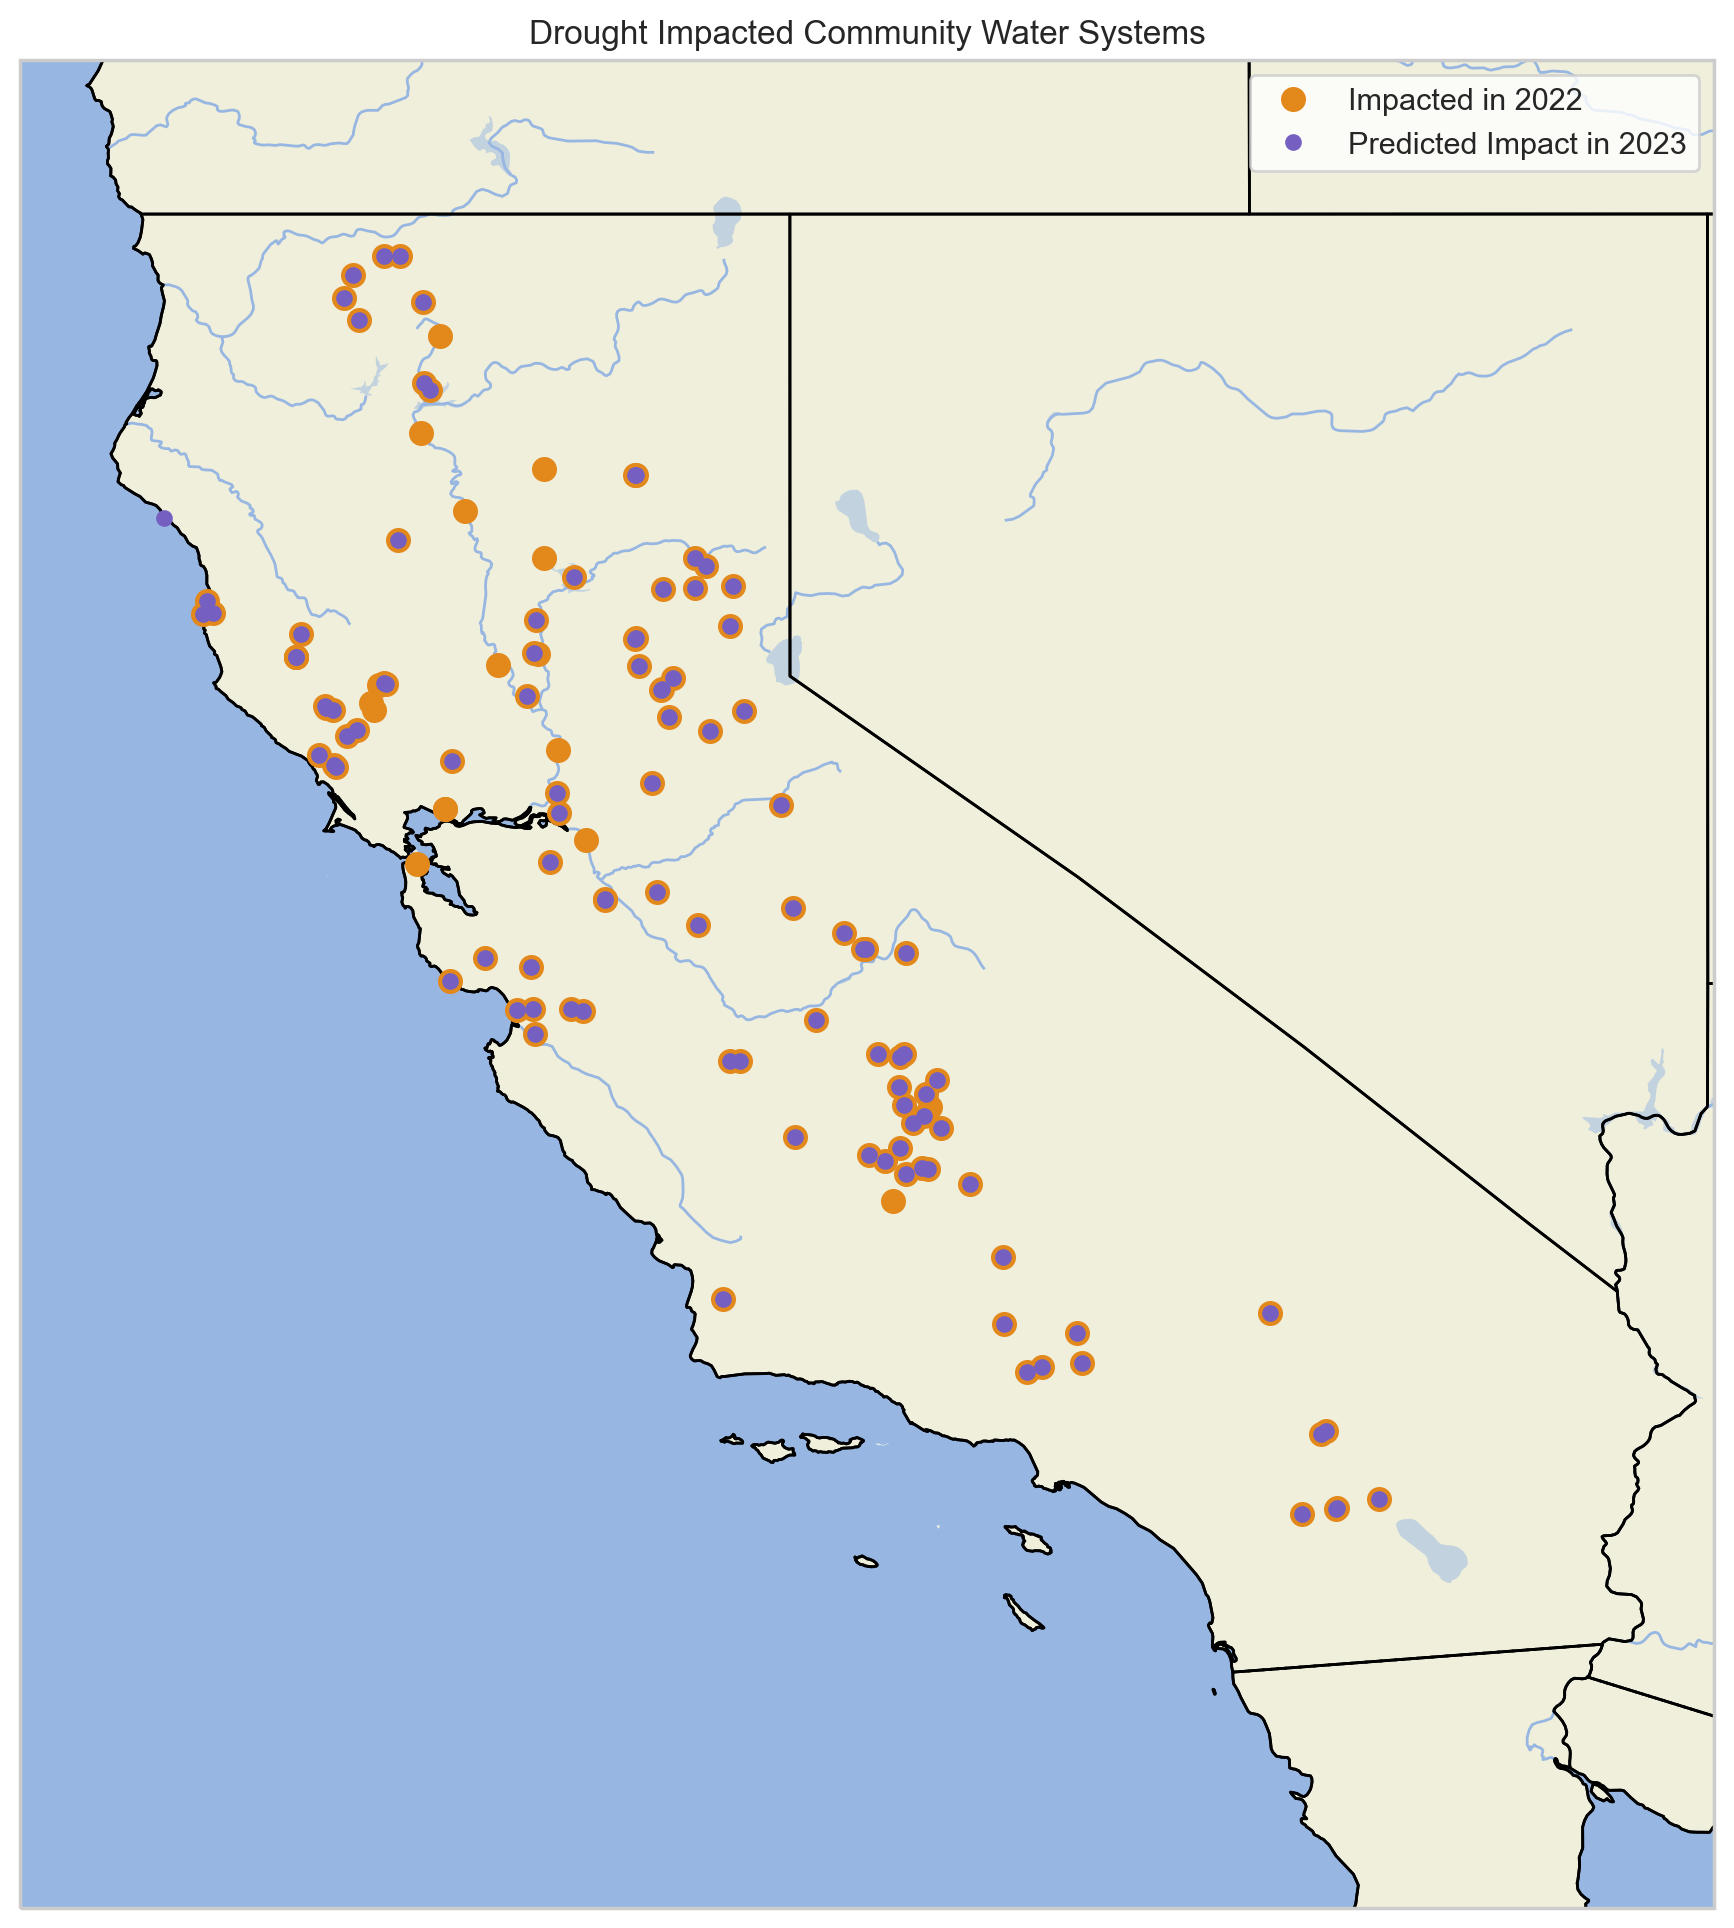

In [262]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-125, -114, 31, 43], crs=ccrs.PlateCarree())

odi_mustard = "#E3881B"
odi_purple = "#7560C1"

ax.plot(df_2022_droughtCWS['longitude'], df_2022_droughtCWS['latitude'], marker='o', 
        linestyle='None', color=odi_mustard, markersize=8, alpha=1.0, transform=ccrs.PlateCarree(), label='Impacted in 2022')
ax.plot(df_2023_droughtCWS['longitude'], df_2023_droughtCWS['latitude'], marker='o', 
        linestyle='None', color=odi_purple, markersize=5, alpha=1.0, transform=ccrs.PlateCarree(), label='Predicted Impact in 2023')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)
ax.legend()
ax.set_title('Drought Impacted Community Water Systems')
plt.show()

fig.savefig('locations.png', dpi=300, transparent=True, bbox_inches='tight')